In [31]:
from __future__ import print_function

import numpy as np
import yt
import unyt
from yt.units import *
from yt import YTArray
import argparse
import os
import glob
import sys
from astropy.table import Table
from astropy.io import ascii
import matplotlib.pyplot as plt
import random
from scipy import interpolate
from scipy.signal import correlate2d
#from photutils import detect_threshold, detect_sources, source_properties, EllipticalAperture
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.optimize import minimize
import trident
import ast
#import emcee
import numpy.random as rn
from multiprocessing import Pool
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import matplotlib.cm as mtcm
from yt.units import kpc, cm
import cmasher as cmr

# These imports are FOGGIE-specific files
from foggie.utils.consistency import *
from foggie.utils.get_refine_box import get_refine_box
from foggie.utils.get_halo_center import get_halo_center
from foggie.utils.get_proper_box_size import get_proper_box_size
from foggie.utils.get_run_loc_etc import get_run_loc_etc
from foggie.utils.yt_fields import *
from foggie.utils.foggie_load import *
from foggie.utils.analysis_utils import *

# These imports for datashader plots
import datashader as dshader
from datashader.utils import export_image
import datashader.transfer_functions as tf
import pandas as pd
import matplotlib as mpl
import h5py
import matplotlib.cm as mtcm
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

from foggie.clumps.clump_finder.utils_diskproject import load_disk 
from collections import defaultdict
import pandas as pd
import math
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


from foggie.clumps.clump_finder.utils_clump_finder import *
from foggie.clumps.clump_finder.clump_finder_argparser import *
from foggie.clumps.clump_finder.fill_topology import *
from foggie.clumps.clump_finder.clump_load import *
from foggie.clumps.clump_finder.clump_finder import clump_finder



In [36]:
def generate_foggie_paths(halo, run, snap):
    # Define base paths
    foggie_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_data/"
    code_base_path = "/Users/vidasaeedzadeh/Projects/repositories/foggie/foggie/"
    output_base_dir = "/Users/vidasaeedzadeh/Projects/foggie_outputs/"

    # Zero-pad the halo number to 6 digits
    halo_number = halo.zfill(6)

    # Define directory and file paths dynamically
    foggie_dir = os.path.join(foggie_base_dir, f"halo_{halo_number}", run + '/')
    snap_name = os.path.join(foggie_dir, snap, snap)
    halo_c_v_name = os.path.join(code_base_path, f"halo_infos/{halo_number}/{run}/halo_c_v")
    trackname = os.path.join(code_base_path, f"halo_tracks/{halo_number}/nref11n_selfshield_15/halo_track_200kpc_nref9")

    # Output directory (adjust based on needs)
    output_dir = output_base_dir

    # Return paths
    return foggie_dir,code_base_path, snap_name, halo_c_v_name, trackname, output_dir

# specify halo and snapshot


run = 'nref11c_nref9f'#'ludicrous/nref11c_nref9f.enhance'

ions = ['CII','SiII','MgII','CIII','SiIII','CIV','SiIV','OVI']#['CII','CIII','CIV','OVI','SiII','SiIII','SiIV','MgII']
orientations = ['face']#,'edge']
regions = ['cgm'] #['thick_shell4']#
cmap = mtcm.get_cmap('tab10', len(ions))  

box_name = '100'
output = 'RD0032'
snap = output
resolutions = [0.27,1,3,6]
if snap == 'RD0042':
    halos = ['2392','4123','5016','5036','8508']
    z = '0.0'
elif snap == 'RD0040':
    halos = ['2878','2392','4123','5016','5036','8508']
    z = '0.1'
elif snap == 'RD0032':
    halos = ['2878','2392','4123','5016','5036','8508']
    z = '0.5'


unit_system = 'photons'

log_vals = [10,50,100,200,300,400,500,1000,2000,3000,4000]#

flux_thresholds = {
    'HI': list(log_vals),
    'CII': list(log_vals),
    'CIII': list(log_vals),
    'CIV': list(log_vals),
    'OVI': list(log_vals),
    'MgII': list(log_vals),
    'SiII': list(log_vals),
    'SiIII': list(log_vals),
    'SiIV': list(log_vals)
}

/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_66043/3379313270.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mtcm.get_cmap('tab10', len(ions))


In [13]:
import pandas as pd
orientation = 'face'

# Dictionary to store masses
mass_table = {}
ions = ['HI','CII','SiII','MgII','CIII','SiIII','CIV','SiIV','OVI']

for halo in halos:
    halo_name = halo_dict[halo]
    mass_table[halo_name] = {}  # Create empty dict for each halo

    for ion in ions:
        foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

        # Assume resolution is the highest (finest) you have
        resolution = resolutions[0]

        if regions == ['all']:
            prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
        elif regions == ['cgm']:
            prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

        save_path = os.path.join(prefix, 'FRBs')
        file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

        with h5py.File(file_path, 'r') as f:
            mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{regions[0]}']).flatten()  # or change to face/cgm if needed

        total_mass = mass_data.sum()
        mass_table[halo_name][ion] = total_mass

# Now turn into a nice table
df_mass = pd.DataFrame.from_dict(mass_table, orient='index')
df_mass.index.name = 'Halo'
df_mass.columns.name = 'Ion'

# Add a column for sum of all ions except HI
ions_except_HI = [ion for ion in ions if ion != 'HI']
df_mass['All Ions (except HI)'] = df_mass[ions_except_HI].sum(axis=1)
print(regions[0],orientation)
print(df_mass)

# Save as CSV if you want
#df_mass.to_csv('halo_ion_masses.csv')


cgm face
Ion                  HI            CII          SiII          MgII  \
Halo                                                                 
Cyclone    1.375712e+09   45380.108999   7833.234301   4168.604580   
Hurricane  5.527290e+09  119931.256453  19637.637165  10670.774676   
Blizzard   8.762431e+08   74745.339634  12153.390807   5770.759355   
Squall     8.903392e+08   50222.091320   8675.734423   4274.684136   
Maelstrom  2.628896e+09   89489.136482  17709.761157   9807.252898   
Tempest    2.983495e+09  136238.802958  32055.101166  20873.526020   

Ion                CIII        SiIII          CIV         SiIV          OVI  \
Halo                                                                          
Cyclone    31664.935345  3042.138323  1804.657399   560.875125  1885.528306   
Hurricane  68363.390601  5781.928528  3739.311091  1197.208676  2479.910036   
Blizzard   54264.618969  4775.483739  2850.167482   910.895028  2662.287154   
Squall     43186.996405  3266.91426

/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_66043/707827320.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/FINAL_allions_heatmap_face_cgm_z0.5.png


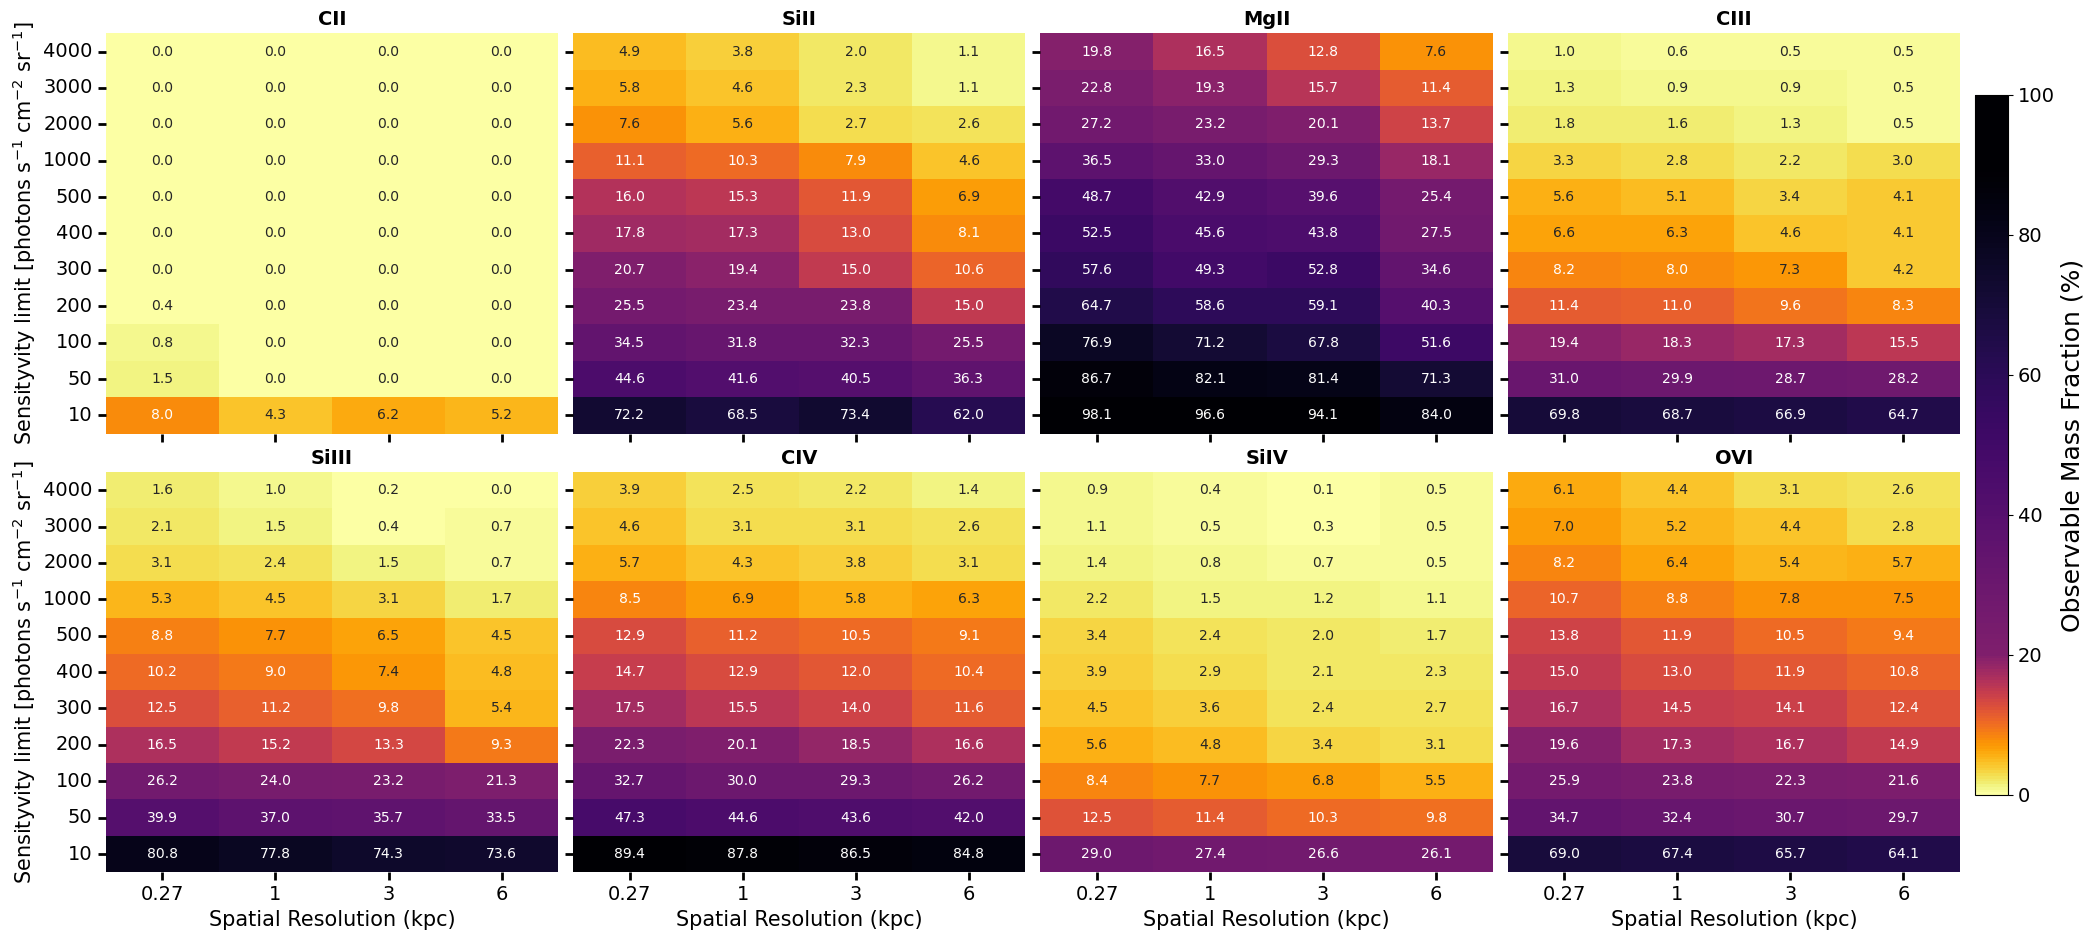

In [37]:

def stretch_colormap(cmap, mid_value=0.2, mid_compress=0.5):
    """Create a new colormap that stretches colors near the low end."""
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    N = 256  # resolution of the colormap

    # Stretching function
    below = 0.65
    above = 0.4
    def scale(x):
        if x < mid_value:
            return below * (x / mid_value)  # Stretch 0–mid_value into 0–0.5
        else:
            return below + above * ((x - mid_value) / (1 - mid_value))  # Compress mid_value–1 into 0.5–1

    # Build new color mapping
    for i in range(N):
        old_idx = i / (N-1)
        new_idx = scale(old_idx)
        r, g, b, a = cmap(new_idx)
        cdict['red'].append((old_idx, r, r))
        cdict['green'].append((old_idx, g, g))
        cdict['blue'].append((old_idx, b, b))
        cdict['alpha'].append((old_idx, a, a))

    new_cmap = colors.LinearSegmentedColormap('stretched_cmap', cdict)
    return new_cmap

region = regions[0]
fig, axs = plt.subplots(2, 4, figsize=(22, 10), sharex=True, sharey=True)
axs = axs.flatten()

# Create a single color scale
vmin = 0
vmax = 100
cmap = cmr.get_sub_cmap('inferno_r', 0.0, 1)
stretched_cmap = stretch_colormap(cmap, mid_value=0.2)



for orientation in orientations:
    all_heatmaps = []
    for ion_idx, ion in enumerate(ions):
        ax = axs[ion_idx]
        heatmap_array = np.zeros((len(flux_thresholds[ion]), len(resolutions)))

        for res_idx, resolution in enumerate(resolutions):
            all_fractions_per_thresh = []

            for halo in halos:
                halo_name = halo_dict[halo]
                foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                if region == 'all':
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
                elif region == 'cgm':
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                save_path = os.path.join(prefix, 'FRBs')
                file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                with h5py.File(file_path, 'r') as f:
                    mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                    emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                total_mass = mass_data.sum()
                halo_fractions = []
                for thresh in flux_thresholds[ion]:
                    above_id = np.where(emission_data >= thresh)
                    mass_above = mass_data[above_id].sum()
                    frac = (mass_above / total_mass) * 100
                    halo_fractions.append(frac)

                all_fractions_per_thresh.append(halo_fractions)

            # Compute mean across halos, store in column for that resolution
            mean_fractions = np.mean(all_fractions_per_thresh, axis=0)
            for t_idx, frac in enumerate(mean_fractions):
                heatmap_array[t_idx, res_idx] = frac

        # Flip and annotate
        flipped_array = np.flipud(heatmap_array)
        annotations = np.round(flipped_array, 1)

        # Save for shared colorbar setup
        im = sns.heatmap(
            flipped_array,
            annot=annotations,
            fmt=".1f",
            ax=ax,
            xticklabels=resolutions,
            yticklabels=flux_thresholds[ion][::-1],
            vmin=vmin,
            vmax=vmax,
            cmap=stretched_cmap,
            cbar=False  # Disable individual colorbars
            #norm=norm
        )

        if ion_idx == 0 or ion_idx == 4:
            ax.set_ylabel('Sensityvity limit [photons s$^{-1}$ cm$^{-2}$ sr$^{-1}$]', fontsize=15)
        else:
            ax.set_ylabel('')

        # Set x-labels only on the bottom row (row 1, i.e., ion_idx >= 4)
        if ion_idx >= 4:
            ax.set_xlabel('Spatial Resolution (kpc)', fontsize=15)
        else:
            ax.set_xlabel('')
        ax.set_title(ion, fontsize=14, fontweight='bold')
        ax.tick_params(axis='both', labelsize=14, length=6, width=2)
        ax.tick_params(axis='y', labelrotation=0)


        all_heatmaps.append(im)

    # Shared colorbar (based on last heatmap object)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(all_heatmaps[-1].collections[0], cax=cbar_ax)
    cbar.set_label('Observable Mass Fraction (%)', fontsize=18)
    cbar.ax.tick_params(labelsize=14)

    # Final layout
    #fig.suptitle(f'Mean Mass Fraction Heatmaps - {orientation}, {region}, z={z}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])

    output_file = os.path.join(output_dir, 'All_halos', 'allhalos_massfrac_sensitivity_plots', f'FINAL_allions_heatmap_{orientation}_{region}_z{z}.png')
    print(f'Saving figure to {output_file}')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()


In [27]:
30 - 6/30

29.8

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Cyclone_face_on_cgm_by_ion_reslines.png


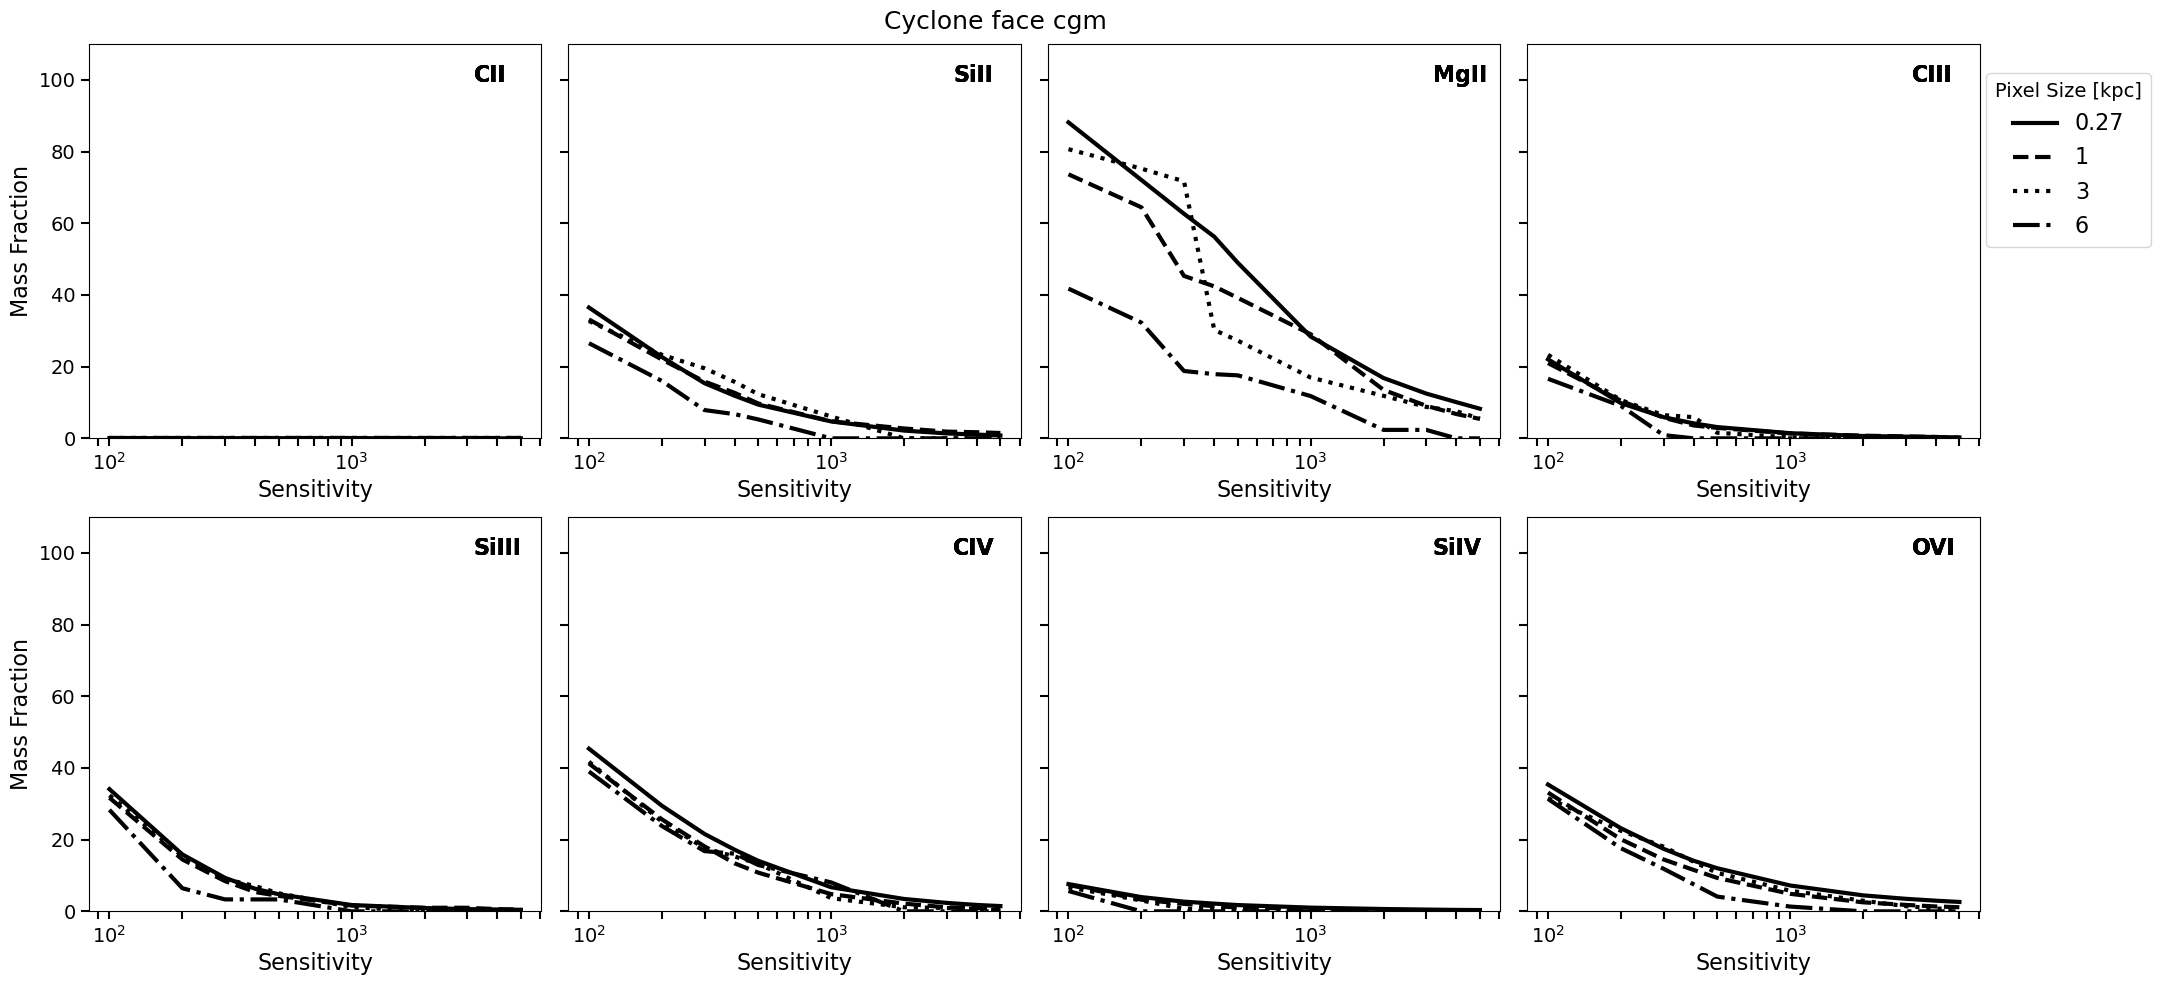

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Hurricane_face_on_cgm_by_ion_reslines.png


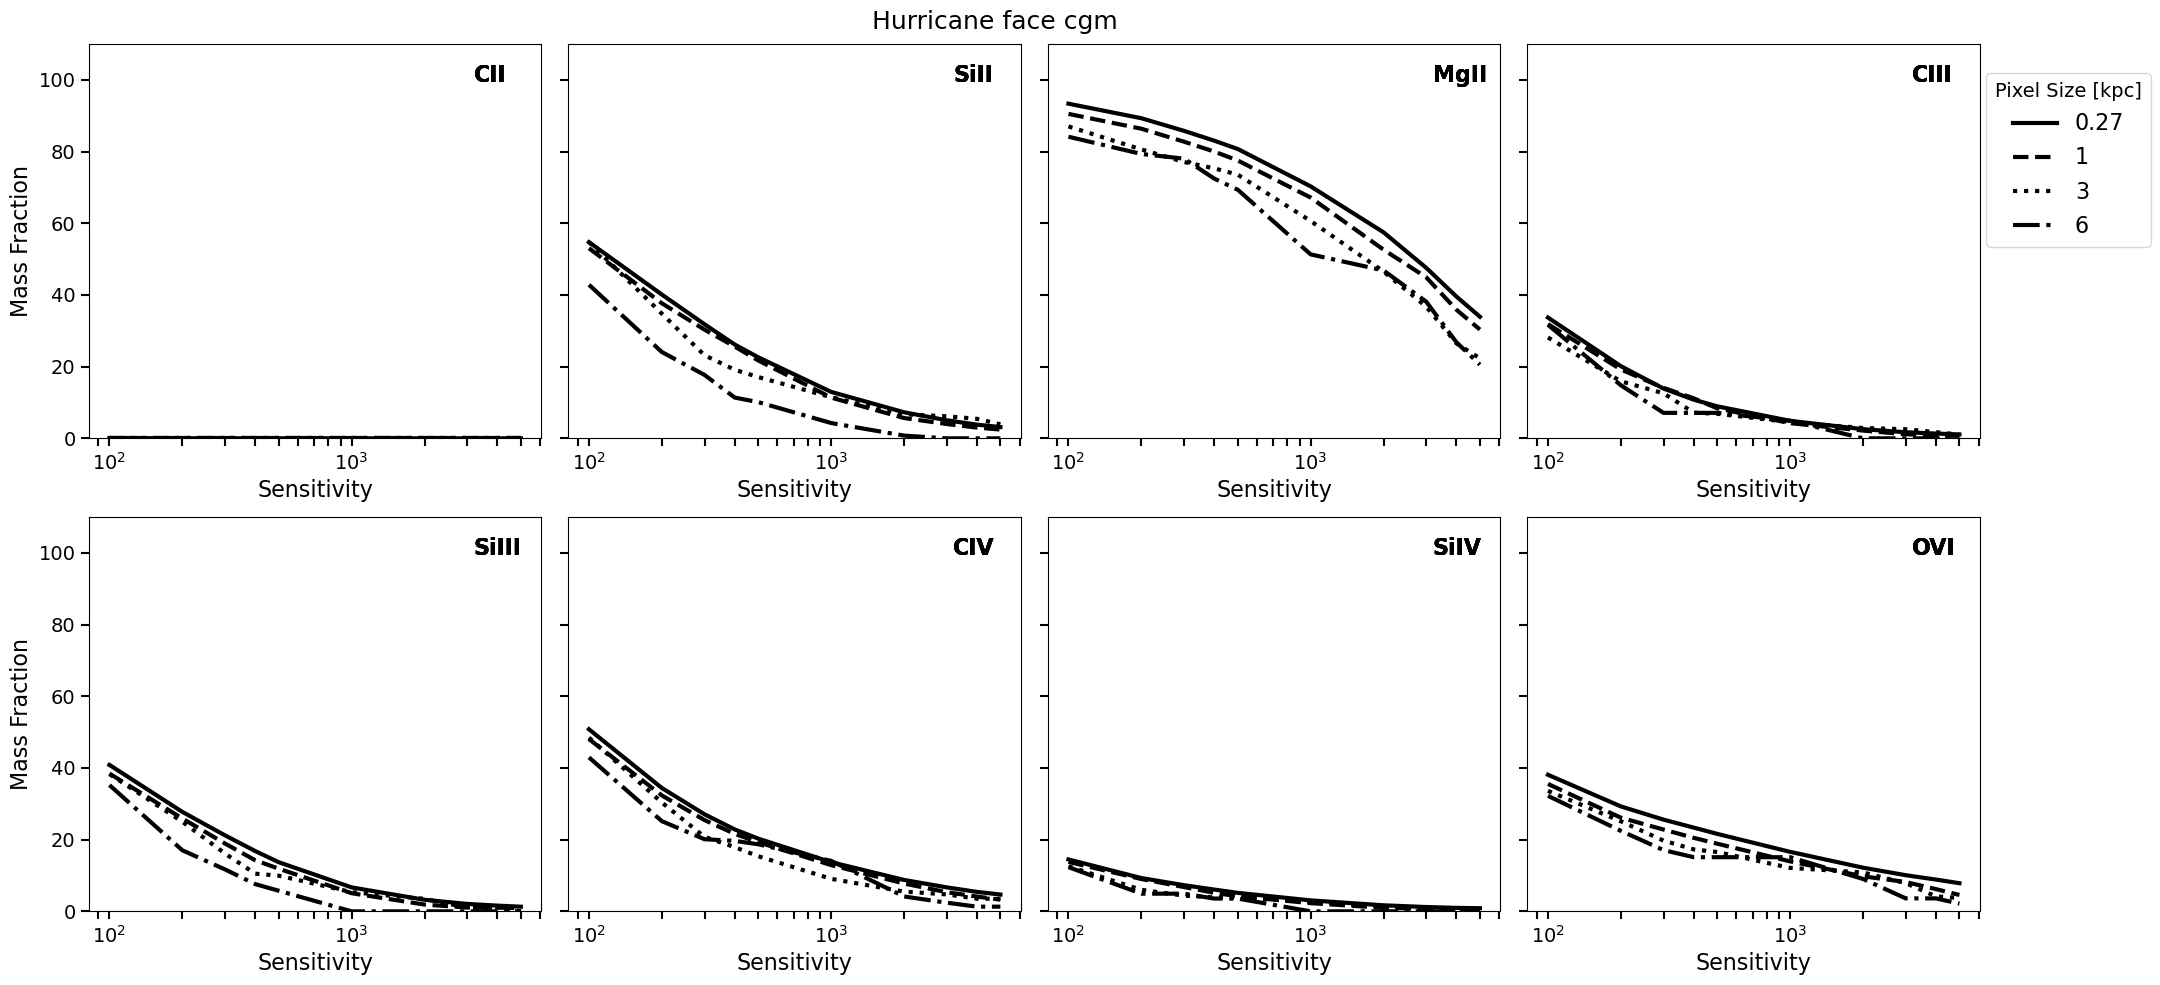

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Blizzard_face_on_cgm_by_ion_reslines.png


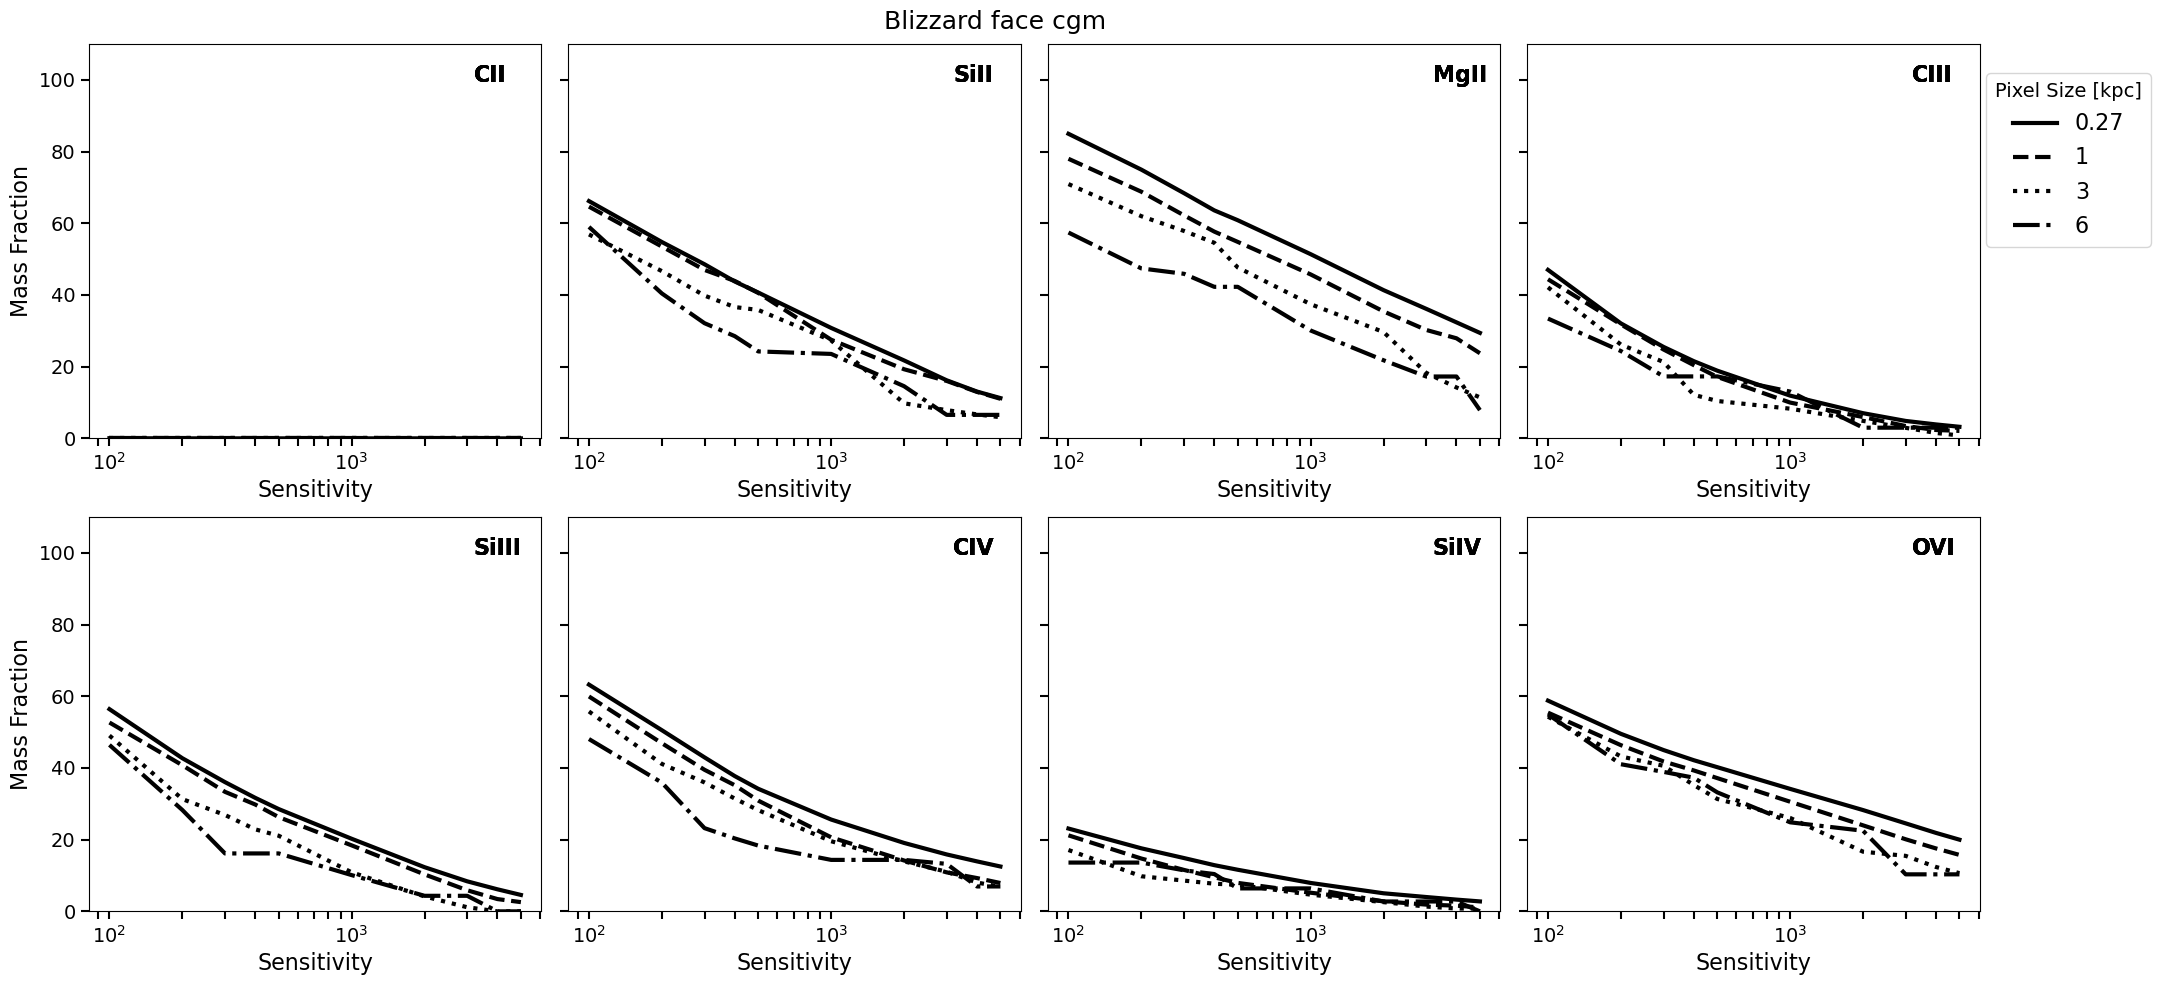

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Squall_face_on_cgm_by_ion_reslines.png


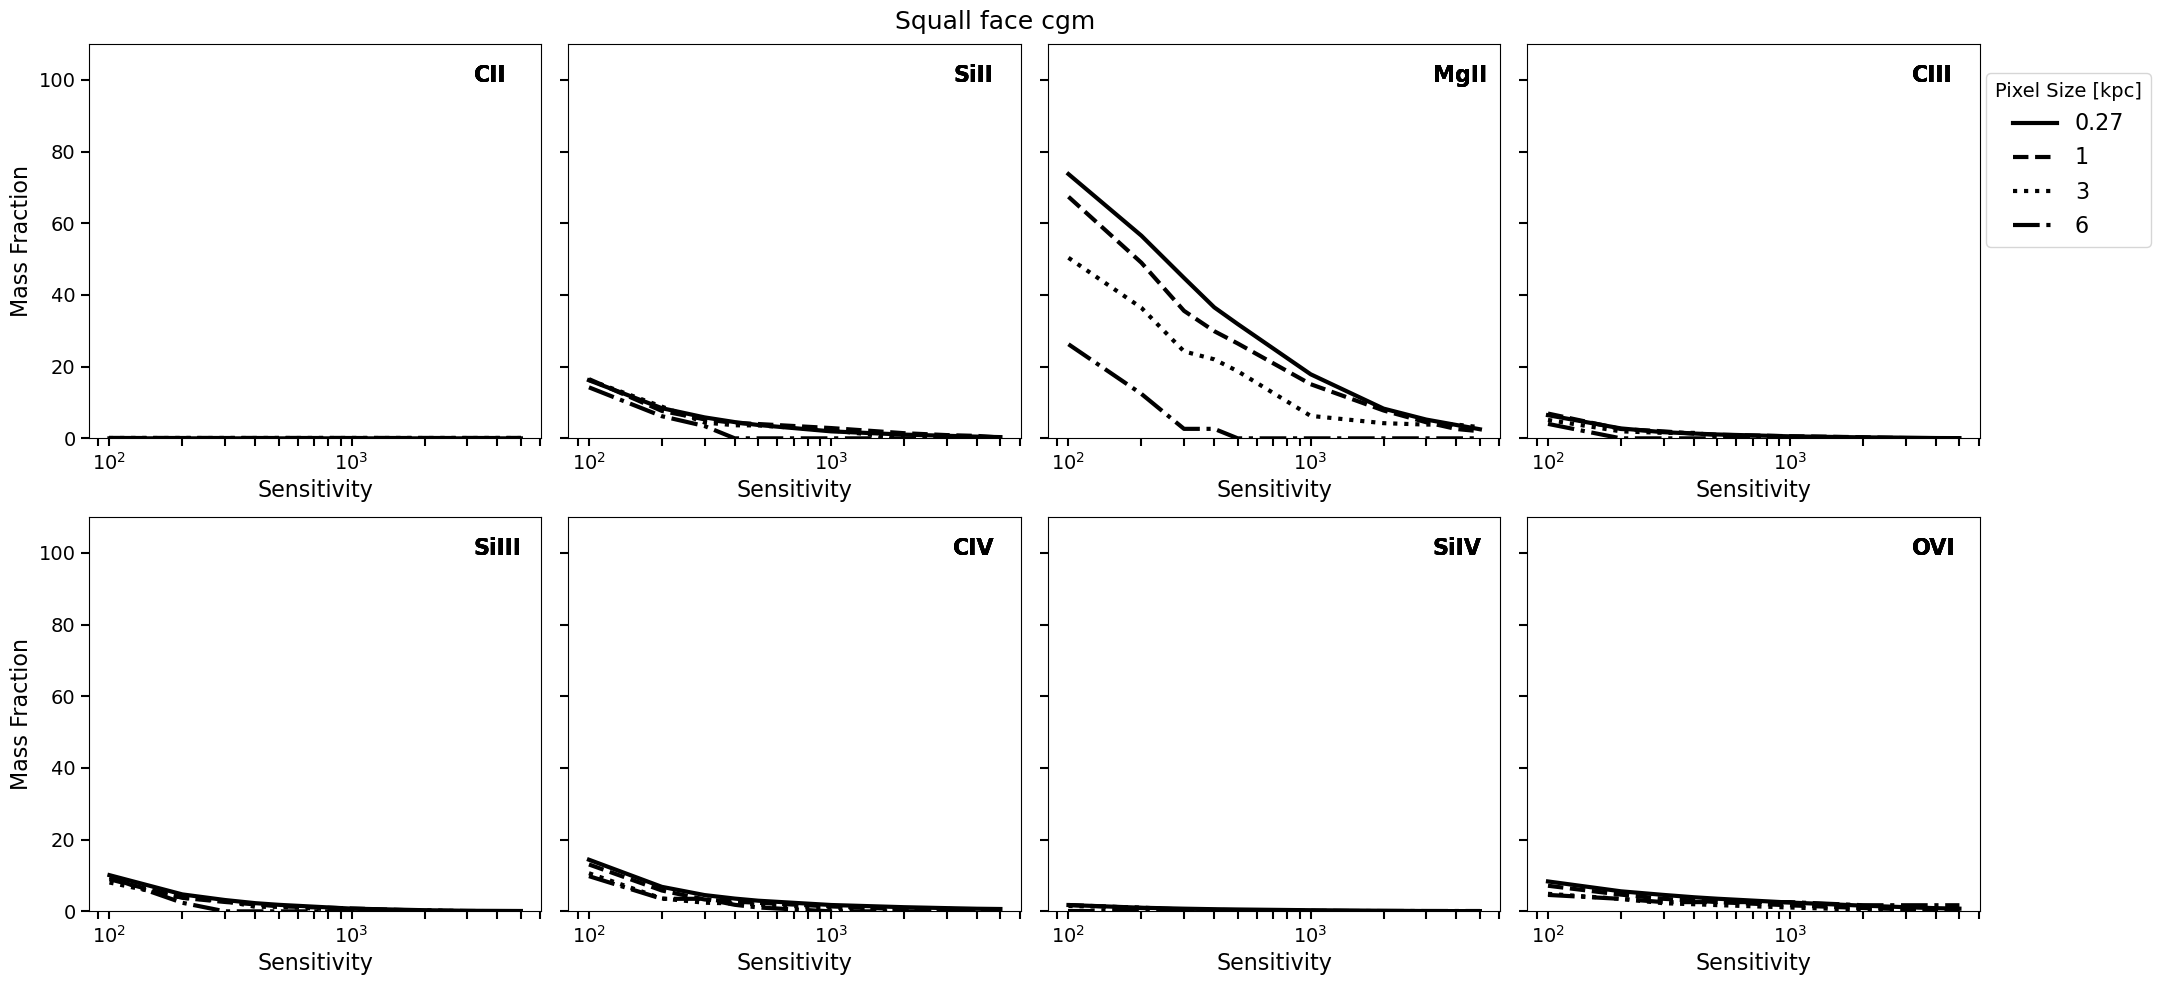

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Maelstrom_face_on_cgm_by_ion_reslines.png


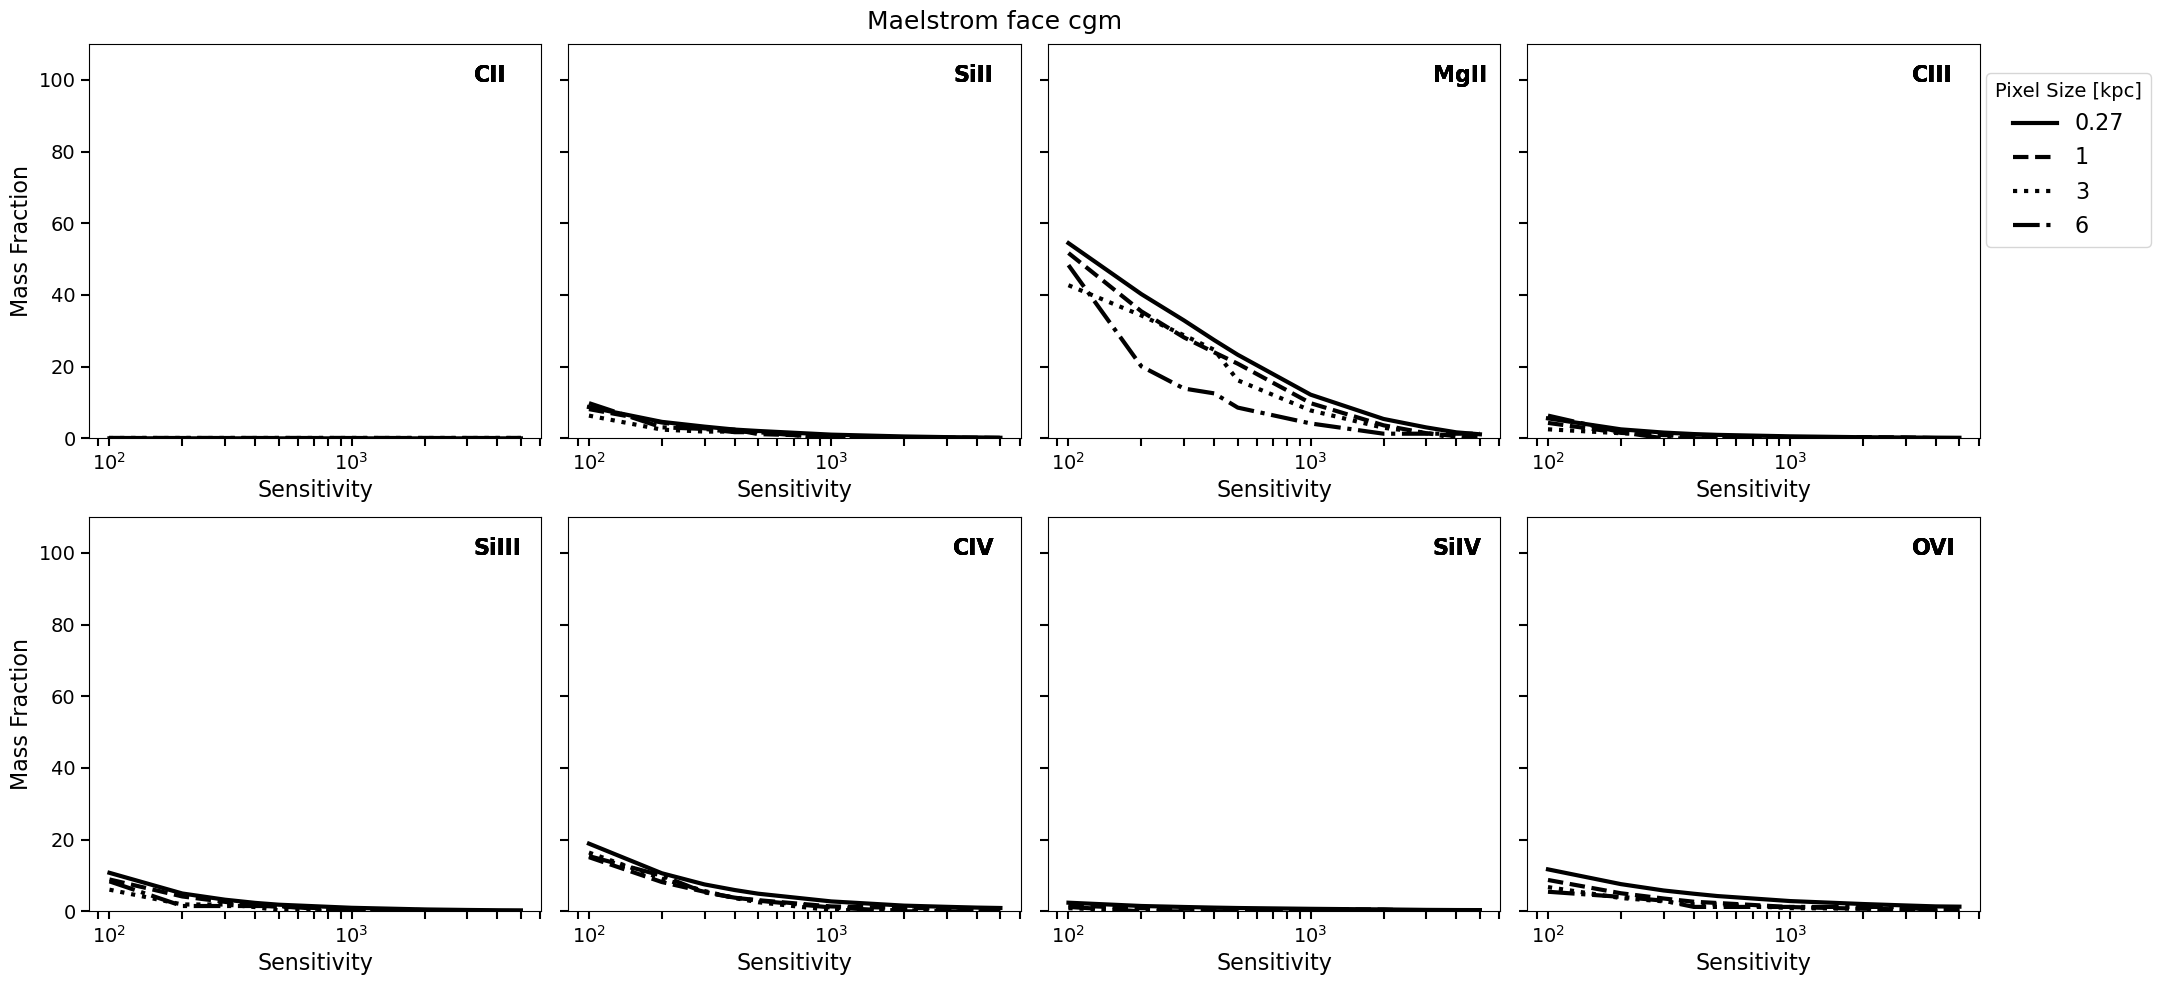

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Tempest_face_on_cgm_by_ion_reslines.png


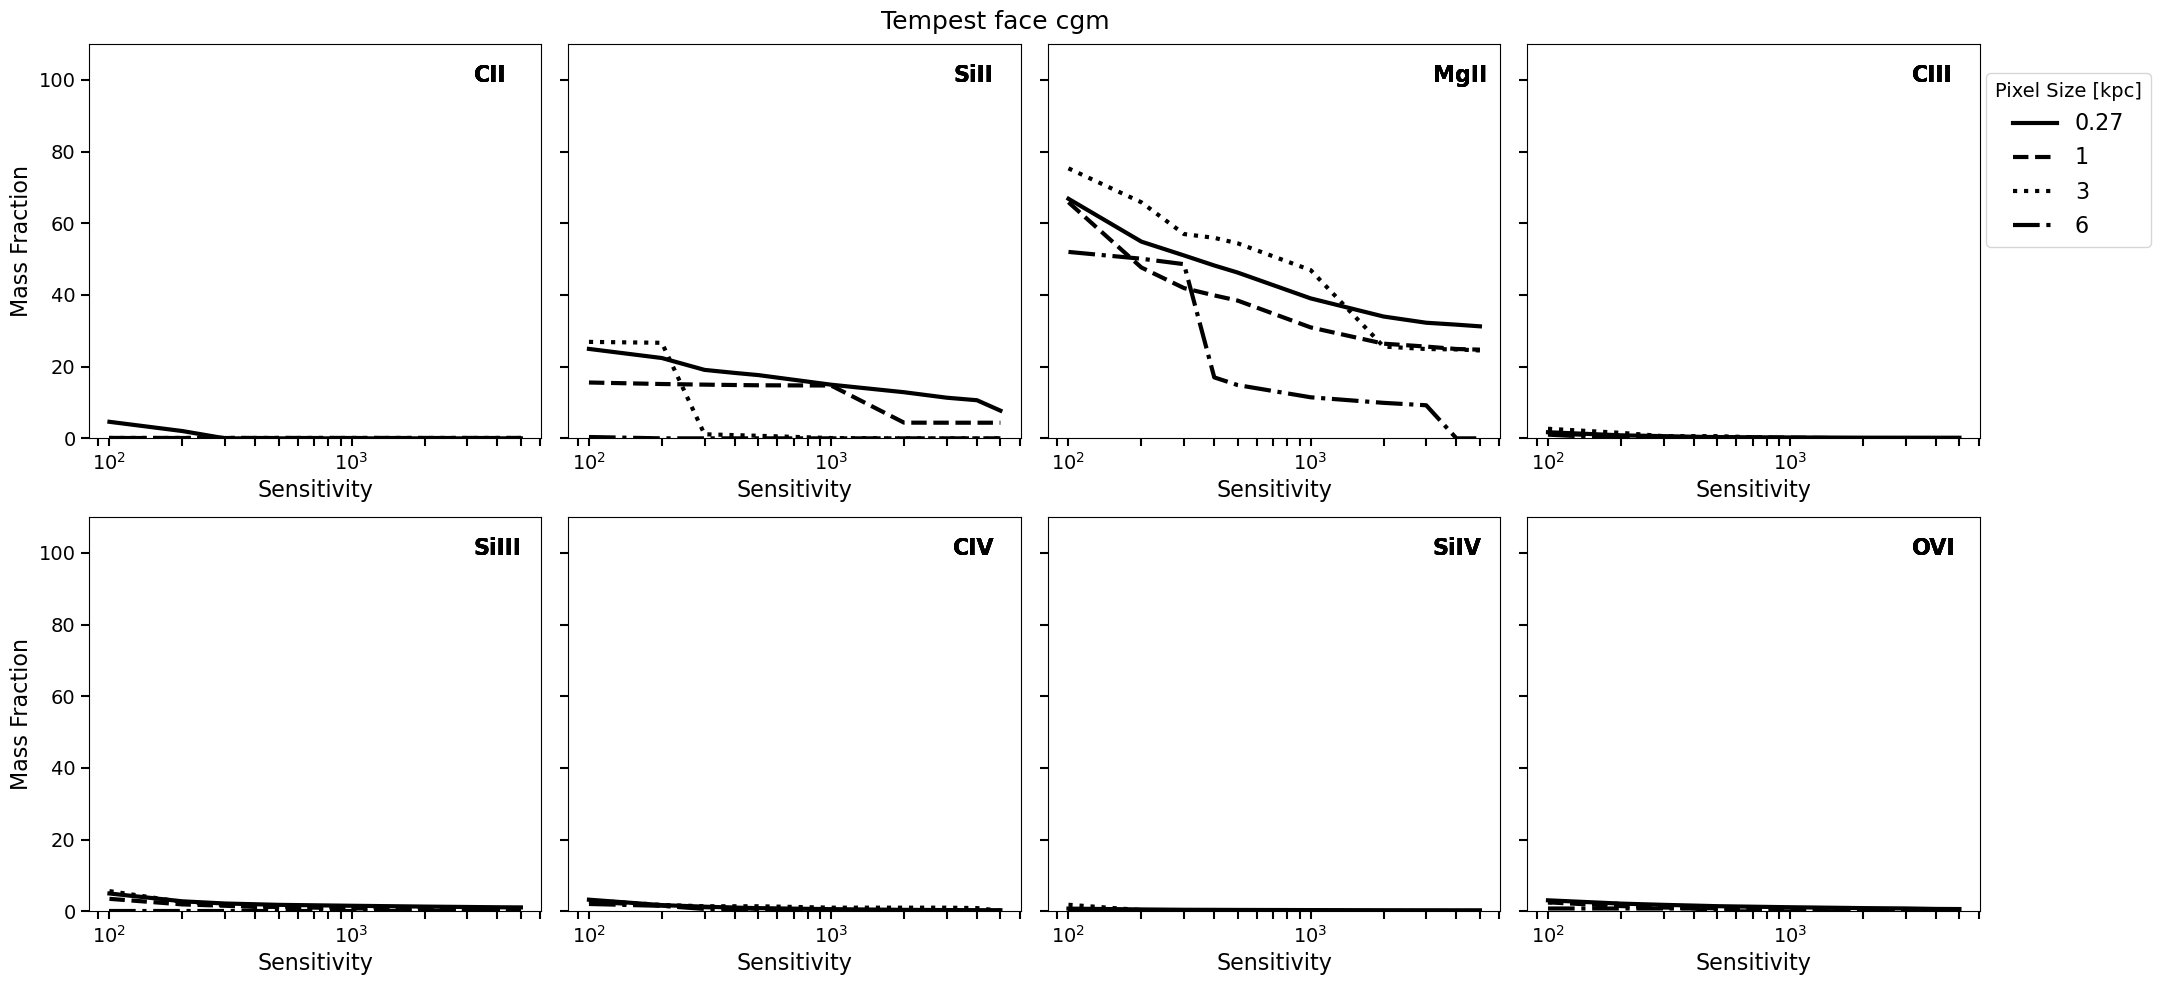

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Cyclone_edge_on_cgm_by_ion_reslines.png


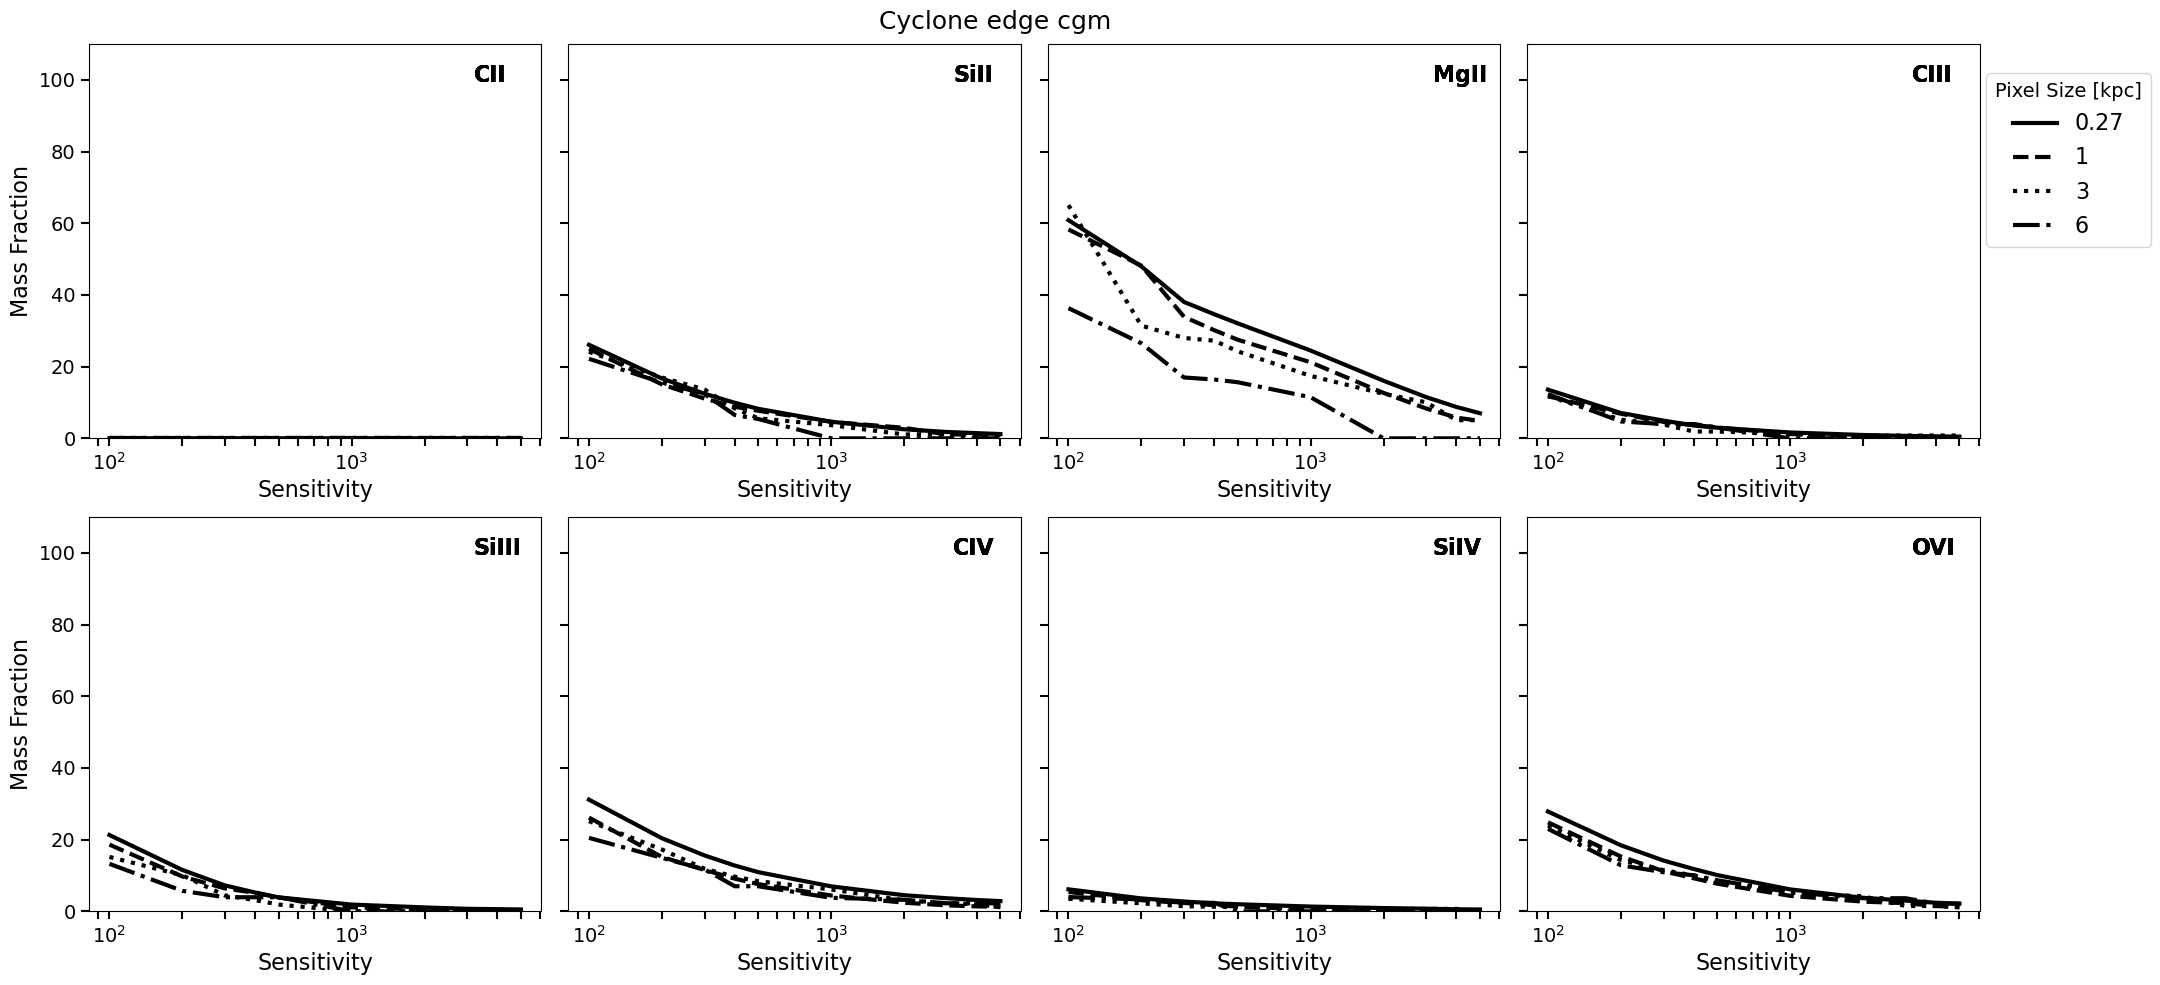

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Hurricane_edge_on_cgm_by_ion_reslines.png


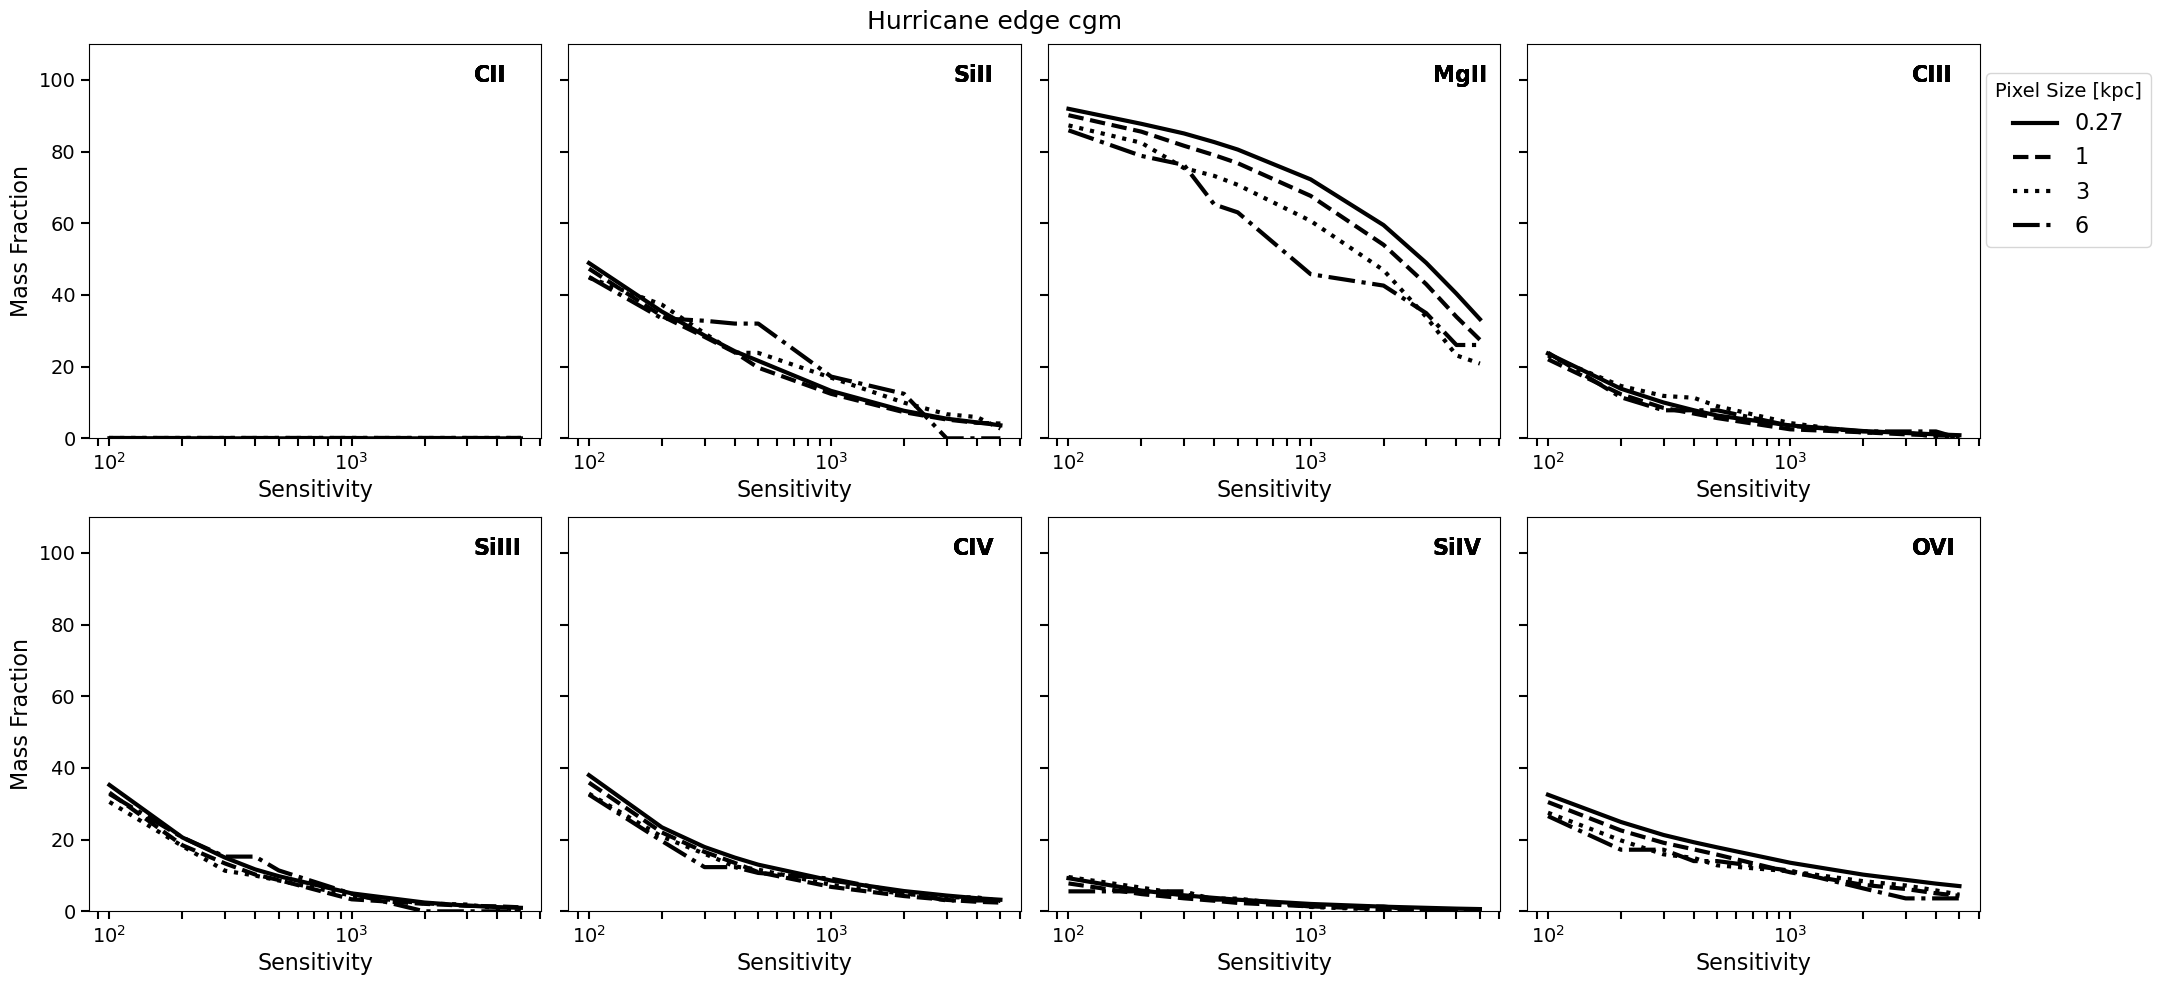

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Blizzard_edge_on_cgm_by_ion_reslines.png


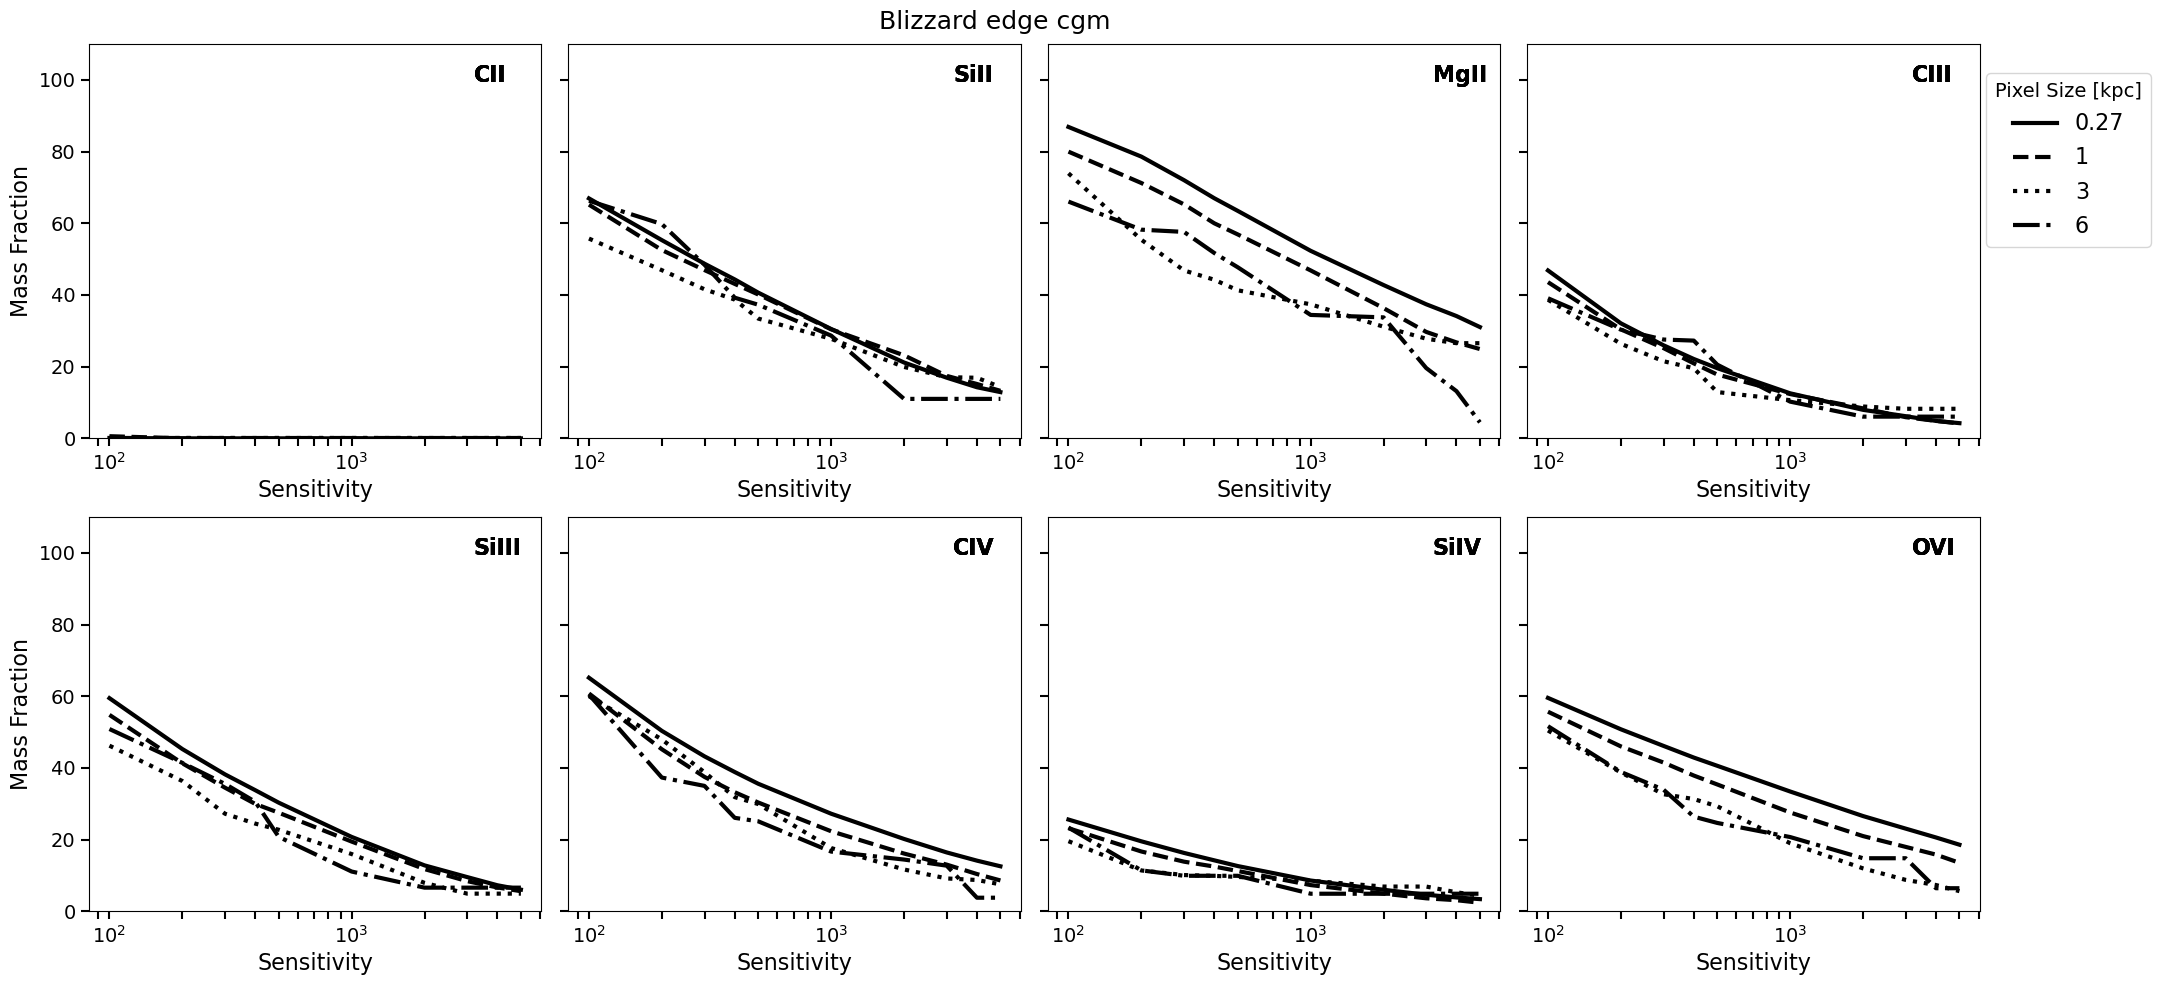

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Squall_edge_on_cgm_by_ion_reslines.png


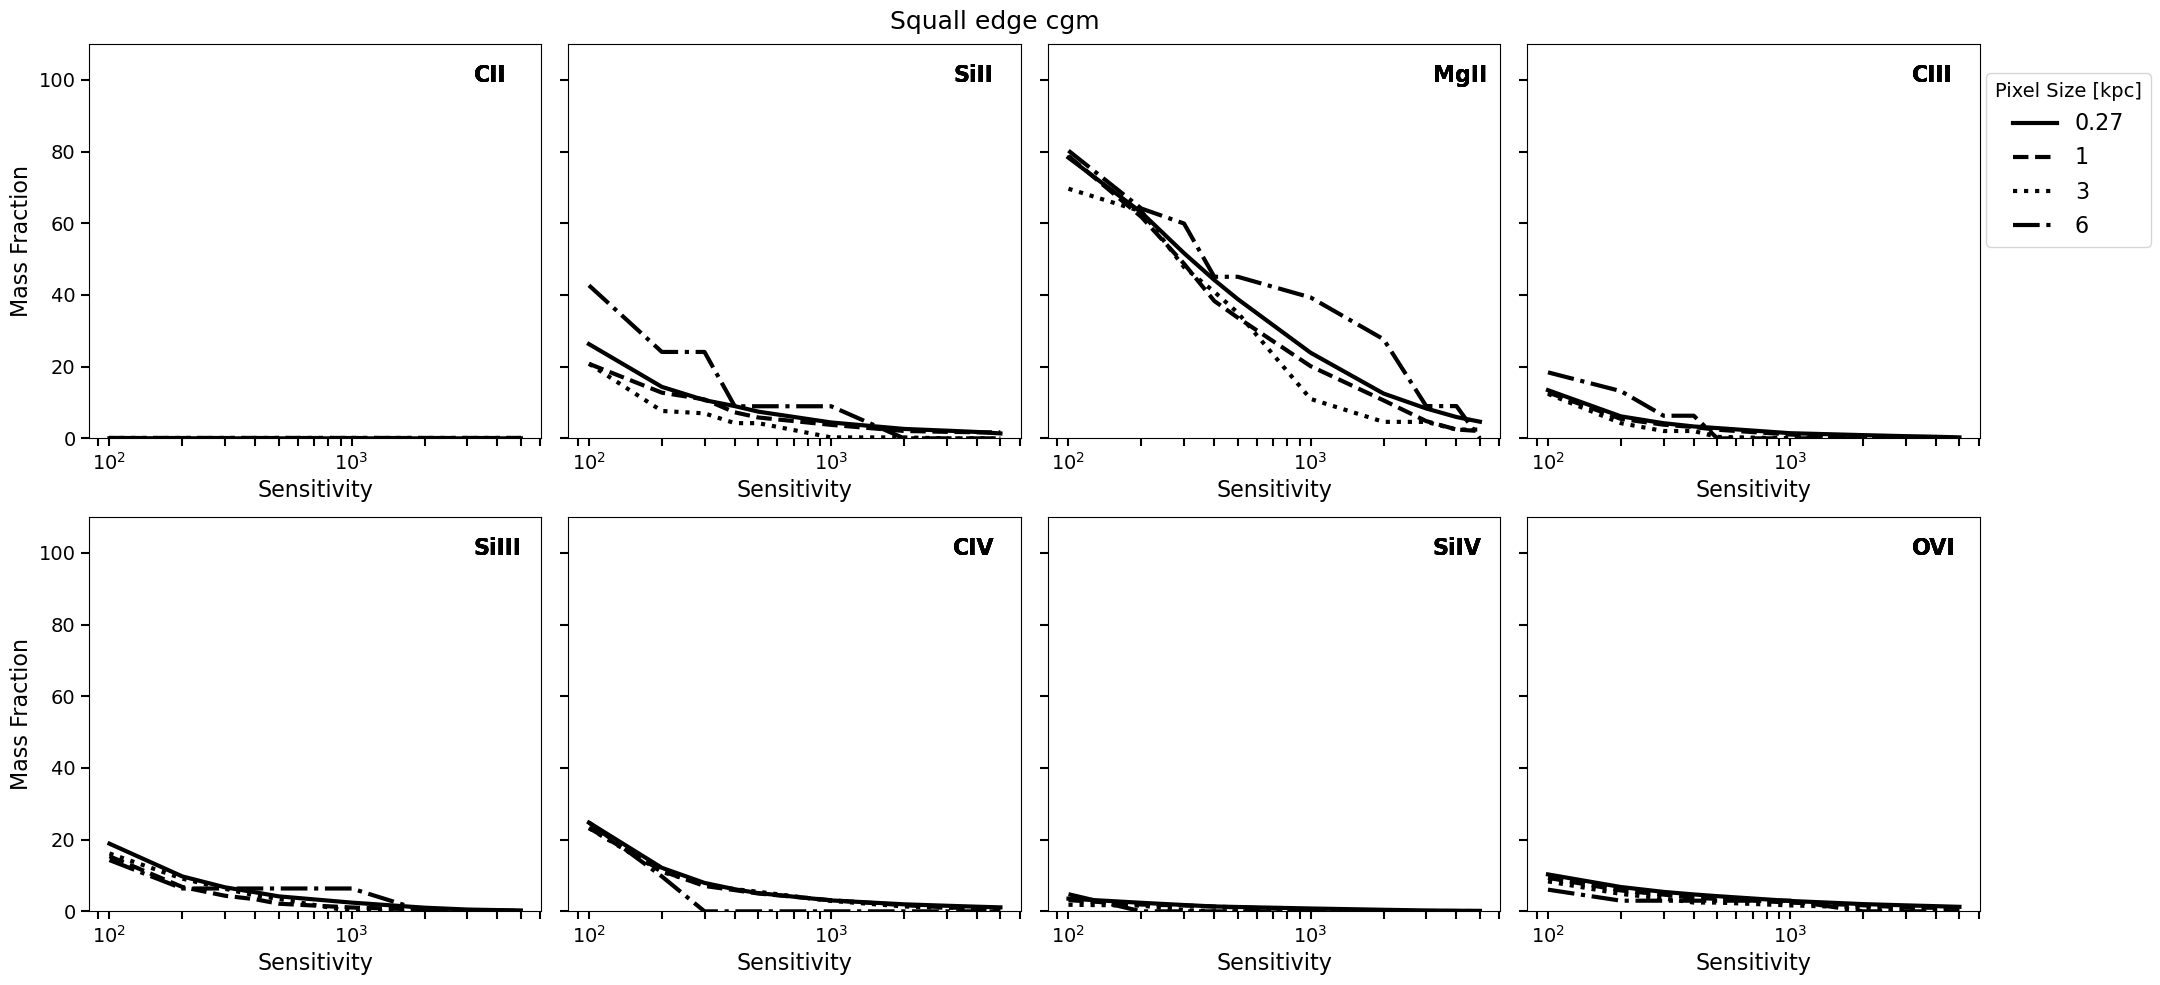

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Maelstrom_edge_on_cgm_by_ion_reslines.png


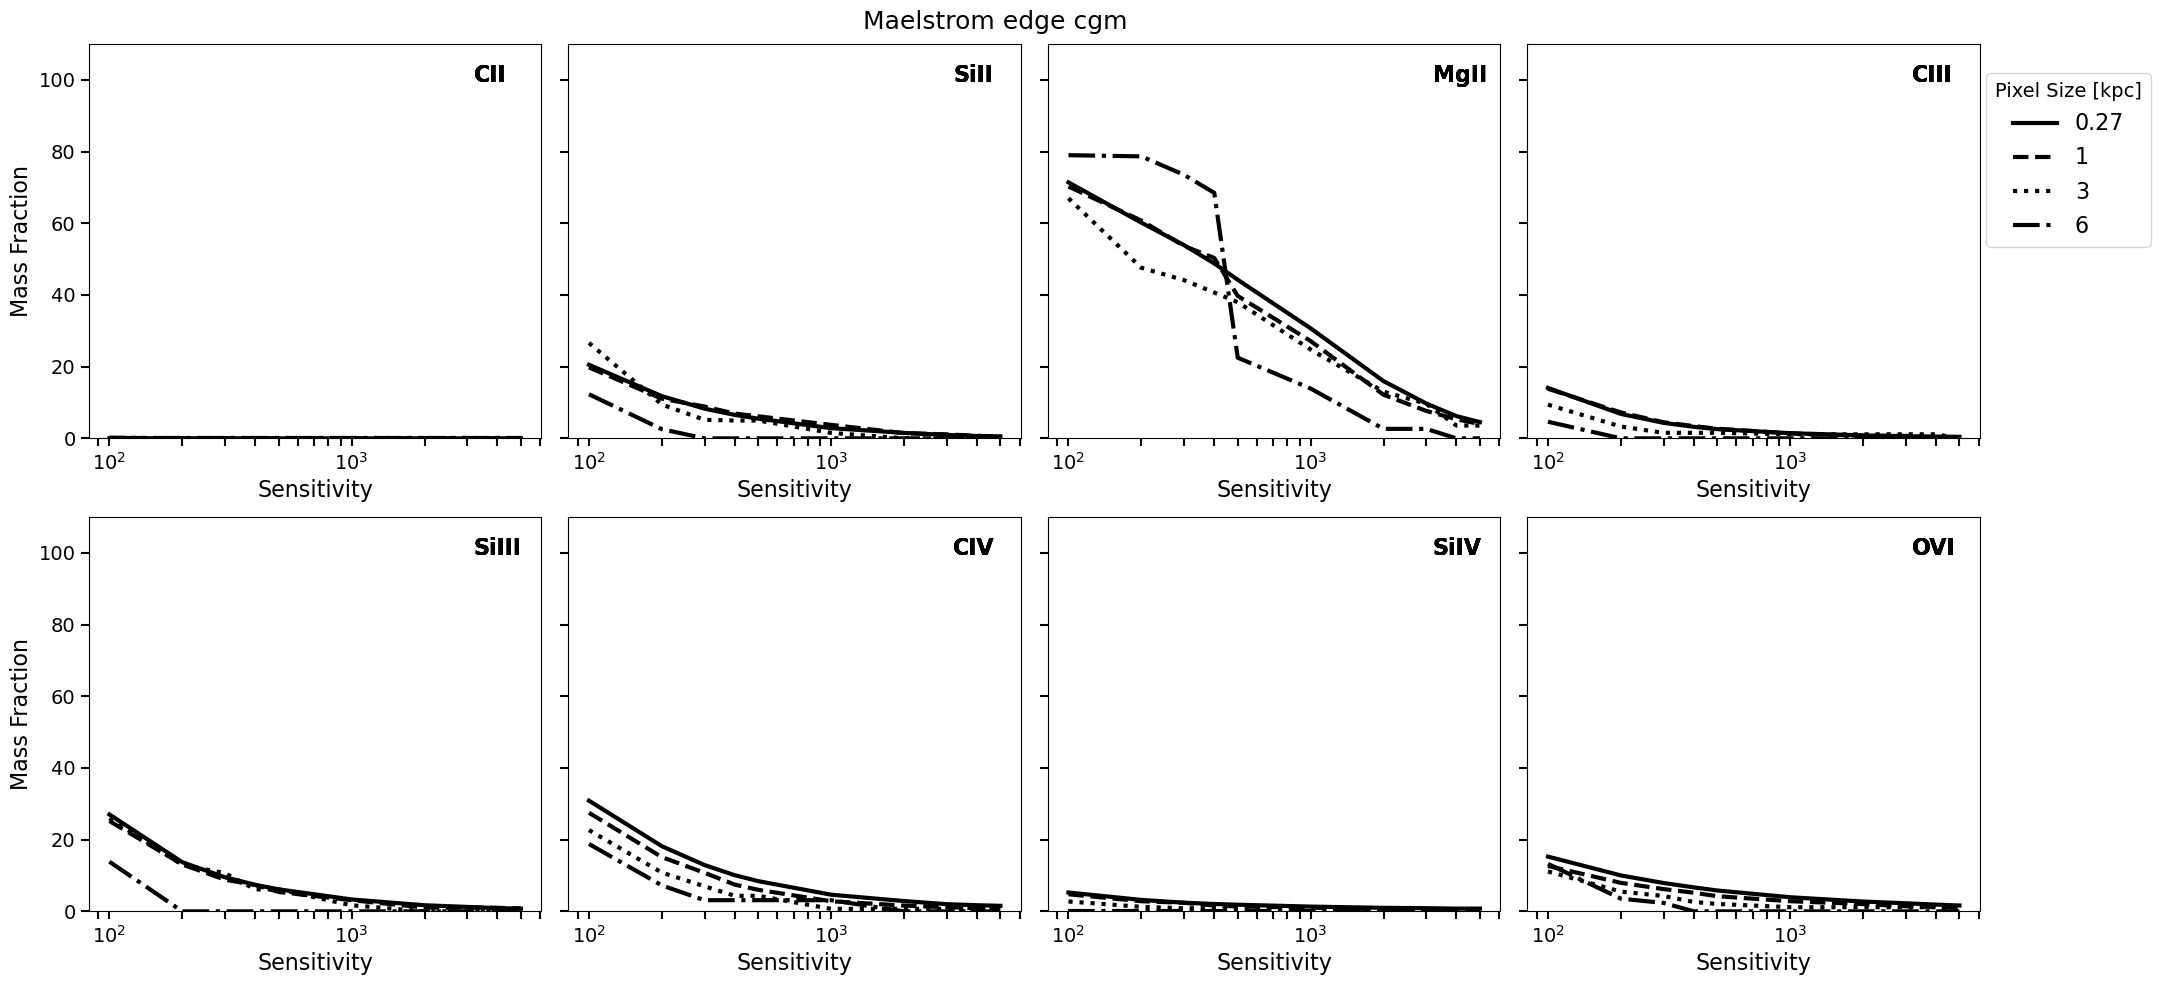

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_Tempest_edge_on_cgm_by_ion_reslines.png


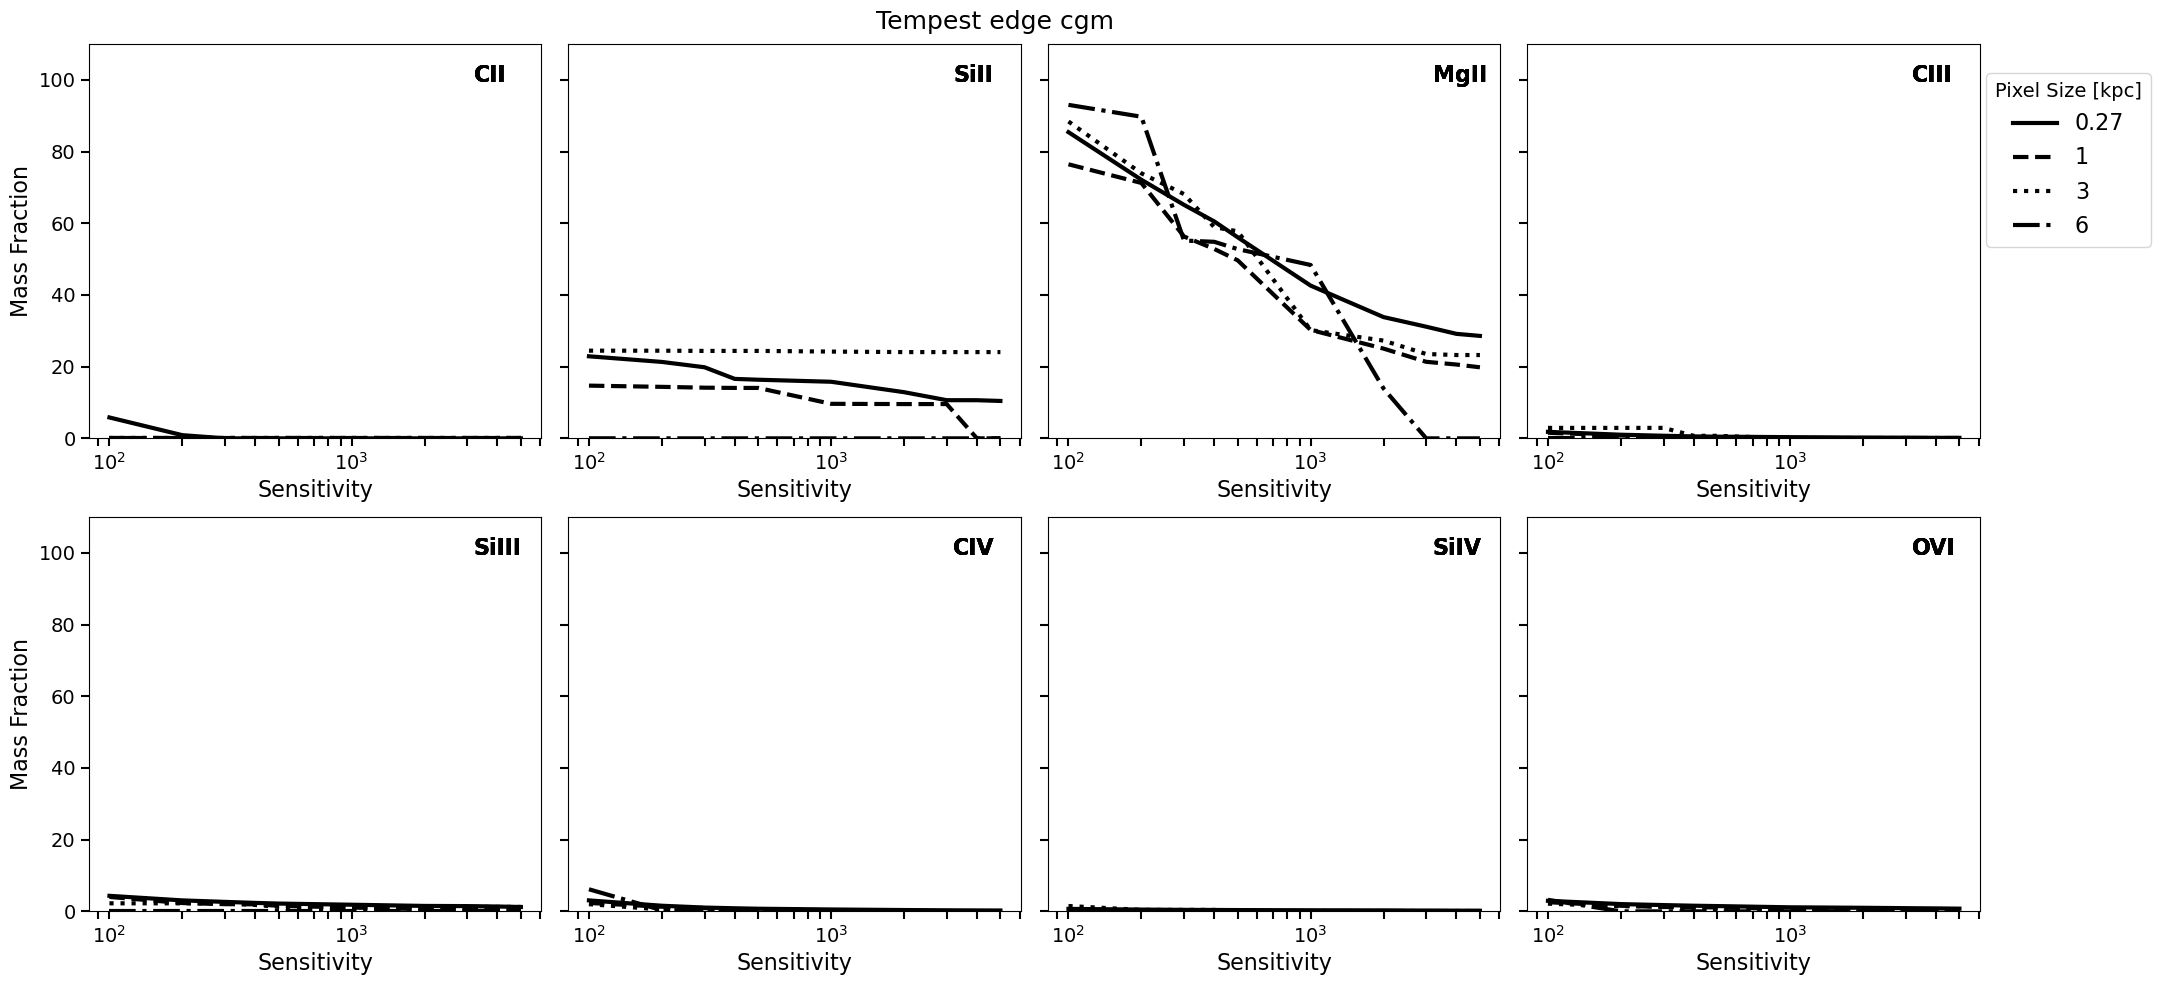

In [3]:
line_styles = ['-', '--', ':', '-.']  # Add more styles if needed
heatmap_data = {}
for orientation in orientations:
    for halo in halos:
        for region in regions:
            fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
            axs = axs.flatten()  # Make it easier to index over
            if len(ions) == 1:
                axs = [axs]  # Ensure iterable if only 1 ion

            halo_name = halo_dict[halo]
            for res_idx, resolution in enumerate(resolutions):
                foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                if regions == ['all']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
                elif regions == ['cgm']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                save_path = os.path.join(prefix, 'FRBs')
                file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                for ion_idx, ion in enumerate(ions):
                    with h5py.File(file_path, 'r') as f:
                        spatial_res = f[f'z={z}'].attrs['FRB_pixel_size_kpc']
                        mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                        emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                    total_mass = mass_data.sum()
                    all_fraction = []
                    for thresh in flux_thresholds[ion]:
                        above_id = np.where(emission_data >= thresh)
                        mass_above = mass_data[above_id].sum()
                        frac = (mass_above / total_mass) * 100
                        all_fraction.append(frac)
                        heatmap_data.setdefault((halo, orientation, ion, region), []).append((spatial_res, thresh, frac))

                    key = (halo, orientation, ion, region)
                    data = heatmap_data[key]

                    ax = axs[ion_idx]
                    color = cmap(ions.index(ion))
                    line_style = line_styles[res_idx % len(line_styles)]

                    # Plot the data
                    ax.plot(flux_thresholds[ion], all_fraction, label=f'{resolution}', linestyle=line_style, color='k', linewidth=3)

                    # Add ion name inside panel
                    ax.text(0.85, 0.95, ion, transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left', va='top')

                    # Set axis scale, limits, and labels
                    ax.set_ylim(0, 110)
                    ax.set_xscale('log')
                    if ion_idx == 0 or ion_idx == 4:
                        ax.set_ylabel('Mass Fraction', fontsize=16)
                    ax.set_xlabel('Sensitivity', fontsize=16)

                    # Increase tick label sizes
                    ax.tick_params(axis='both', which='both', labelsize=14, width=1.5, length=6)

            # Legend outside the plot
            handles, labels = axs[-1].get_legend_handles_labels()
            fig.legend(handles, labels, title='Pixel Size [kpc]', loc='center left', bbox_to_anchor=(0.99, 0.83), fontsize=16, title_fontsize=14)

            fig.suptitle(f'{halo_name} {orientation} {region}', fontsize=18)
            plt.tight_layout()

            output_file = os.path.join(output_dir,'All_halos','allhalos_massfrac_sensitivity_plots', f'z{z}_{halo_name}_{orientation}_on_{region}_by_ion_reslines.png')
            print(f'Saving figure to {output_file}')

            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            plt.show()
            plt.close(fig)


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_39188/2702773992.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  halo_cmap = mtcm.get_cmap('tab10', len(halos))


Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_face_on_cgm_massfrac_vs_sensitivity.png


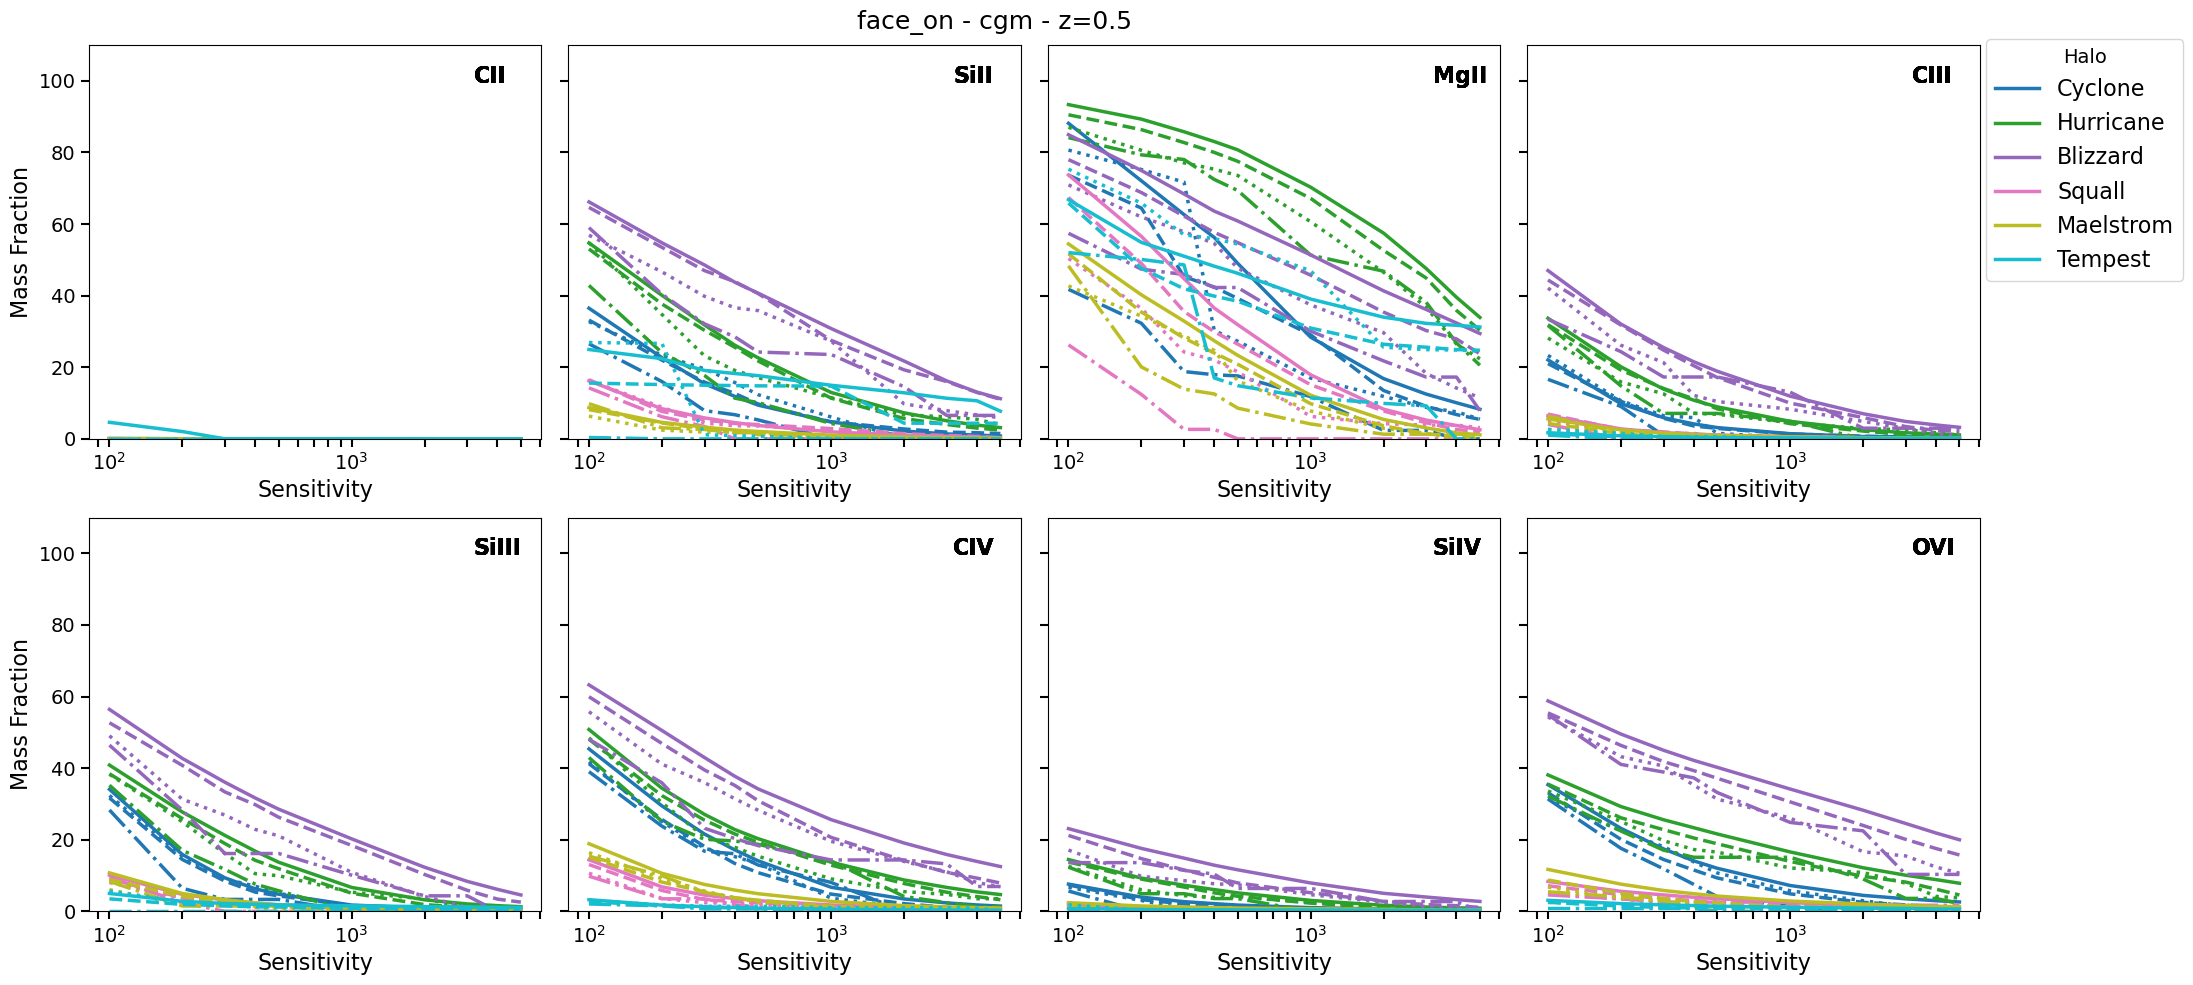

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_edge_on_cgm_massfrac_vs_sensitivity.png


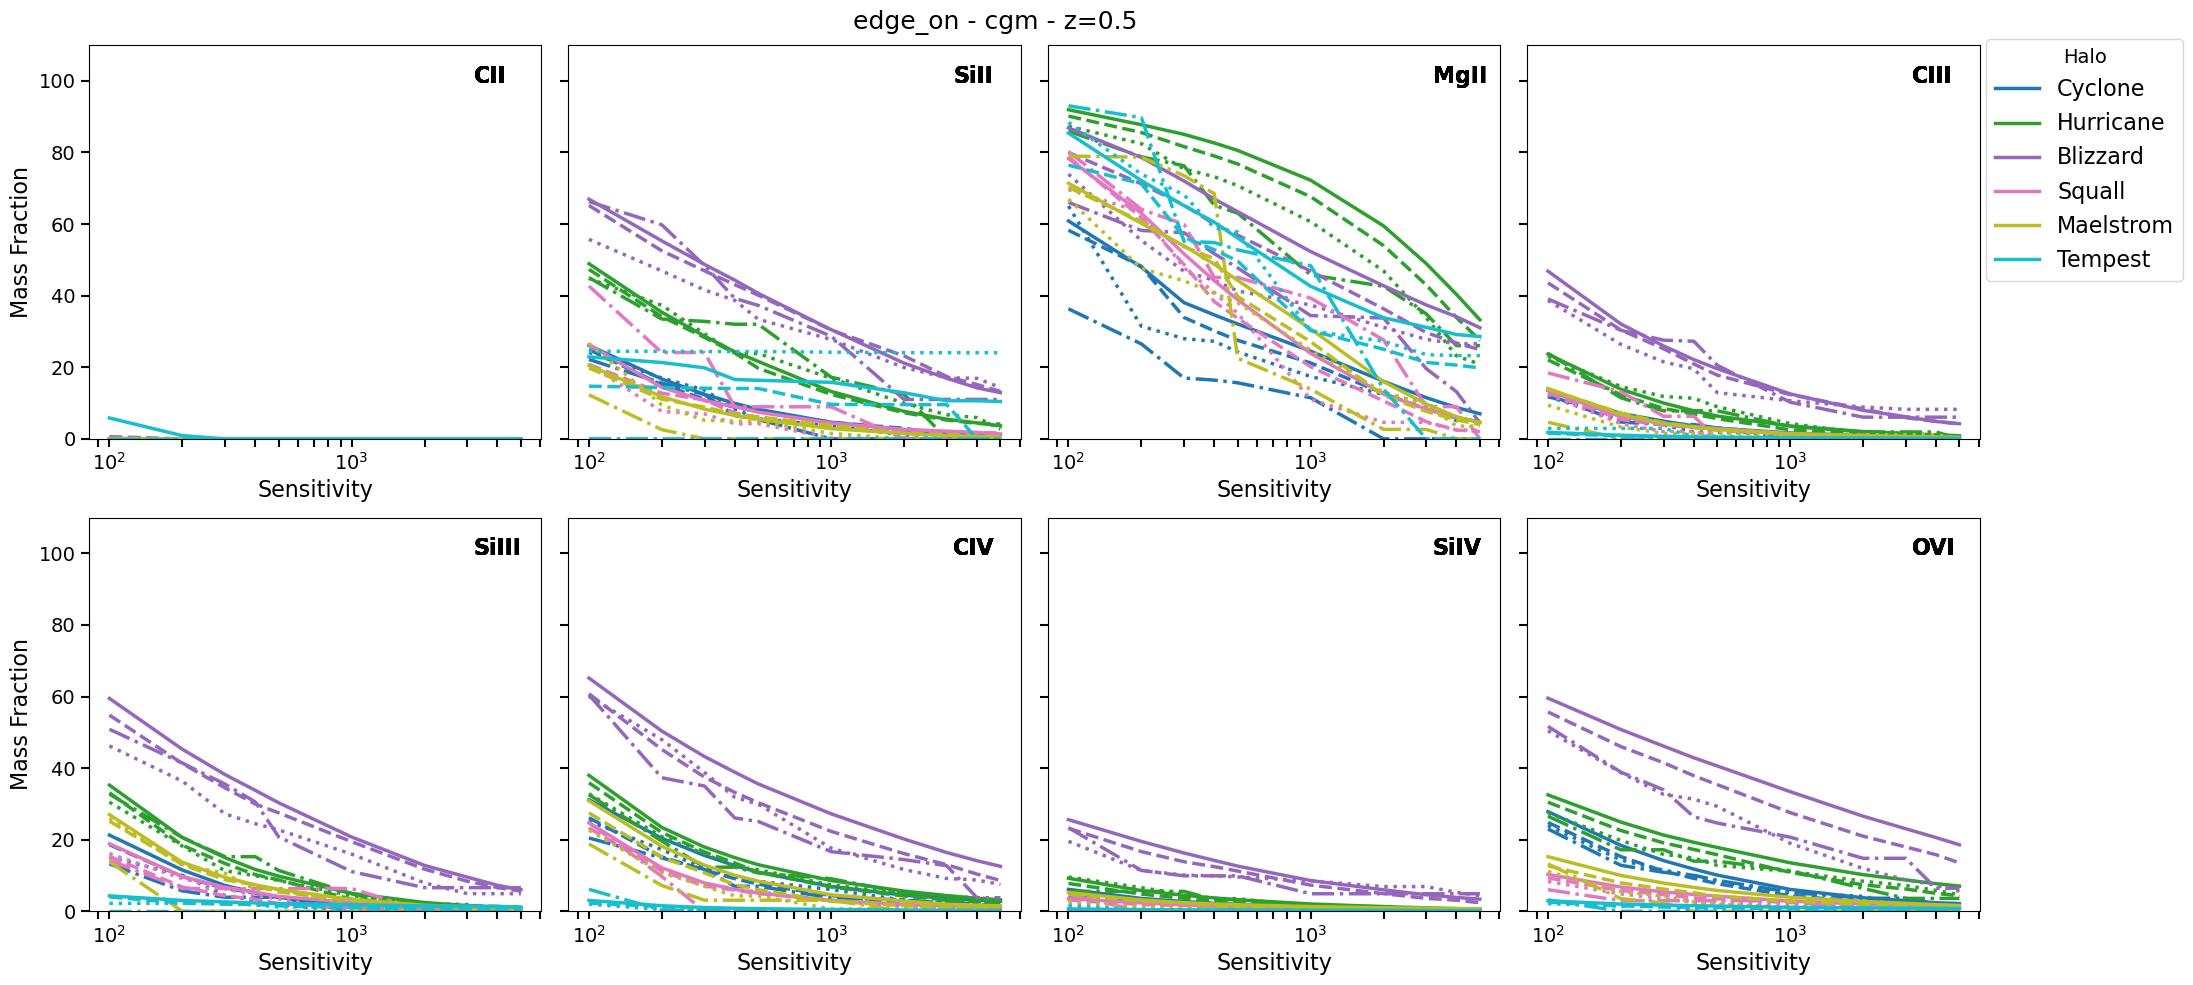

In [4]:
line_styles = ['-', '--', ':', '-.']  # Add more styles if needed
halo_cmap = mtcm.get_cmap('tab10', len(halos))

for orientation in orientations:
    for region in regions:
        fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
        axs = axs.flatten()
        if len(ions) == 1:
            axs = [axs]

        for halo_idx, halo in enumerate(halos):
            color = halo_cmap(halo_idx)
            halo_name = halo_dict[halo]

            for res_idx, resolution in enumerate(resolutions):
                foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                if regions == ['all']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
                elif regions == ['cgm']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                save_path = os.path.join(prefix, 'FRBs')
                file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                for ion_idx, ion in enumerate(ions):
                    with h5py.File(file_path, 'r') as f:
                        spatial_res = f[f'z={z}'].attrs['FRB_pixel_size_kpc']
                        mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                        emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                    total_mass = mass_data.sum()
                    all_fraction = []
                    for thresh in flux_thresholds[ion]:
                        above_id = np.where(emission_data >= thresh)
                        mass_above = mass_data[above_id].sum()
                        frac = (mass_above / total_mass) * 100
                        all_fraction.append(frac)
                        heatmap_data.setdefault((halo, orientation, ion, region), []).append((spatial_res, thresh, frac))

                    key = (halo, orientation, ion, region)
                    data = heatmap_data[key]

                    ax = axs[ion_idx]
                    line_style = line_styles[res_idx % len(line_styles)]

                    ax.plot(
                        flux_thresholds[ion],
                        all_fraction,
                        label=f'{halo_name}' if res_idx == 0 else "",  # Only add halo name once
                        linestyle=line_style,
                        color=color,
                        linewidth=2.5,
                        alpha=1,
                    )

                    # Add ion label inside each panel
                    if res_idx == 0:
                        ax.text(0.85, 0.95, ion, transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left', va='top')

                    ax.set_ylim(0, 110)
                    #ax.set_xlim(100, 5000)
                    ax.set_xscale('log')
                    if ion_idx == 0 or ion_idx == 4:
                        ax.set_ylabel('Mass Fraction', fontsize=16)
                    ax.set_xlabel('Sensitivity', fontsize=16)
                    ax.tick_params(axis='both', which='both', labelsize=14, width=1.5, length=6)

        # Add legend outside plot
        handles, labels = axs[-1].get_legend_handles_labels()
        fig.legend(handles, labels, title='Halo', loc='center left', bbox_to_anchor=(0.99, 0.83), fontsize=16, title_fontsize=14)

        fig.suptitle(f'{orientation}_on - {region} - z={z}', fontsize=18)
        plt.tight_layout()

        output_file = os.path.join(output_dir,'All_halos','allhalos_massfrac_sensitivity_plots', f'z{z}_{orientation}_on_{region}_massfrac_vs_sensitivity.png')
        print(f'Saving figure to {output_file}')

        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_39188/2752683408.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  halo_cmap = mtcm.get_cmap('tab10', len(halos))


Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_face_on_cgm_massfrac_vs_sensitivity_zoom.png


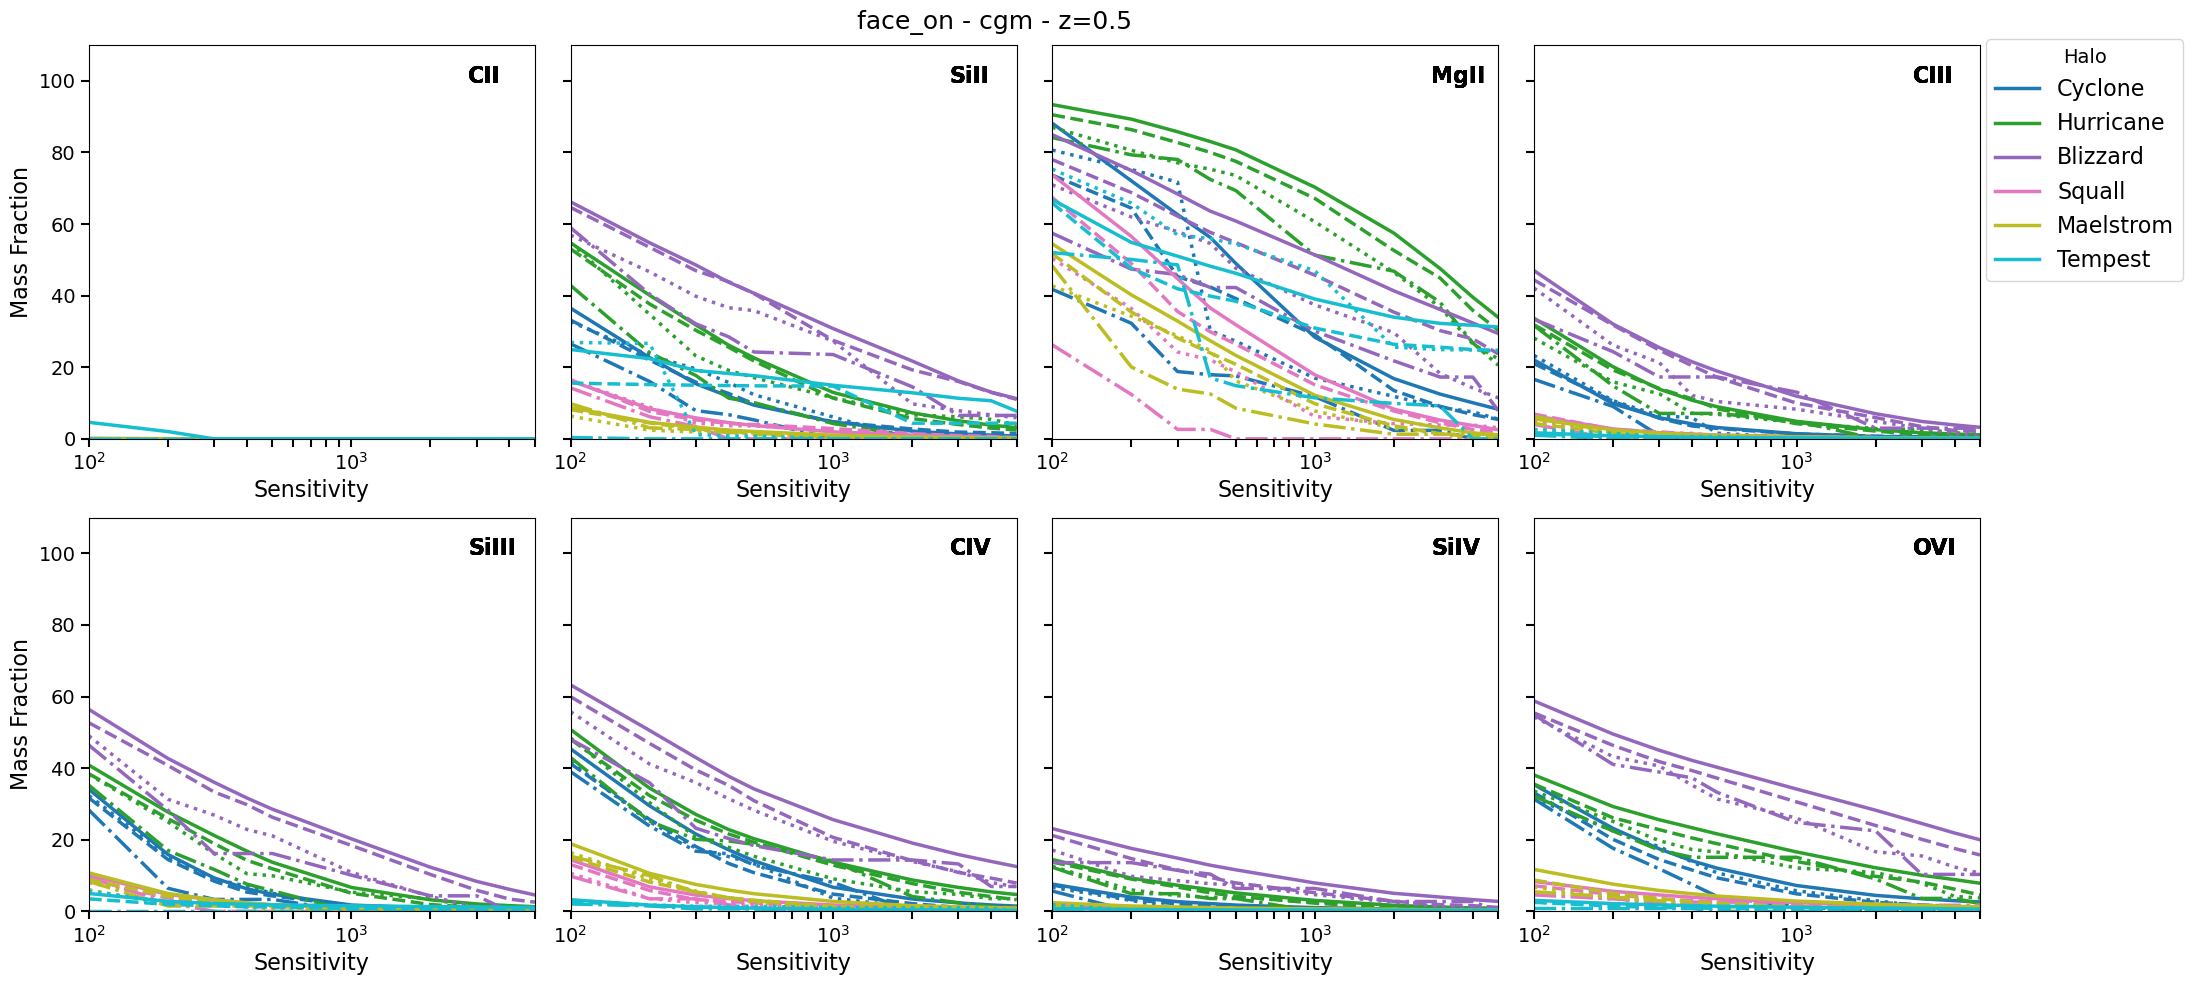

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/z0.5_edge_on_cgm_massfrac_vs_sensitivity_zoom.png


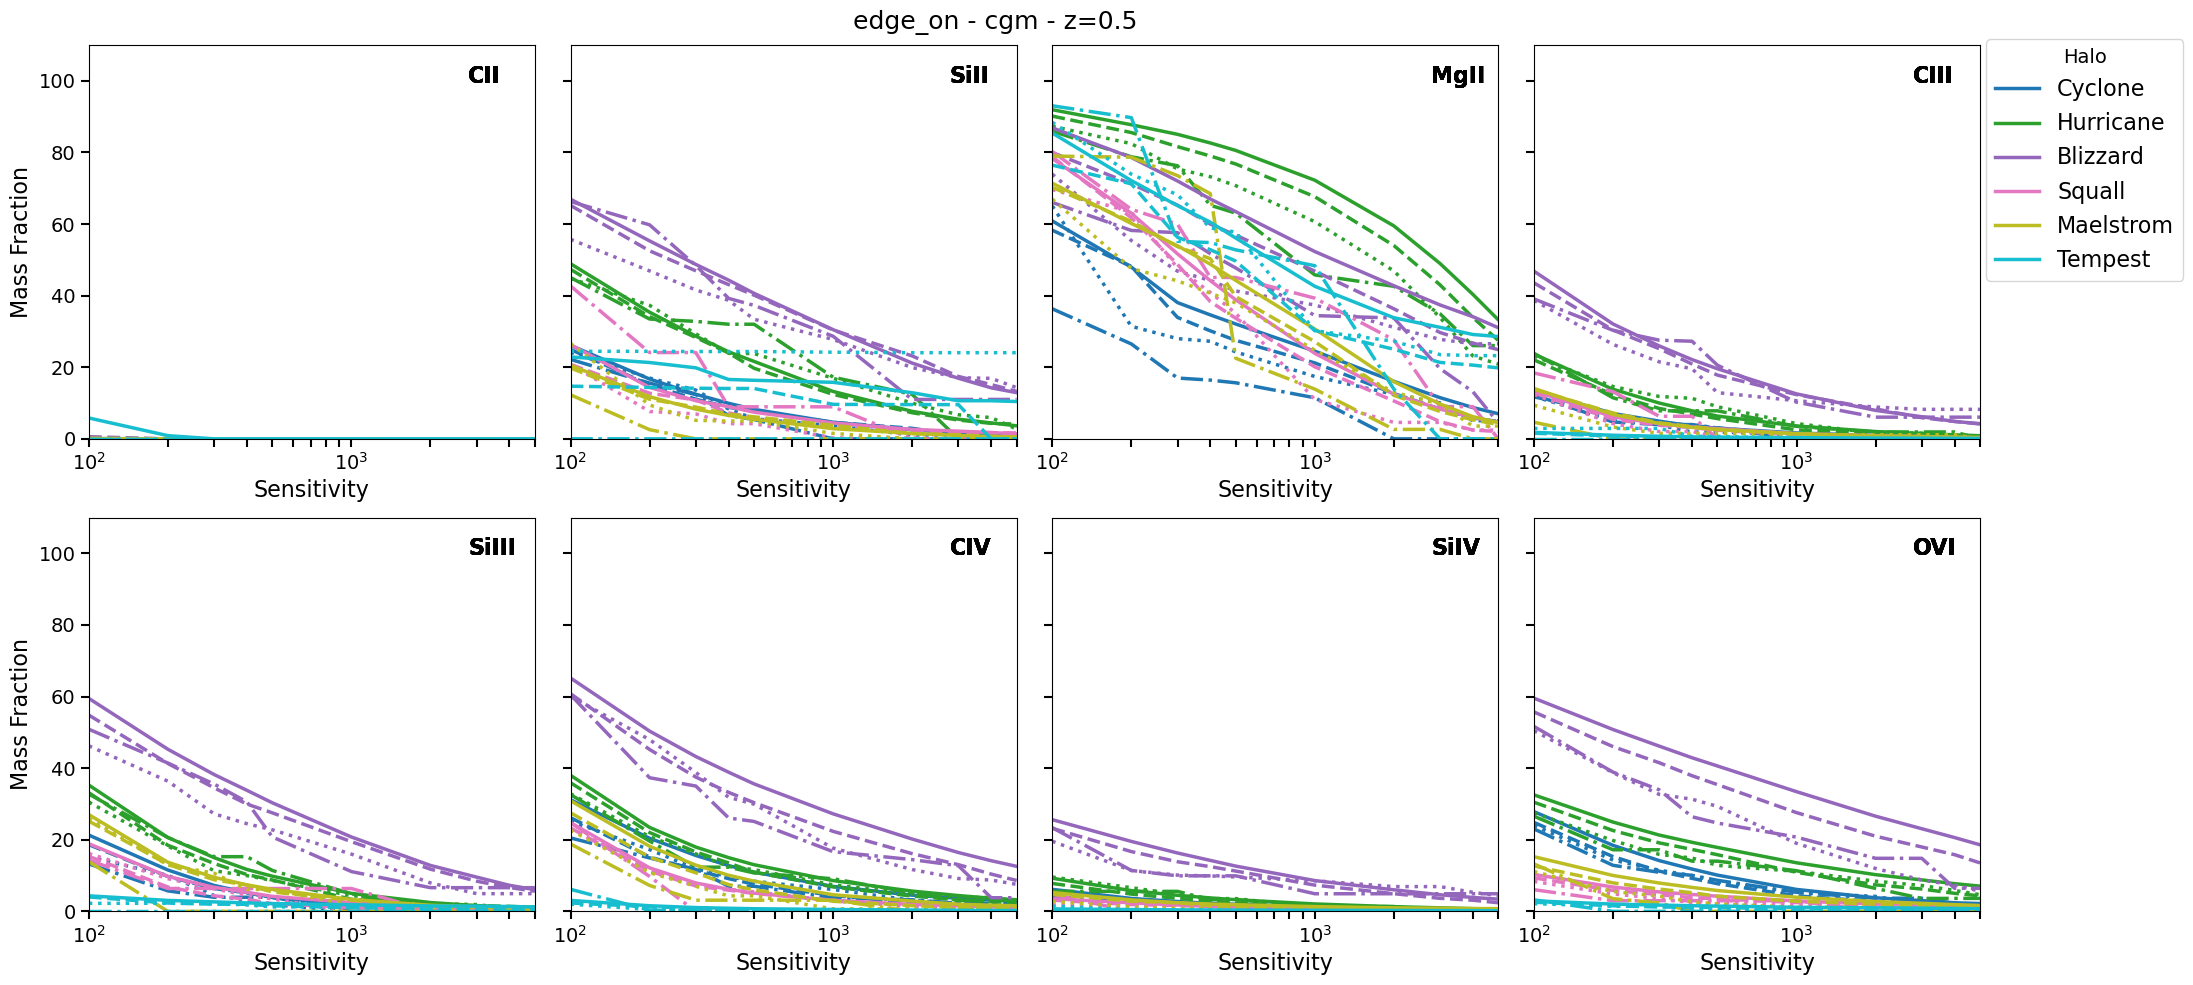

In [5]:
line_styles = ['-', '--', ':', '-.']  # Add more styles if needed
halo_cmap = mtcm.get_cmap('tab10', len(halos))

for orientation in orientations:
    for region in regions:
        fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
        axs = axs.flatten()
        if len(ions) == 1:
            axs = [axs]

        for halo_idx, halo in enumerate(halos):
            color = halo_cmap(halo_idx)
            halo_name = halo_dict[halo]

            for res_idx, resolution in enumerate(resolutions):
                foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                if regions == ['all']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
                elif regions == ['cgm']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                save_path = os.path.join(prefix, 'FRBs')
                file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                for ion_idx, ion in enumerate(ions):
                    with h5py.File(file_path, 'r') as f:
                        spatial_res = f[f'z={z}'].attrs['FRB_pixel_size_kpc']
                        mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                        emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                    total_mass = mass_data.sum()
                    all_fraction = []
                    for thresh in flux_thresholds[ion]:
                        above_id = np.where(emission_data >= thresh)
                        mass_above = mass_data[above_id].sum()
                        frac = (mass_above / total_mass) * 100
                        all_fraction.append(frac)
                        heatmap_data.setdefault((halo, orientation, ion, region), []).append((spatial_res, thresh, frac))

                    key = (halo, orientation, ion, region)
                    data = heatmap_data[key]

                    ax = axs[ion_idx]
                    line_style = line_styles[res_idx % len(line_styles)]

                    ax.plot(
                        flux_thresholds[ion],
                        all_fraction,
                        label=f'{halo_name}' if res_idx == 0 else "",  # Only add halo name once
                        linestyle=line_style,
                        color=color,
                        linewidth=2.5,
                        alpha=1,
                    )

                    # Add ion label inside each panel
                    if res_idx == 0:
                        ax.text(0.85, 0.95, ion, transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left', va='top')

                    ax.set_ylim(0, 110)
                    ax.set_xlim(100, 5000)
                    ax.set_xscale('log')
                    if ion_idx == 0 or ion_idx == 4:
                        ax.set_ylabel('Mass Fraction', fontsize=16)
                    ax.set_xlabel('Sensitivity', fontsize=16)
                    ax.tick_params(axis='both', which='both', labelsize=14, width=1.5, length=6)

        # Add legend outside plot
        handles, labels = axs[-1].get_legend_handles_labels()
        fig.legend(handles, labels, title='Halo', loc='center left', bbox_to_anchor=(0.99, 0.83), fontsize=16, title_fontsize=14)

        fig.suptitle(f'{orientation}_on - {region} - z={z}', fontsize=18)
        plt.tight_layout()

        output_file = os.path.join(output_dir,'All_halos','allhalos_massfrac_sensitivity_plots', f'z{z}_{orientation}_on_{region}_massfrac_vs_sensitivity_zoom.png')
        print(f'Saving figure to {output_file}')

        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_39188/1137728100.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  halo_cmap = mtcm.get_cmap('tab10', len(halos))


Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/res_allhalos_face_on_cgm_massfrac_vs_sensitivity_mean.png


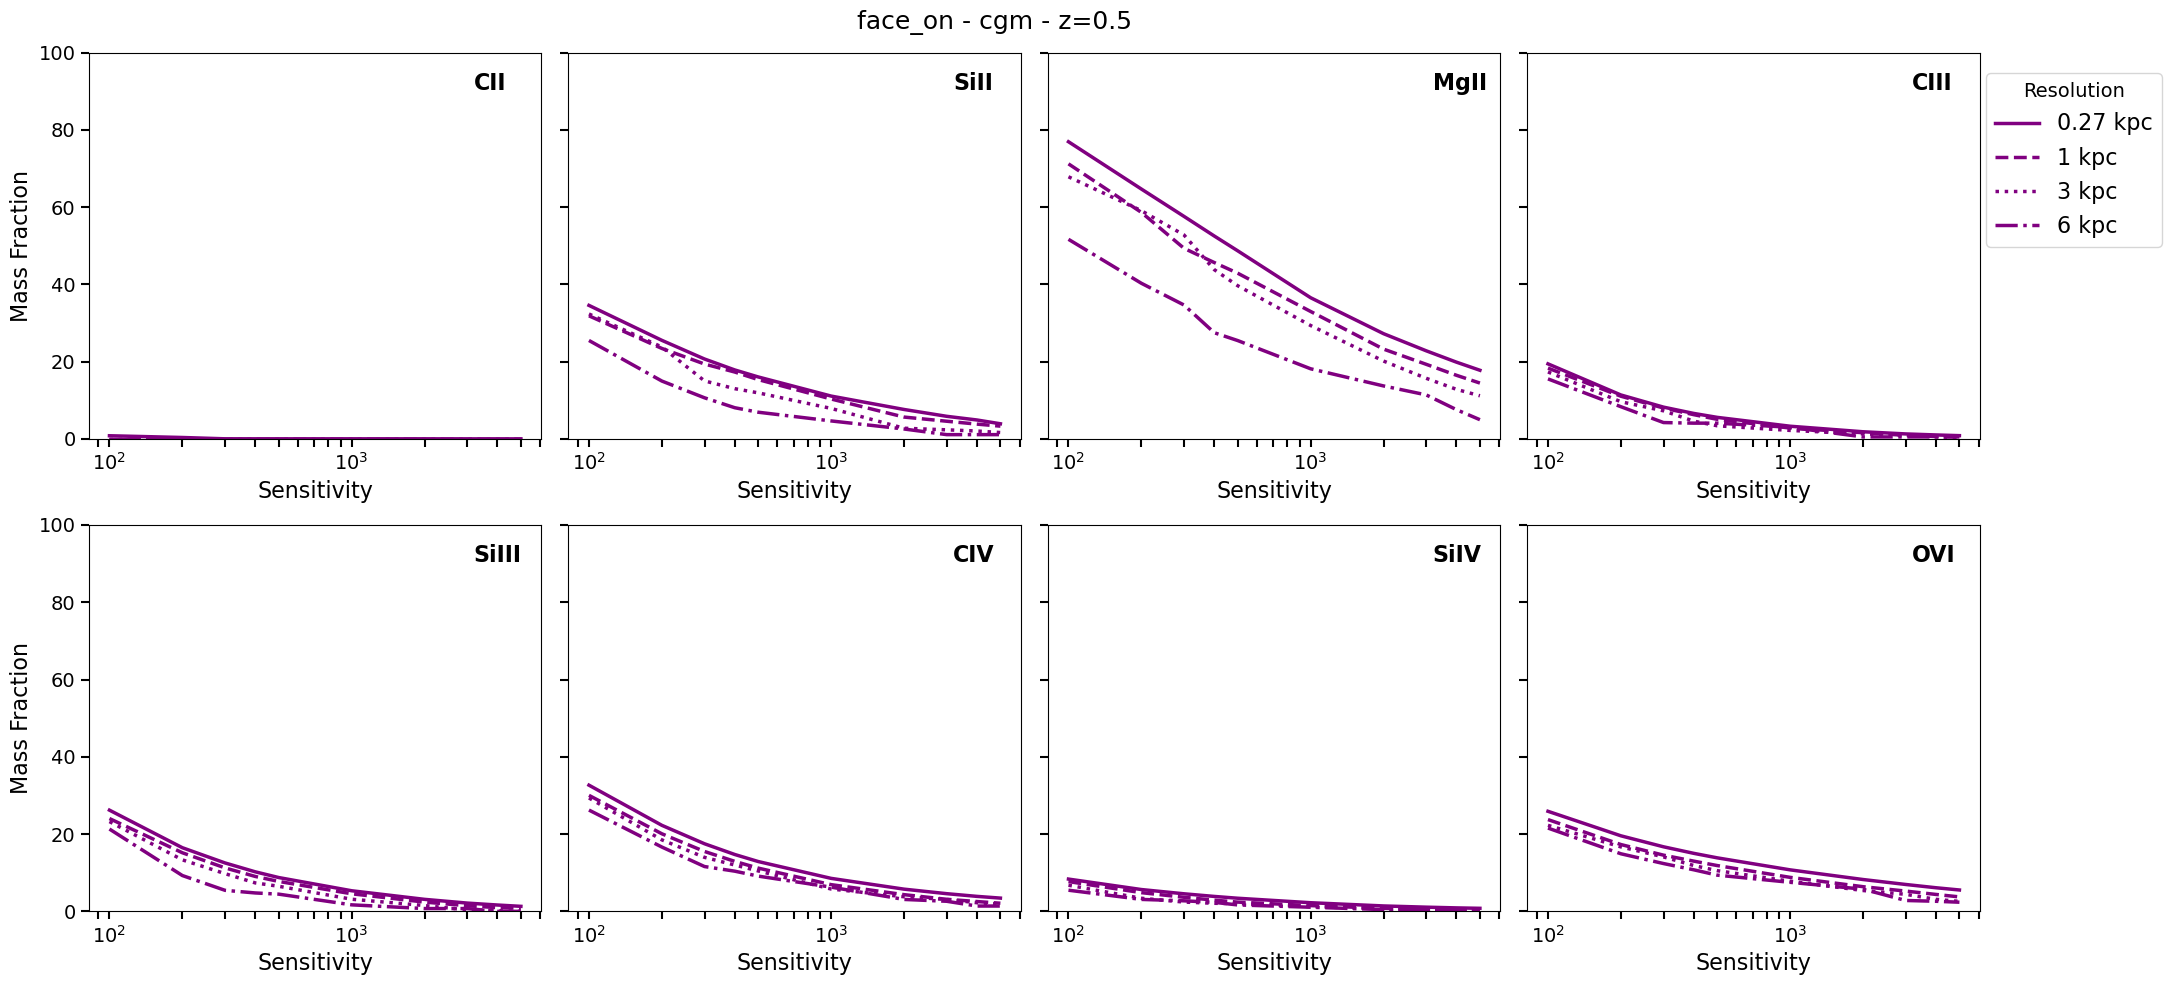

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/res_allhalos_edge_on_cgm_massfrac_vs_sensitivity_mean.png


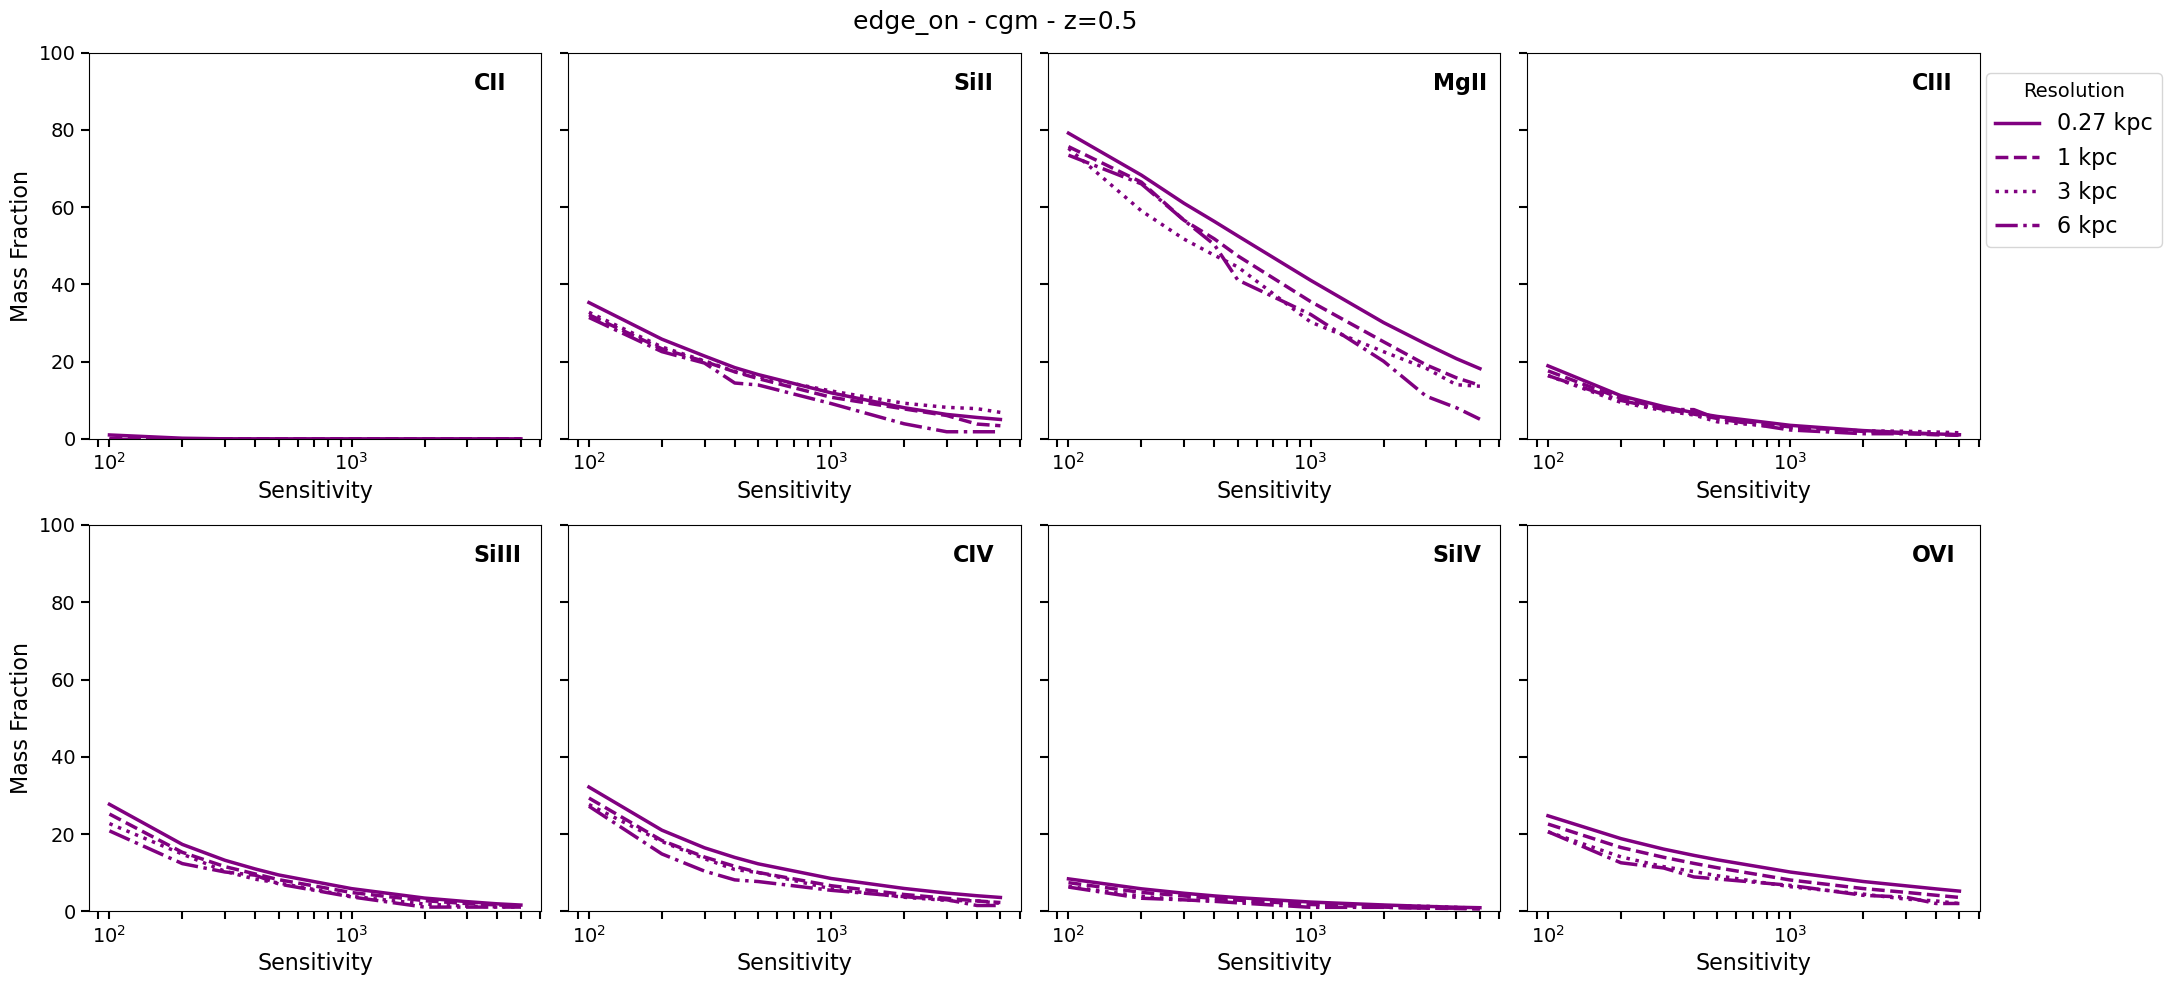

In [6]:
line_styles = ['-', '--', ':', '-.']  # One per resolution
halo_cmap = mtcm.get_cmap('tab10', len(halos))

for orientation in orientations:
    for region in regions:
        fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
        axs = axs.flatten()
        if len(ions) == 1:
            axs = [axs]

        for res_idx, resolution in enumerate(resolutions):
            # === Store all halo results for median/range ===
            all_halo_fractions = {ion: [] for ion in ions}

            for halo_idx, halo in enumerate(halos):
                halo_name = halo_dict[halo]

                foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                if regions == ['all']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
                elif regions == ['cgm']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                save_path = os.path.join(prefix, 'FRBs')
                file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                for ion in ions:
                    with h5py.File(file_path, 'r') as f:
                        mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                        emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                    total_mass = mass_data.sum()
                    all_fraction = []
                    for thresh in flux_thresholds[ion]:
                        above_id = np.where(emission_data >= thresh)
                        mass_above = mass_data[above_id].sum()
                        frac = (mass_above / total_mass) * 100
                        all_fraction.append(frac)
                    all_halo_fractions[ion].append(all_fraction)

            # === Plot median line + shaded region for each ion ===
            for ion_idx, ion in enumerate(ions):
                ax = axs[ion_idx]
                halo_fractions = np.array(all_halo_fractions[ion])  # shape: (n_halos, n_thresholds)
                med_frac = np.mean(halo_fractions, axis=0)
                min_frac = np.min(halo_fractions, axis=0)
                max_frac = np.max(halo_fractions, axis=0)

                # Plot shaded region
                # ax.fill_between(
                #     flux_thresholds[ion],
                #     min_frac,

                #     max_frac,
                #     color='purple',
                #     alpha=0.2,
                #     label='Range' if res_idx == 0 else None
                # )

                # Plot median line
                
                ax.plot(
                    flux_thresholds[ion],
                    med_frac,
                    label=f'{resolution} kpc',
                    linestyle=line_styles[res_idx % len(line_styles)],
                    color='purple',
                    linewidth=2.5
                )

                # Add ion name inside the panel
                if res_idx == 0:
                    ax.text(0.85, 0.95, ion, transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left', va='top')

                ax.set_ylim(0, 100)
                #ax.set_xlim(100, 5000)
                ax.set_xscale('log')
                if ion_idx == 0 or ion_idx == 4:
                    ax.set_ylabel('Mass Fraction', fontsize=16)
                ax.set_xlabel('Sensitivity', fontsize=16)
                ax.tick_params(axis='both', which='both', labelsize=14, width=1.5, length=6)

                x_vals = np.array(flux_thresholds[ion])
                y_vals = np.array(med_frac)

                # Get indices for x = 500 and x = 200
                x1, x2 = 500, 200
                idx1 = np.where(x_vals == x1)[0][0]
                idx2 = np.where(x_vals == x2)[0][0]

                y1 = y_vals[idx1]
                y2 = y_vals[idx2]
                
                # Compute slope in log-x space
                slope = (y2 - y1) / (np.log10(x2) - np.log10(x1))

                
                


        # === Final formatting ===
        handles, labels = axs[-1].get_legend_handles_labels()
        fig.legend(handles, labels, title='Resolution', loc='center left', bbox_to_anchor=(0.99, 0.83), fontsize=16, title_fontsize=14)

        fig.suptitle(f'{orientation}_on - {region} - z={z}', fontsize=18)
        plt.tight_layout()

        output_file = os.path.join(output_dir, 'All_halos', 'allhalos_massfrac_sensitivity_plots', f'res_allhalos_{orientation}_on_{region}_massfrac_vs_sensitivity_mean.png')
        print(f'Saving figure to {output_file}')

        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_39188/3995004423.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  halo_cmap = mtcm.get_cmap('tab10', len(halos))


y1: 0.010762072936703877, y2: 0.35316432788254987
Slope between sensitivity 500 and 2000 for CII: -0.8604368685834678
y1: 16.021351062165742, y2: 25.497847823761635
Slope between sensitivity 500 and 2000 for SiII: -23.813882884557994
y1: 48.66565073248113, y2: 64.6590849104715
Slope between sensitivity 500 and 2000 for MgII: -40.190565988481374
y1: 5.560050132262389, y2: 11.35917236109855
Slope between sensitivity 500 and 2000 for CIII: -14.572855461777683
y1: 8.750681550939488, y2: 16.47412678891432
Slope between sensitivity 500 and 2000 for SiIII: -19.408566793142214
y1: 12.893766068826771, y2: 22.266649350002925
Slope between sensitivity 500 and 2000 for CIV: -23.553508259836274
y1: 3.393080452316534, y2: 5.646800640307496
Slope between sensitivity 500 and 2000 for SiIV: -5.663467203289848
y1: 13.84890912297048, y2: 19.554720935567484
Slope between sensitivity 500 and 2000 for OVI: -14.338371835588545
y1: 0.0, y2: 0.0
Slope between sensitivity 500 and 2000 for CII: -0.0
y1: 15.33333

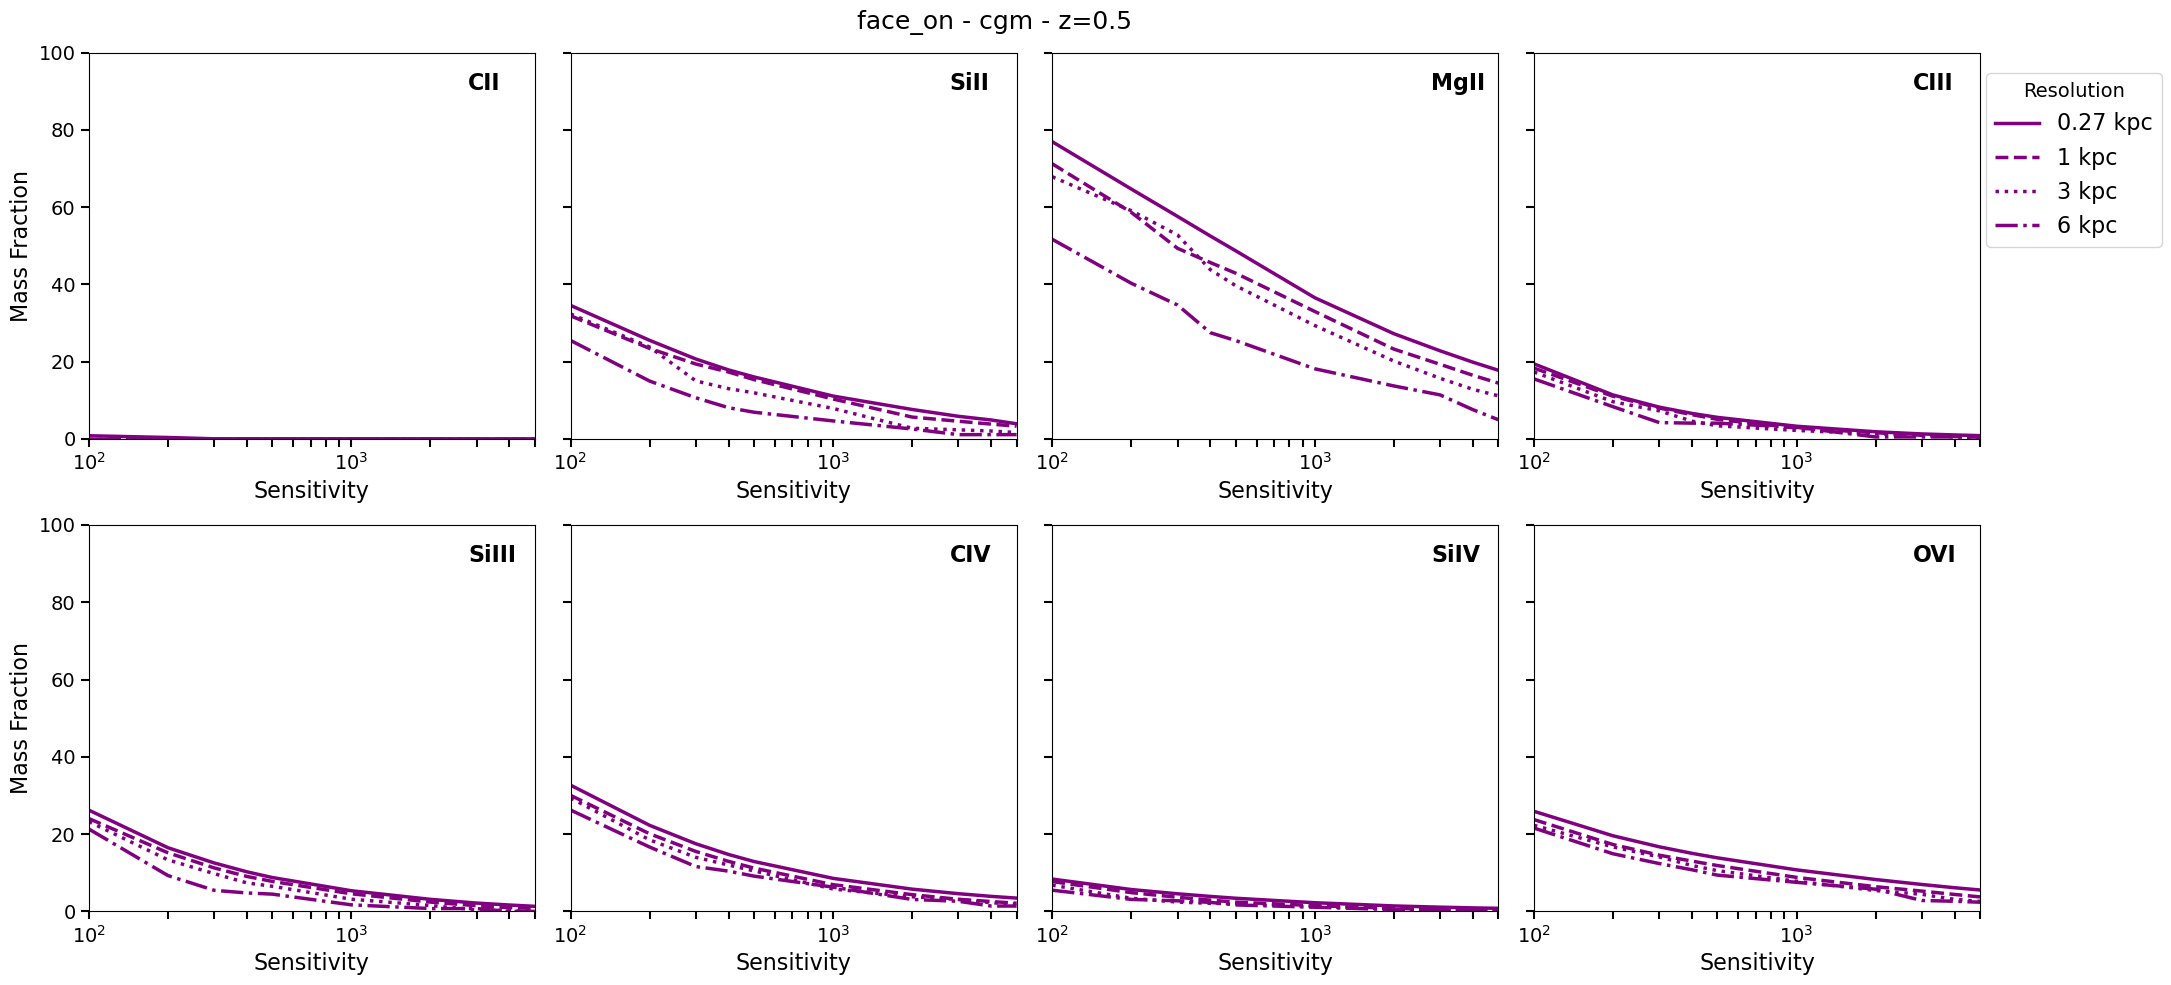

y1: 0.003998364892029659, y2: 0.1635143147107428
Slope between sensitivity 500 and 2000 for CII: -0.4008542653226364
y1: 16.63366215506377, y2: 25.802430460115342
Slope between sensitivity 500 and 2000 for SiII: -23.04057924622507
y1: 52.53881252772416, y2: 68.2635915740915
Slope between sensitivity 500 and 2000 for MgII: -39.51545133358765
y1: 5.802567888028327, y2: 11.16225945906514
Slope between sensitivity 500 and 2000 for CIII: -13.468591883793234
y1: 9.421519820511902, y2: 17.323312483218455
Slope between sensitivity 500 and 2000 for SiIII: -19.856743455063903
y1: 12.300528237100458, y2: 21.012267016103728
Slope between sensitivity 500 and 2000 for CIV: -21.892090740197613
y1: 3.548185083693081, y2: 5.836388401034974
Slope between sensitivity 500 and 2000 for SiIV: -5.750121293352327
y1: 13.349002384479514, y2: 18.830391210334167
Slope between sensitivity 500 and 2000 for OVI: -13.77440997738969
y1: 0.0, y2: 0.0
Slope between sensitivity 500 and 2000 for CII: -0.0
y1: 15.59476430

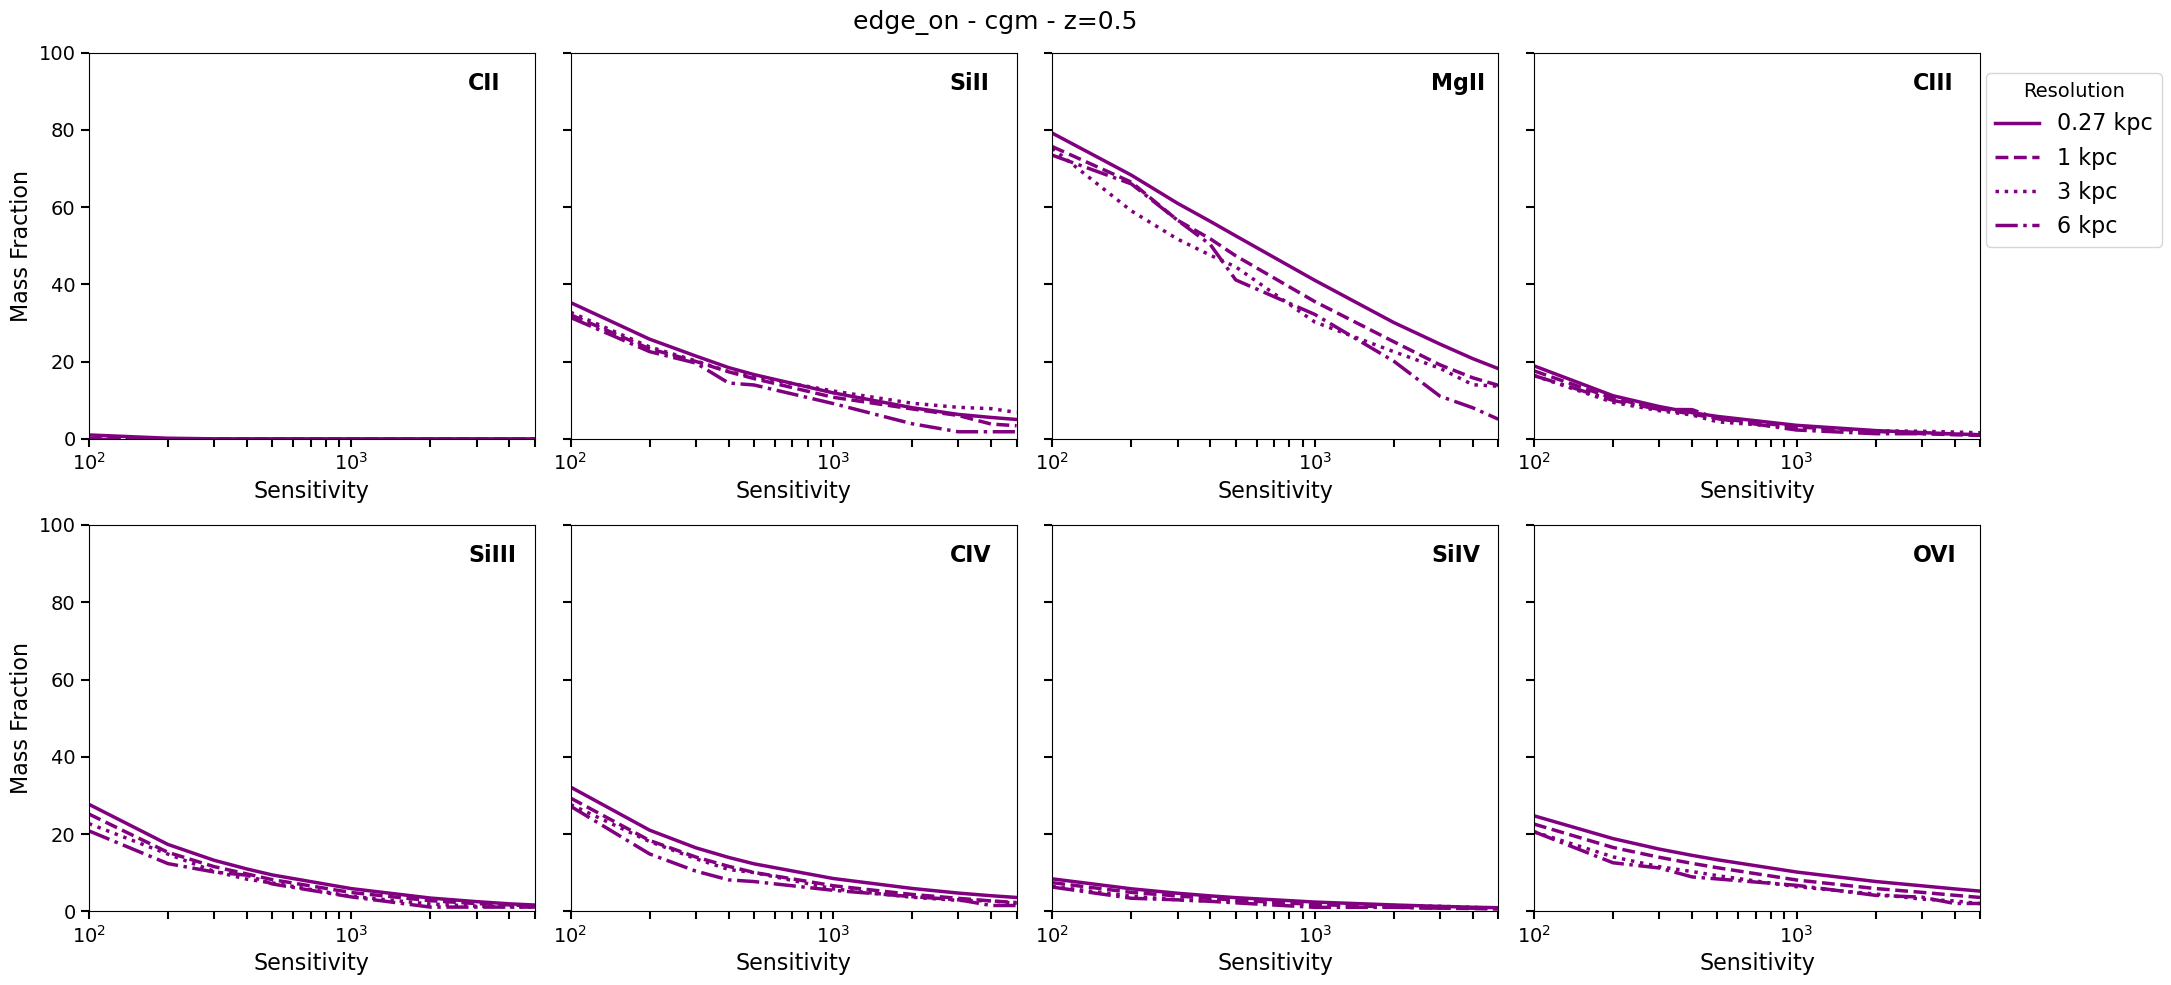

In [7]:
line_styles = ['-', '--', ':', '-.']  # One per resolution
halo_cmap = mtcm.get_cmap('tab10', len(halos))

for orientation in orientations:
    for region in regions:
        fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
        axs = axs.flatten()
        if len(ions) == 1:
            axs = [axs]

        for res_idx, resolution in enumerate(resolutions):
            # === Store all halo results for median/range ===
            all_halo_fractions = {ion: [] for ion in ions}

            for halo_idx, halo in enumerate(halos):
                halo_name = halo_dict[halo]

                foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                if regions == ['all']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
                elif regions == ['cgm']:
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                save_path = os.path.join(prefix, 'FRBs')
                file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                for ion in ions:
                    with h5py.File(file_path, 'r') as f:
                        mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                        emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                    total_mass = mass_data.sum()
                    all_fraction = []
                    for thresh in flux_thresholds[ion]:
                        above_id = np.where(emission_data >= thresh)
                        mass_above = mass_data[above_id].sum()
                        frac = (mass_above / total_mass) * 100
                        all_fraction.append(frac)
                    all_halo_fractions[ion].append(all_fraction)

            # === Plot median line + shaded region for each ion ===
            for ion_idx, ion in enumerate(ions):
                ax = axs[ion_idx]
                halo_fractions = np.array(all_halo_fractions[ion])  # shape: (n_halos, n_thresholds)
                med_frac = np.mean(halo_fractions, axis=0)
                min_frac = np.min(halo_fractions, axis=0)
                max_frac = np.max(halo_fractions, axis=0)

                # Plot shaded region
                # ax.fill_between(
                #     flux_thresholds[ion],
                #     min_frac,

                #     max_frac,
                #     color='purple',
                #     alpha=0.2,
                #     label='Range' if res_idx == 0 else None
                # )

                # Plot median line
                
                ax.plot(
                    flux_thresholds[ion],
                    med_frac,
                    label=f'{resolution} kpc',
                    linestyle=line_styles[res_idx % len(line_styles)],
                    color='purple',
                    linewidth=2.5
                )

                # Add ion name inside the panel
                if res_idx == 0:
                    ax.text(0.85, 0.95, ion, transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left', va='top')

                ax.set_ylim(0, 100)
                ax.set_xlim(100, 5000)
                ax.set_xscale('log')
                if ion_idx == 0 or ion_idx == 4:
                    ax.set_ylabel('Mass Fraction', fontsize=16)
                ax.set_xlabel('Sensitivity', fontsize=16)
                ax.tick_params(axis='both', which='both', labelsize=14, width=1.5, length=6)

                x_vals = np.array(flux_thresholds[ion])
                y_vals = np.array(med_frac)

                # Get indices for x = 500 and x = 200
                x1, x2 = 500, 200
                idx1 = np.where(x_vals == x1)[0][0]
                idx2 = np.where(x_vals == x2)[0][0]

                y1 = y_vals[idx1]
                y2 = y_vals[idx2]
                print(f"y1: {y1}, y2: {y2}")
                # Compute slope in log-x space
                slope = (y2 - y1) / (np.log10(x2) - np.log10(x1))

                print(f"Slope between sensitivity 500 and 2000 for {ion}: {slope}")
                


        # === Final formatting ===
        handles, labels = axs[-1].get_legend_handles_labels()
        fig.legend(handles, labels, title='Resolution', loc='center left', bbox_to_anchor=(0.99, 0.83), fontsize=16, title_fontsize=14)

        fig.suptitle(f'{orientation}_on - {region} - z={z}', fontsize=18)
        plt.tight_layout()

        output_file = os.path.join(output_dir, 'All_halos', 'allhalos_massfrac_sensitivity_plots', f'res_allhalos_{orientation}_on_{region}_massfrac_vs_sensitivity_mean_zoom.png')
        print(f'Saving figure to {output_file}')

        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/Users/vidasaeedzadeh/Projects/foggie_outputs/plots_halo_002878/nref11c_nref9f/FOGGIE/RD0042/box_100/without_disk/0.27/disk_cgm/FRBs/Cyclone_emission_maps.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

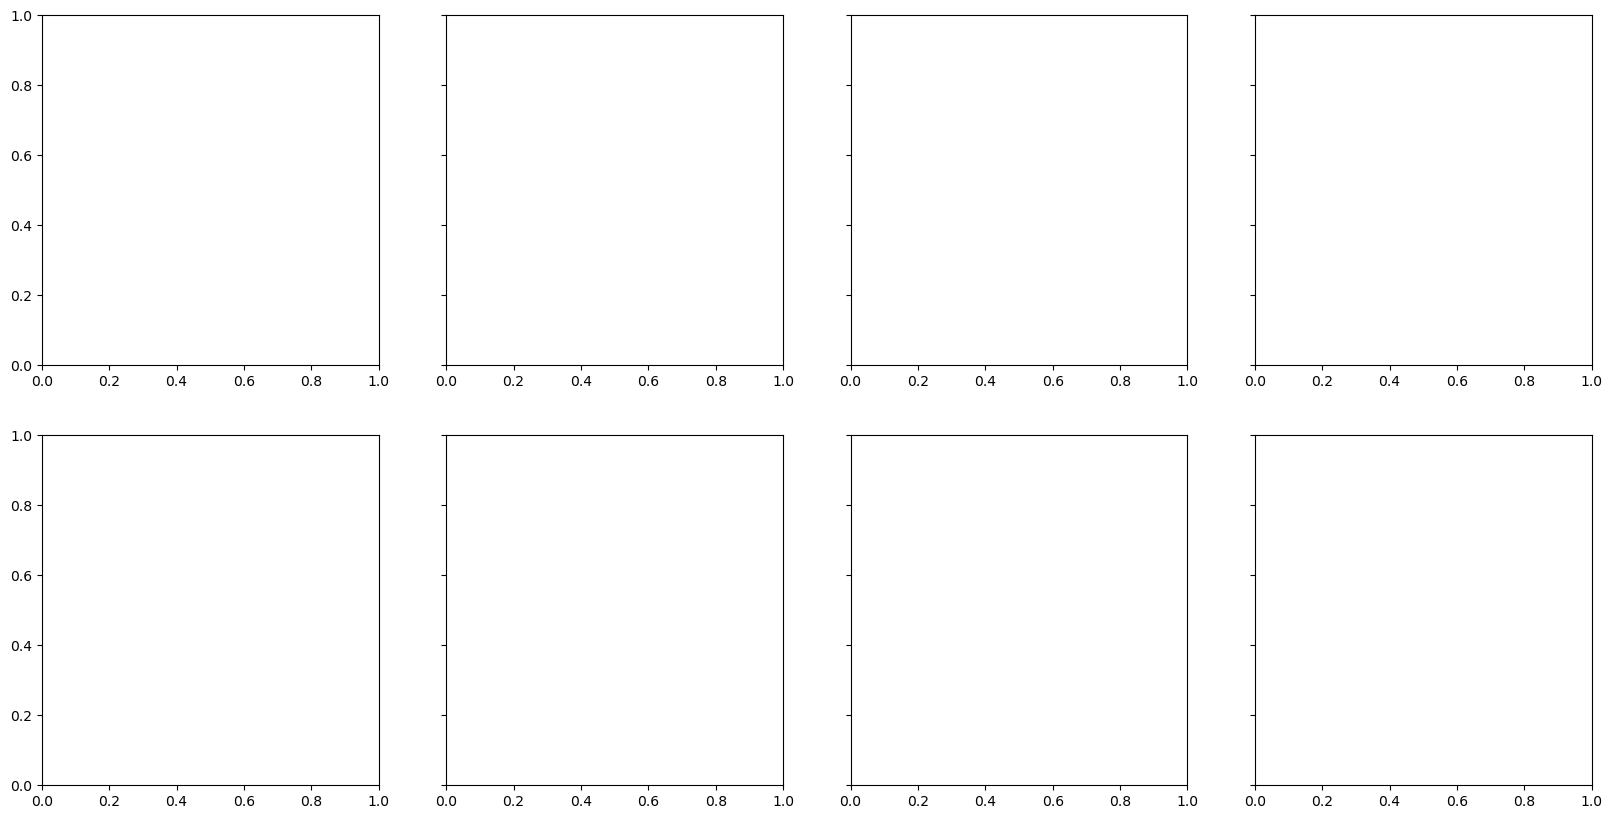

In [12]:
redshift_snaps = {
    '0.0': 'RD0042',
    '0.1': 'RD0040',
    '0.5': 'RD0032',
}

z_colors = {
    '0.0': 'tab:blue',
    '0.1': 'tab:orange',
    '0.5': 'tab:green',
}



for orientation in orientations:
    for region in regions:
        fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
        axs = axs.flatten()

        if len(ions) == 1:
            axs = [axs]

        for z, snap in redshift_snaps.items():
            for res_idx, resolution in enumerate(resolutions):
                all_halo_fractions = {ion: [] for ion in ions}

                for halo_idx, halo in enumerate(halos):
                    halo_name = halo_dict[halo]
                    foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                    # Choose the correct directory
                    if region == 'all':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', snap, f'box_{box_name}', 'with_disk', str(resolution))
                    elif region == 'cgm':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', snap, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                    save_path = os.path.join(prefix, 'FRBs')
                    file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                    for ion in ions:
                        with h5py.File(file_path, 'r') as f:
                            group_name = f'z={z}'
                            mass_data = np.array(f[f'{group_name}/{ion}_mass_{orientation}_{region}']).flatten()
                            emission_data = np.array(f[f'{group_name}/{ion}_emission_{orientation}_{region}']).flatten()

                        total_mass = mass_data.sum()
                        all_fraction = []
                        for thresh in flux_thresholds[ion]:
                            above_id = np.where(emission_data >= thresh)
                            mass_above = mass_data[above_id].sum()
                            frac = (mass_above / total_mass) * 100
                            all_fraction.append(frac)
                        all_halo_fractions[ion].append(all_fraction)

                # === Plotting ===
                for ion_idx, ion in enumerate(ions):
                    ax = axs[ion_idx]
                    halo_fractions = np.array(all_halo_fractions[ion])
                    med_frac = np.mean(halo_fractions, axis=0)
                    min_frac = np.min(halo_fractions, axis=0)
                    max_frac = np.max(halo_fractions, axis=0)

                    ax.fill_between(
                        flux_thresholds[ion],
                        min_frac,
                        max_frac,
                        color=z_colors[z],
                        alpha=0.2 if res_idx == 0 else 0,
                        label=f'z={z}' if res_idx == 0 else None
                    )

                    ax.plot(
                        flux_thresholds[ion],
                        med_frac,
                        label=f'z={z}, {resolution} kpc',
                        color=z_colors[z],
                        linestyle=line_styles[res_idx % len(line_styles)],
                        linewidth=2.5
                    )

                    if z == '0.0' and res_idx == 0:
                        ax.text(0.85, 0.95, ion, transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left', va='top')

                    ax.set_ylim(0, 100)
                    ax.set_xscale('log')
                    if ion_idx % 4 == 0:
                        ax.set_ylabel('Mass Fraction', fontsize=16)
                    ax.set_xlabel('Sensitivity', fontsize=16)
                    ax.tick_params(axis='both', which='both', labelsize=14, width=1.5, length=6)

        # === Final formatting ===
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, title='Redshift + Resolution', loc='center left', bbox_to_anchor=(0.99, 0.83), fontsize=14, title_fontsize=14)
        fig.suptitle(f'{orientation}-on | {region}', fontsize=18)

        plt.tight_layout()
        outname = f"res_redshift_massfrac_sensitivity_{orientation}_{region}.png"
        output_file = os.path.join(output_dir, 'All_halos', 'allhalos_massfrac_sensitivity_plots', outname)
        print(f'Saving figure to {output_file}')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)


Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/res_redshift_massfrac_sensitivity_face_cgm_zoom.png


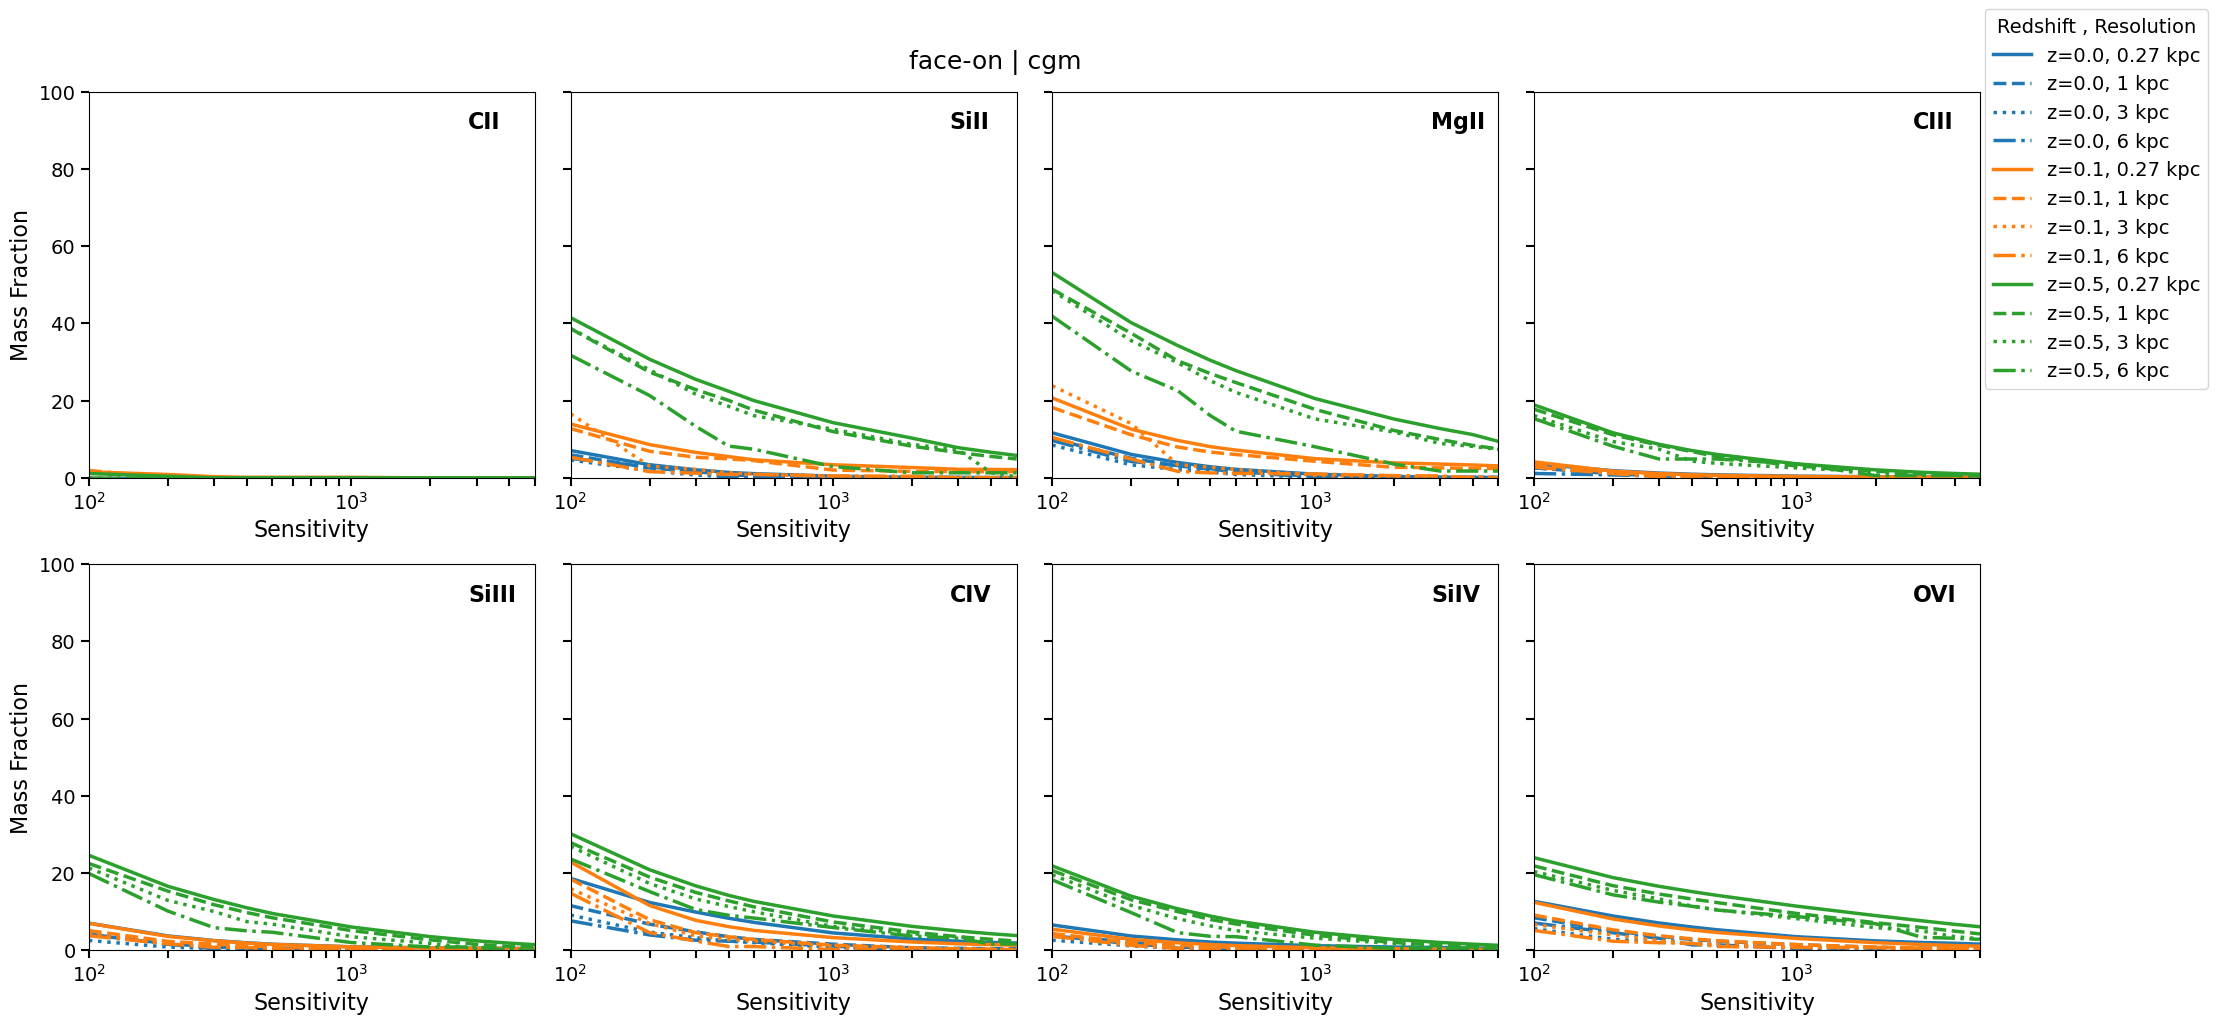

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/res_redshift_massfrac_sensitivity_edge_cgm_zoom.png


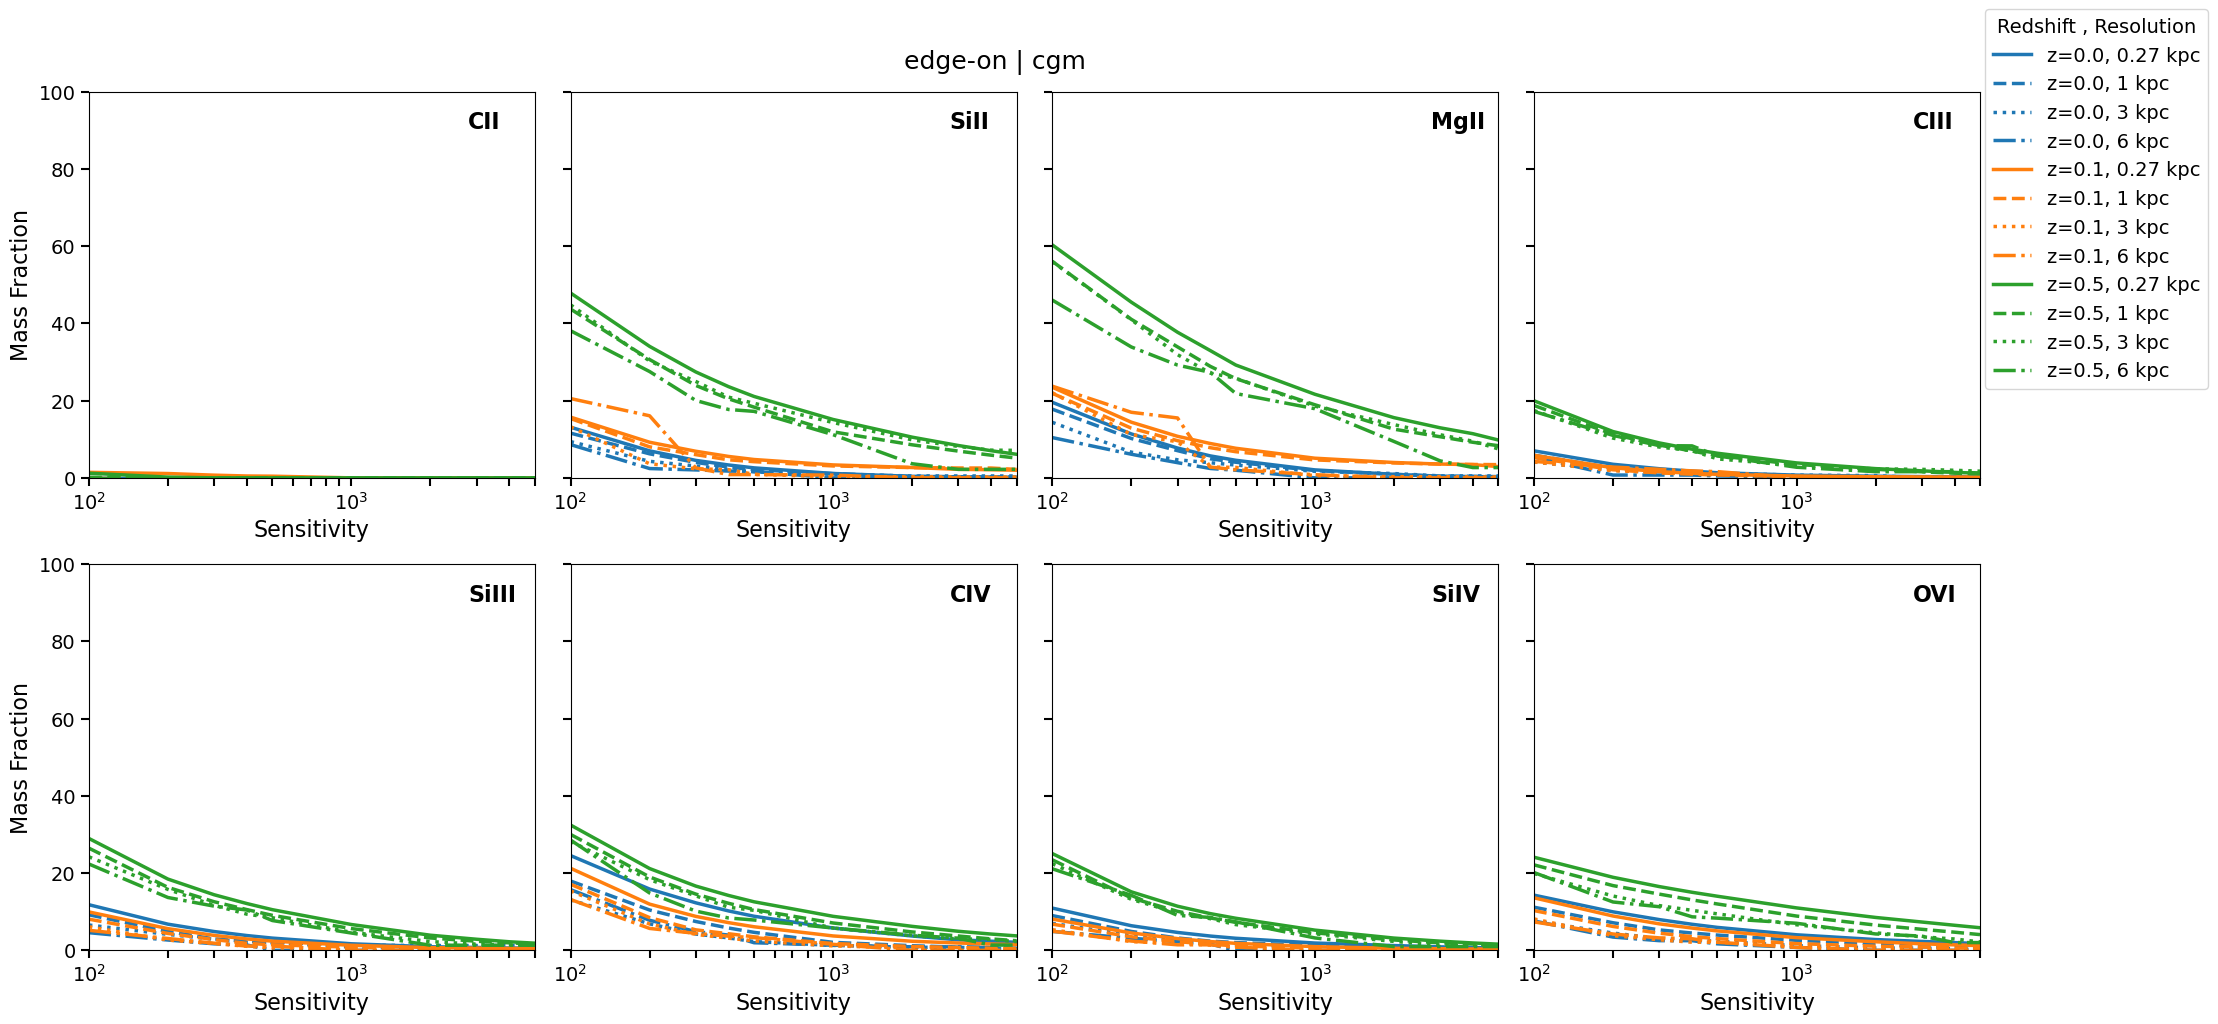

In [ ]:
redshift_snaps = {
    '0.0': 'RD0042',
    '0.1': 'RD0040',
    '0.5': 'RD0032',
}

z_colors = {
    '0.0': 'tab:blue',
    '0.1': 'tab:orange',
    '0.5': 'tab:green',
}



for orientation in orientations:
    for region in regions:
        fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
        axs = axs.flatten()

        if len(ions) == 1:
            axs = [axs]

        for z, snap in redshift_snaps.items():
            for res_idx, resolution in enumerate(resolutions):
                all_halo_fractions = {ion: [] for ion in ions}

                for halo_idx, halo in enumerate(halos):
                    halo_name = halo_dict[halo]
                    foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                    # Choose the correct directory
                    if region == 'all':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', snap, f'box_{box_name}', 'with_disk', str(resolution))
                    elif region == 'cgm':
                        prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', snap, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                    save_path = os.path.join(prefix, 'FRBs')
                    file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                    for ion in ions:
                        with h5py.File(file_path, 'r') as f:
                            group_name = f'z={z}'
                            mass_data = np.array(f[f'{group_name}/{ion}_mass_{orientation}_{region}']).flatten()
                            emission_data = np.array(f[f'{group_name}/{ion}_emission_{orientation}_{region}']).flatten()

                        total_mass = mass_data.sum()
                        all_fraction = []
                        for thresh in flux_thresholds[ion]:
                            above_id = np.where(emission_data >= thresh)
                            mass_above = mass_data[above_id].sum()
                            frac = (mass_above / total_mass) * 100
                            all_fraction.append(frac)
                        all_halo_fractions[ion].append(all_fraction)

                # === Plotting ===
                for ion_idx, ion in enumerate(ions):
                    ax = axs[ion_idx]
                    halo_fractions = np.array(all_halo_fractions[ion])
                    med_frac = np.mean(halo_fractions, axis=0)
                    min_frac = np.min(halo_fractions, axis=0)
                    max_frac = np.max(halo_fractions, axis=0)

                    # ax.fill_between(
                    #     flux_thresholds[ion],
                    #     min_frac,
                    #     max_frac,
                    #     color=z_colors[z],
                    #     alpha=0.2 if res_idx == 0 else 0,
                        
                    # )#label=f'z={z}' if res_idx == 0 else None

                    ax.plot(
                        flux_thresholds[ion],
                        med_frac,
                        label=f'z={z}, {resolution} kpc',
                        color=z_colors[z],
                        linestyle=line_styles[res_idx % len(line_styles)],
                        linewidth=2.5
                    )

                    if z == '0.0' and res_idx == 0:
                        ax.text(0.85, 0.95, ion, transform=ax.transAxes, fontsize=16, fontweight='bold', ha='left', va='top')

                    ax.set_ylim(0, 100)
                    ax.set_xlim(100, 5000)
                    ax.set_xscale('log')
                    if ion_idx % 4 == 0:
                        ax.set_ylabel('Mass Fraction', fontsize=16)
                    ax.set_xlabel('Sensitivity', fontsize=16)
                    ax.tick_params(axis='both', which='both', labelsize=14, width=1.5, length=6)

        # === Final formatting ===
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, title='Redshift , Resolution', loc='center left', bbox_to_anchor=(0.99, 0.83), fontsize=14, title_fontsize=14)
        fig.suptitle(f'{orientation}-on | {region}', fontsize=18)

        plt.tight_layout()
        outname = f"res_redshift_massfrac_sensitivity_{orientation}_{region}_zoom.png"
        output_file = os.path.join(output_dir, 'All_halos', 'allhalos_massfrac_sensitivity_plots', outname)
        print(f'Saving figure to {output_file}')
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)


/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_44368/3460310488.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  halo_cmap = mtcm.get_cmap('tab10', len(halos))


y1: 0.0034680585909726844, y2: 0.4143507645259879
Slope between sensitivity 500 and 2000 for CII: -1.0325242423001615
y1: 19.977237268195488, y2: 30.701197972243467
Slope between sensitivity 500 and 2000 for SiII: -26.948686913474283
y1: 27.76433476076328, y2: 40.14799788847919
Slope between sensitivity 500 and 2000 for MgII: -31.119422168787036
y1: 6.039790164429745, y2: 11.661380473729979
Slope between sensitivity 500 and 2000 for CIII: -14.126728116783228
y1: 9.544165236102106, y2: 16.579185038638734
Slope between sensitivity 500 and 2000 for SiIII: -17.67859388155802
y1: 12.669315363700951, y2: 20.858995301355396
Slope between sensitivity 500 and 2000 for CIV: -20.580187362874526
y1: 7.598940718964007, y2: 14.008617108176276
Slope between sensitivity 500 and 2000 for SiIV: -16.107142407223517
y1: 14.214067537203068, y2: 18.82458967692133
Slope between sensitivity 500 and 2000 for OVI: -11.585972858331086
Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allha

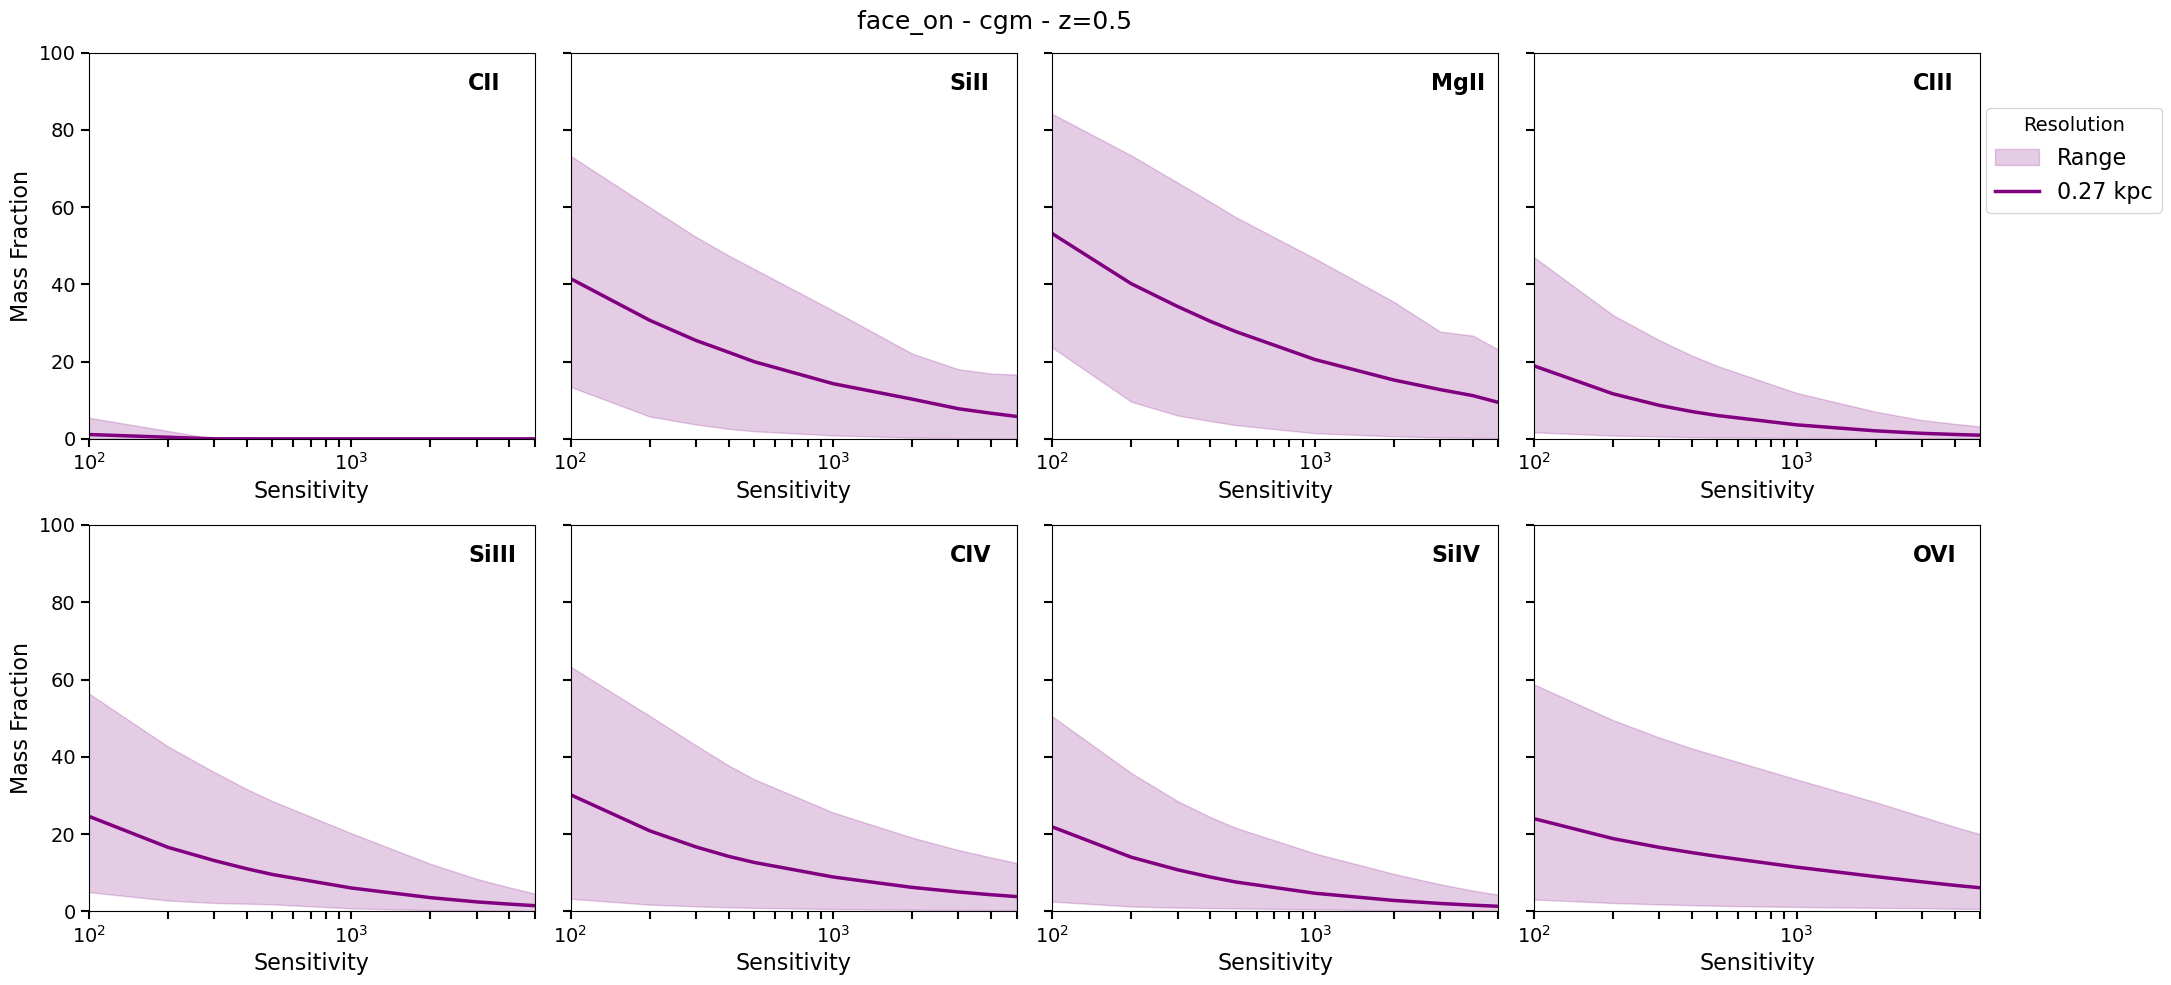

y1: 0.0, y2: 0.19141913978245578
Slope between sensitivity 500 and 2000 for CII: -0.4810251183871637
y1: 21.067755423504515, y2: 34.030856461601886
Slope between sensitivity 500 and 2000 for SiII: -32.57551579534924
y1: 29.202213154380786, y2: 45.47272401937913
Slope between sensitivity 500 and 2000 for MgII: -40.886843520194255
y1: 6.366900223914432, y2: 11.98249815812002
Slope between sensitivity 500 and 2000 for CIII: -14.111669628156656
y1: 10.525774921389987, y2: 18.451281825485957
Slope between sensitivity 500 and 2000 for SiIII: -19.916335958638886
y1: 12.566267390126425, y2: 21.17534044984572
Slope between sensitivity 500 and 2000 for CIV: -21.634097783855825
y1: 8.307364858086697, y2: 15.148314703683791
Slope between sensitivity 500 and 2000 for SiIV: -17.190907414476808
y1: 14.00253273087714, y2: 18.91023532395878
Slope between sensitivity 500 and 2000 for OVI: -12.332769980729244
Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensi

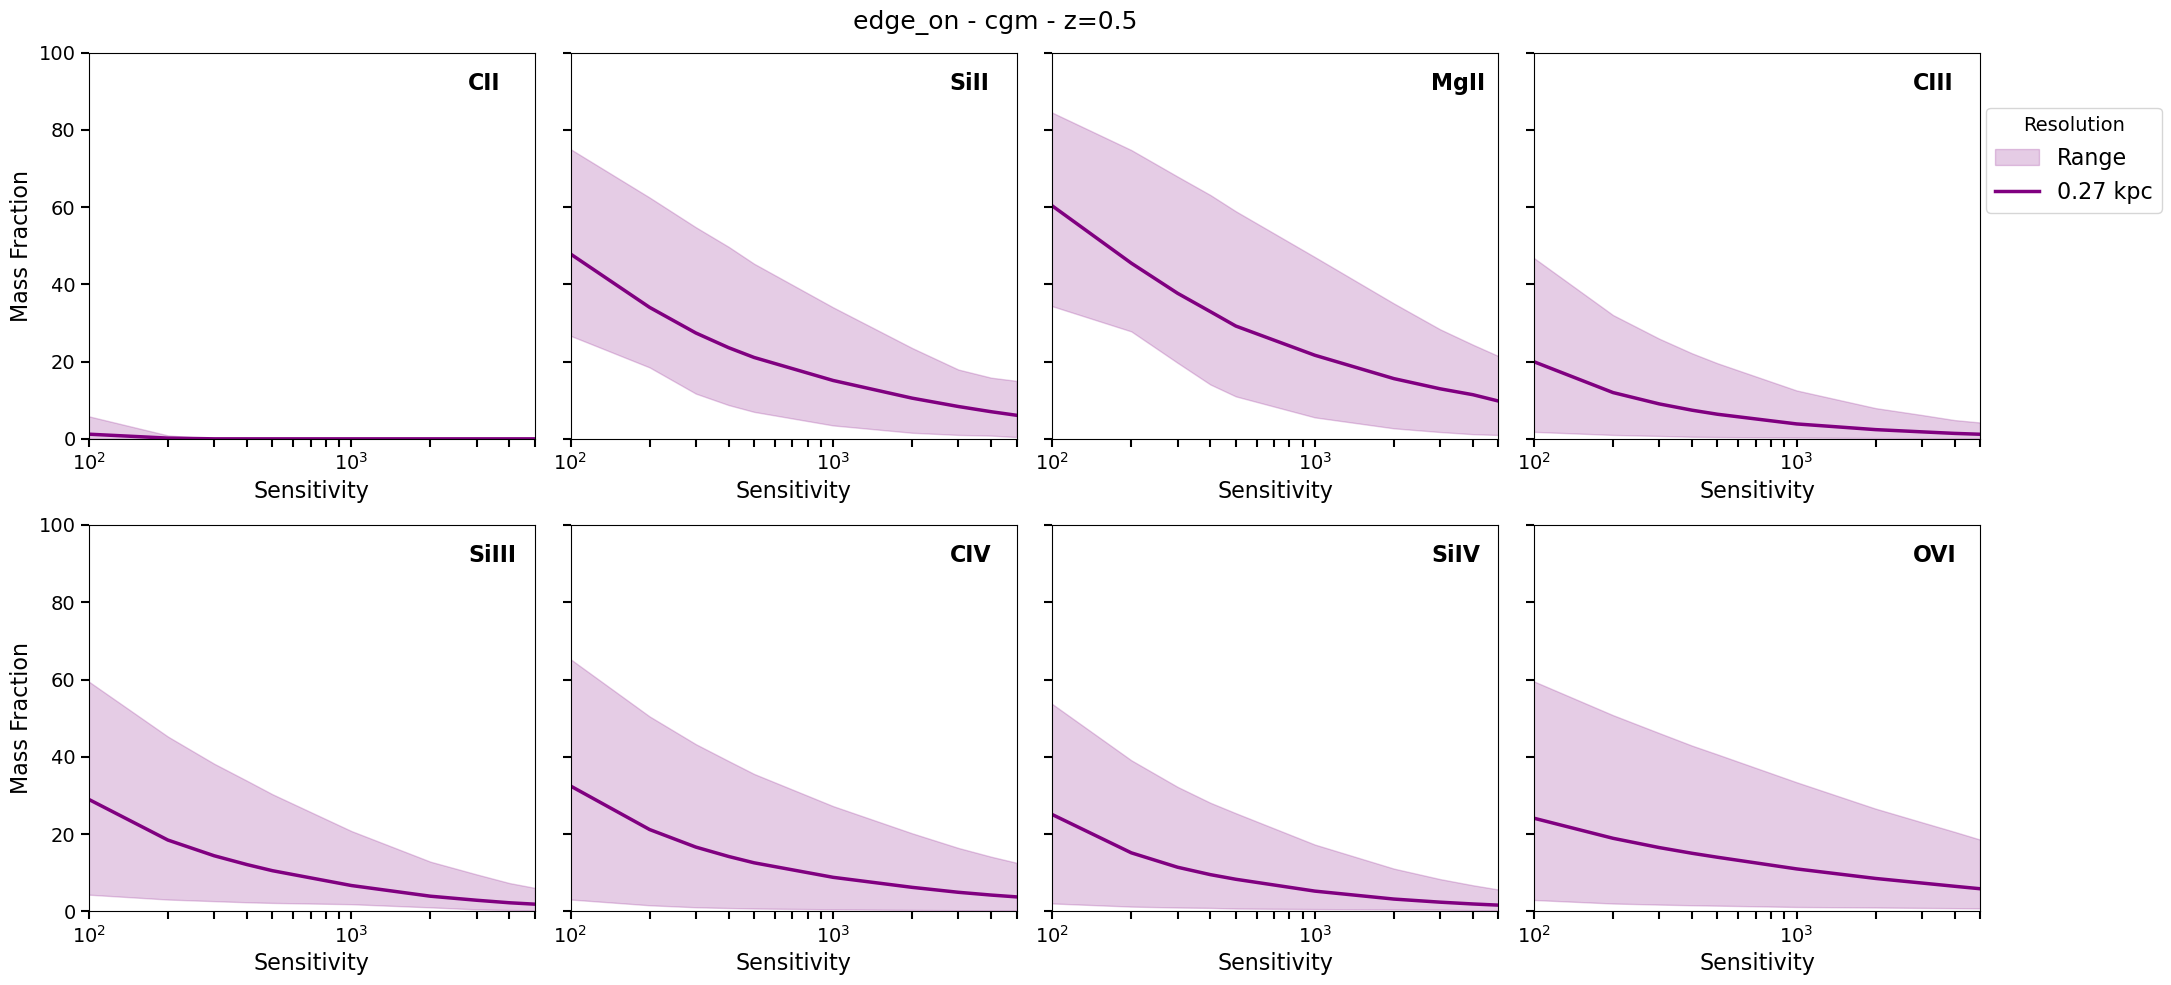

/var/folders/03/8m_yf9p11xd_2mlw7w_4dw4w0000gn/T/ipykernel_39188/4282255994.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/allions_heatmap_face_cgm_z0.5.png


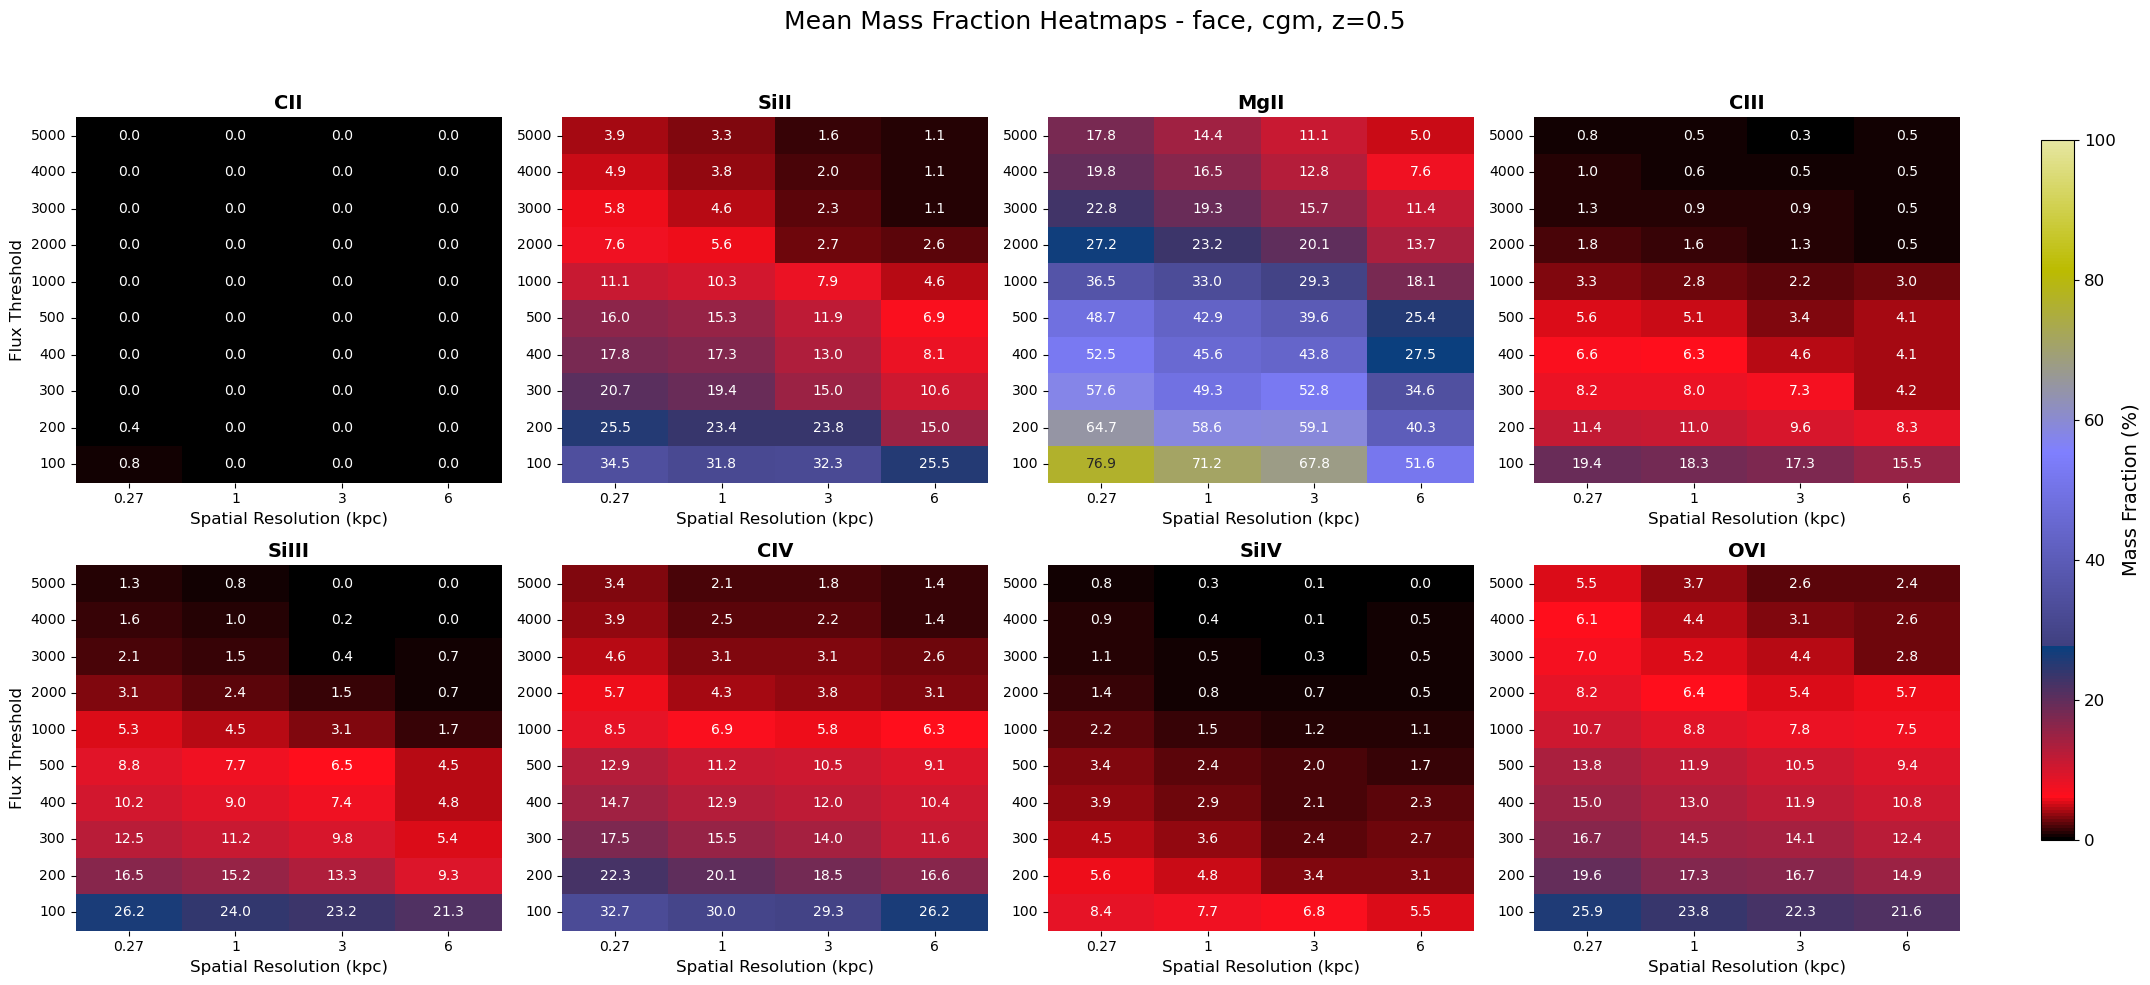

Saving figure to /Users/vidasaeedzadeh/Projects/foggie_outputs/All_halos/allhalos_massfrac_sensitivity_plots/allions_heatmap_edge_cgm_z0.5.png


<Figure size 640x480 with 0 Axes>

In [20]:

fig, axs = plt.subplots(2, 4, figsize=(22, 10))
axs = axs.flatten()

# Create a single color scale
vmin = 0
vmax = 100
cmap = cmr.get_sub_cmap('gist_stern', 0.0, 0.9)
#sns.color_palette("gnuplot2", as_cmap=True, cmap_range=(0.2, 1))
#sns.cubehelix_palette(as_cmap=True)
#  # You can change this

# Prepare to store all heatmaps so we can use the same colormap

for orientation in orientations:
    all_heatmaps = []
    for ion_idx, ion in enumerate(ions):
        ax = axs[ion_idx]
        heatmap_array = np.zeros((len(flux_thresholds[ion]), len(resolutions)))

        for res_idx, resolution in enumerate(resolutions):
            all_fractions_per_thresh = []

            for halo in halos:
                halo_name = halo_dict[halo]
                foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)

                if region == 'all':
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'with_disk', str(resolution))
                elif region == 'cgm':
                    prefix = os.path.join(output_dir, f'plots_halo_00{halo}', run, 'FOGGIE', output, f'box_{box_name}', 'without_disk', str(resolution), 'disk_cgm')

                save_path = os.path.join(prefix, 'FRBs')
                file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                with h5py.File(file_path, 'r') as f:
                    mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                    emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()

                total_mass = mass_data.sum()
                halo_fractions = []
                for thresh in flux_thresholds[ion]:
                    above_id = np.where(emission_data >= thresh)
                    mass_above = mass_data[above_id].sum()
                    frac = (mass_above / total_mass) * 100
                    halo_fractions.append(frac)

                all_fractions_per_thresh.append(halo_fractions)

            # Compute mean across halos, store in column for that resolution
            mean_fractions = np.mean(all_fractions_per_thresh, axis=0)
            for t_idx, frac in enumerate(mean_fractions):
                heatmap_array[t_idx, res_idx] = frac

        # Flip and annotate
        flipped_array = np.flipud(heatmap_array)
        annotations = np.round(flipped_array, 1)

        # Save for shared colorbar setup
        im = sns.heatmap(
            flipped_array,
            annot=annotations,
            fmt=".1f",
            ax=ax,
            xticklabels=resolutions,
            yticklabels=flux_thresholds[ion][::-1],
            vmin=vmin,
            vmax=vmax,
            cmap=cmap,
            cbar=False  # Disable individual colorbars
        )

        if ion_idx == 0 or ion_idx == 4:
            ax.set_ylabel('Flux Threshold', fontsize=12)
        else:
            ax.set_ylabel('')

        ax.set_xlabel('Spatial Resolution (kpc)', fontsize=12)
        ax.set_title(ion, fontsize=14, fontweight='bold')
        ax.tick_params(axis='both', labelsize=10)

        all_heatmaps.append(im)

    # Shared colorbar (based on last heatmap object)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
    cbar = fig.colorbar(all_heatmaps[-1].collections[0], cax=cbar_ax)
    cbar.set_label('Mass Fraction (%)', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    # Final layout
    fig.suptitle(f'Mean Mass Fraction Heatmaps - {orientation}, {region}, z={z}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])

    output_file = os.path.join(output_dir, 'All_halos', 'allhalos_massfrac_sensitivity_plots', f'allions_heatmap_{orientation}_{region}_z{z}.png')
    print(f'Saving figure to {output_file}')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()


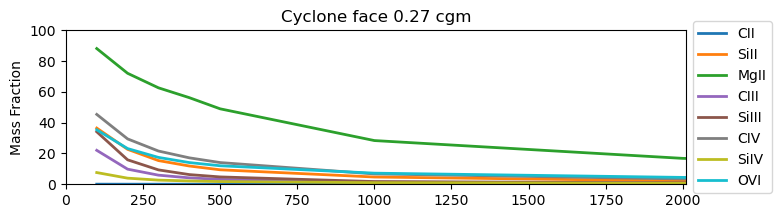

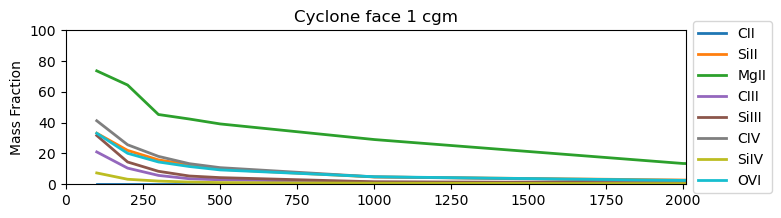

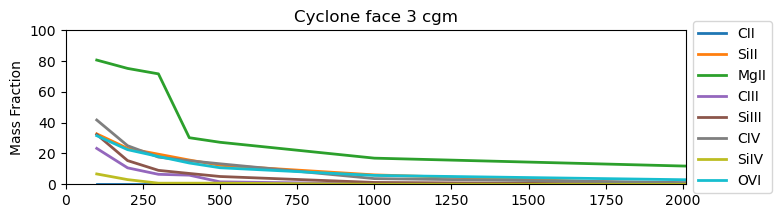

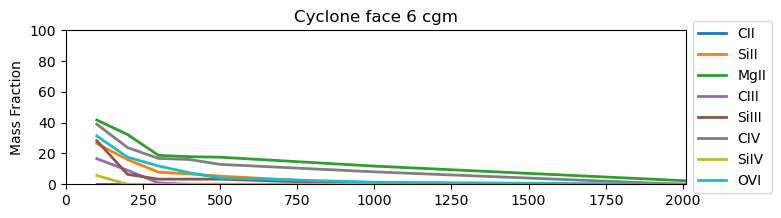

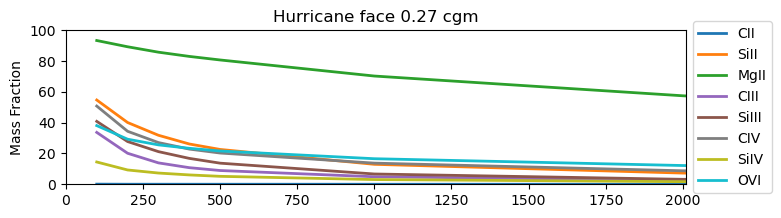

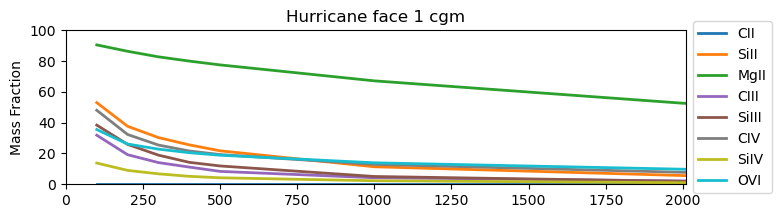

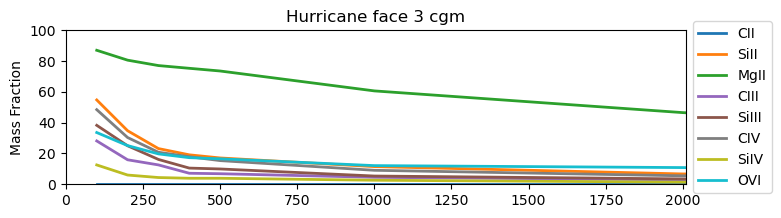

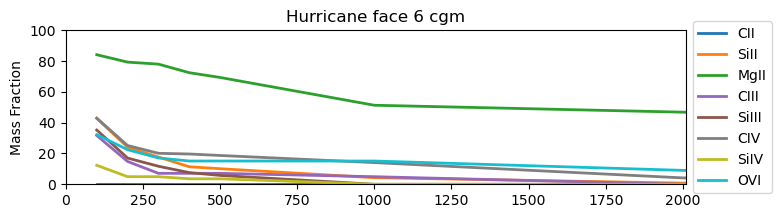

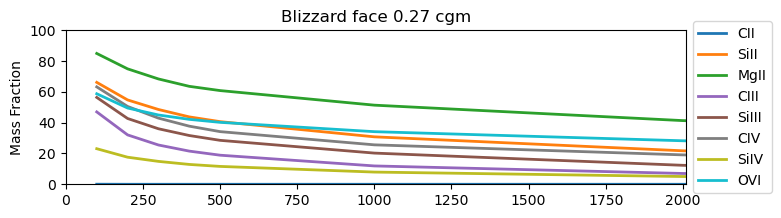

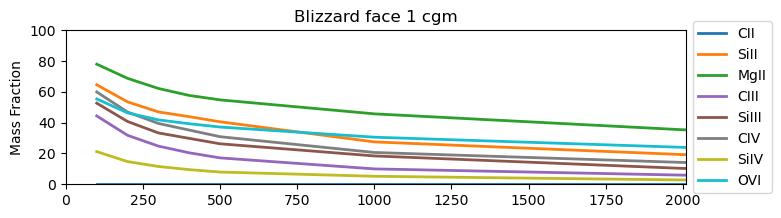

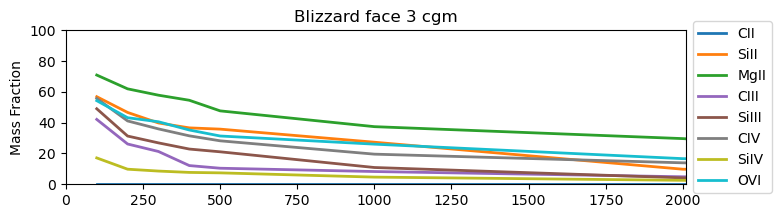

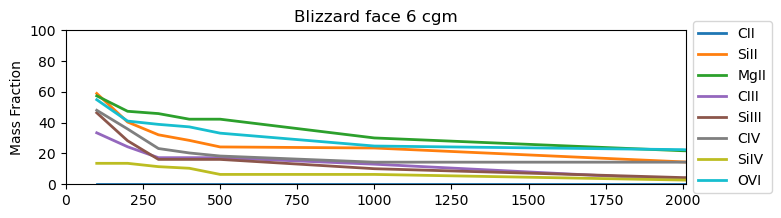

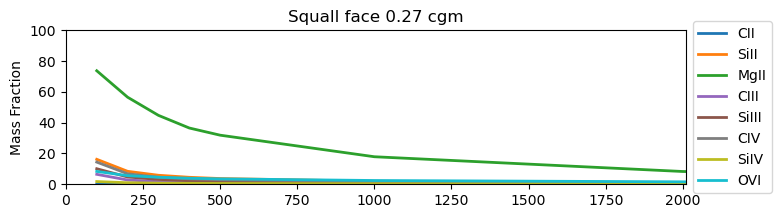

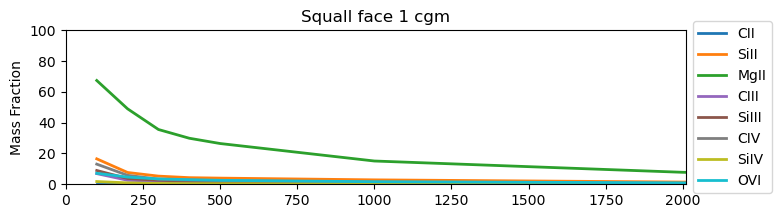

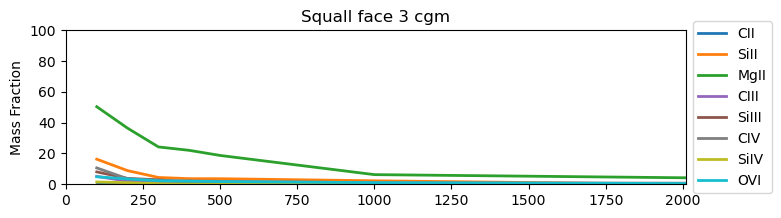

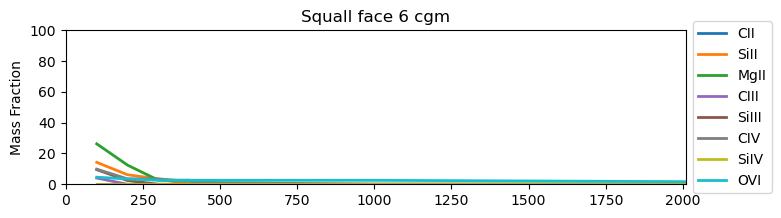

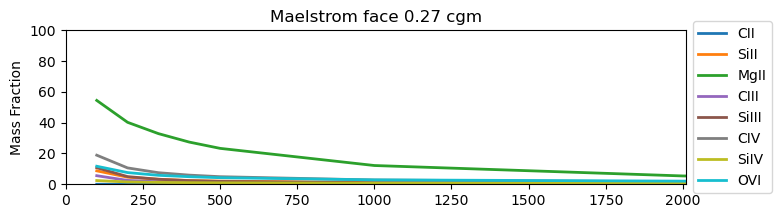

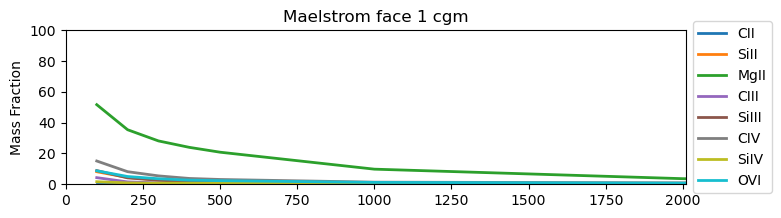

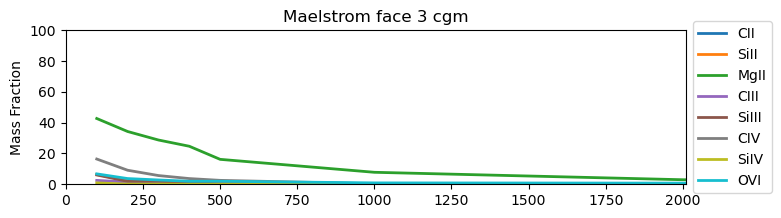

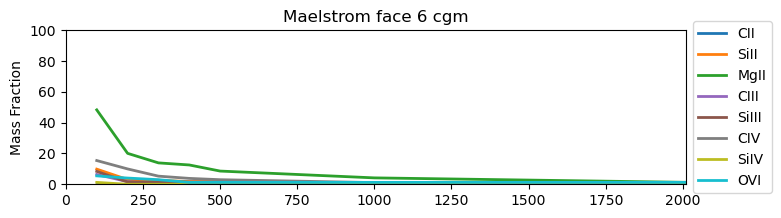

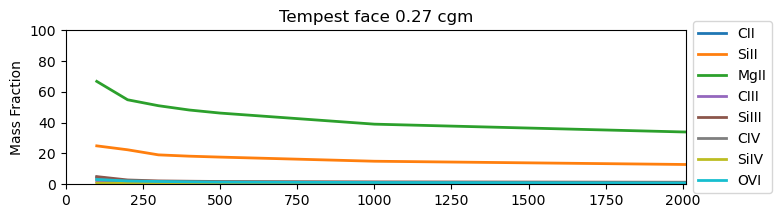

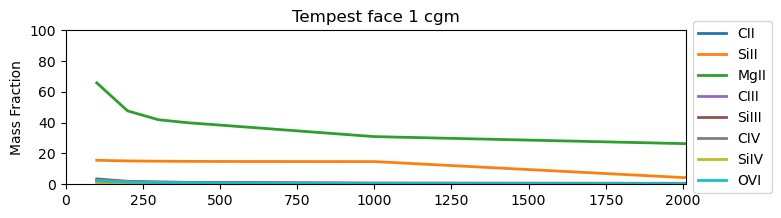

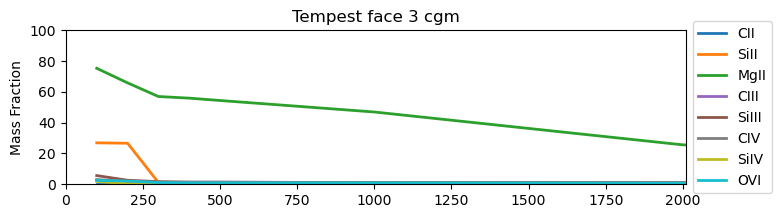

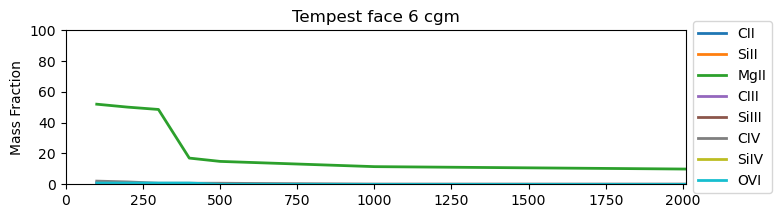

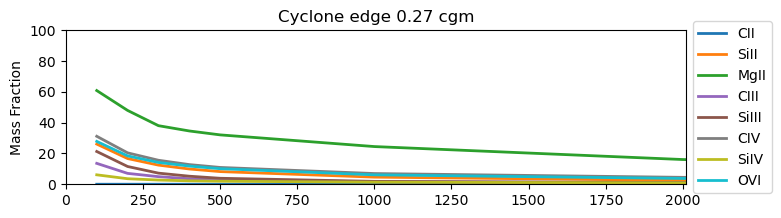

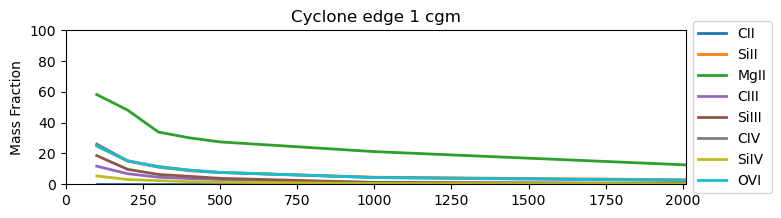

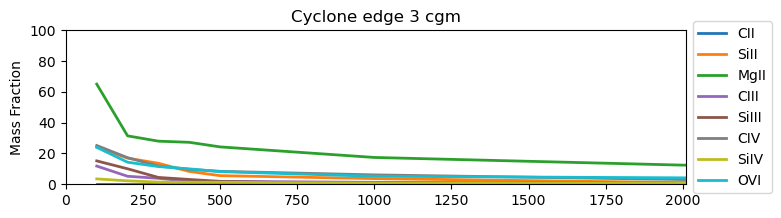

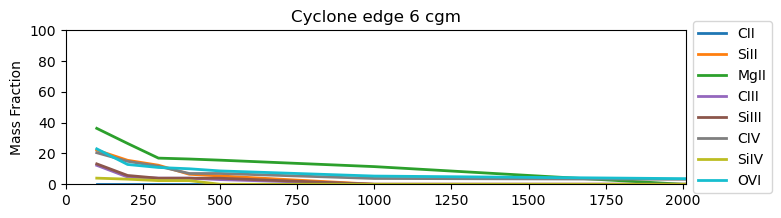

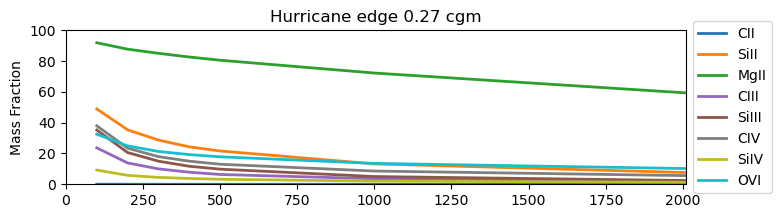

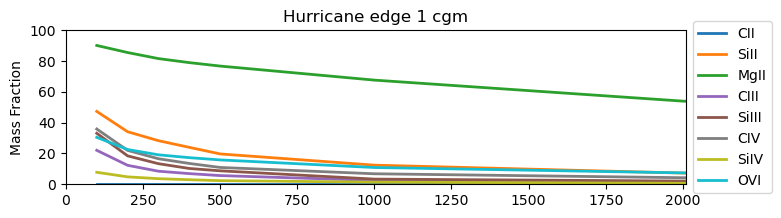

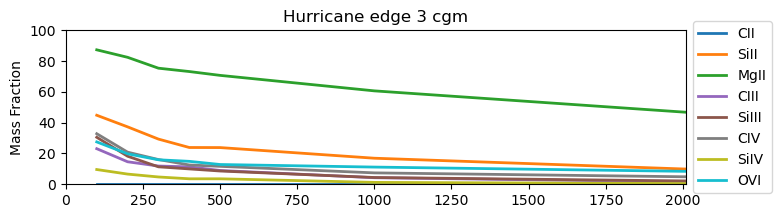

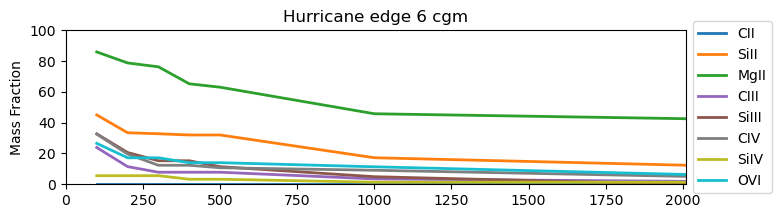

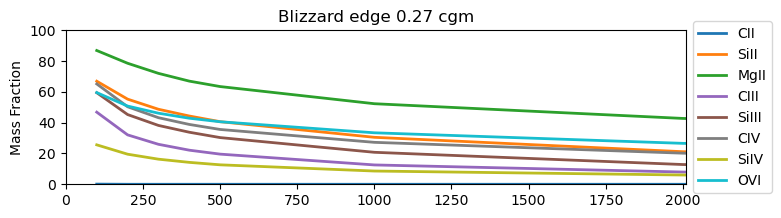

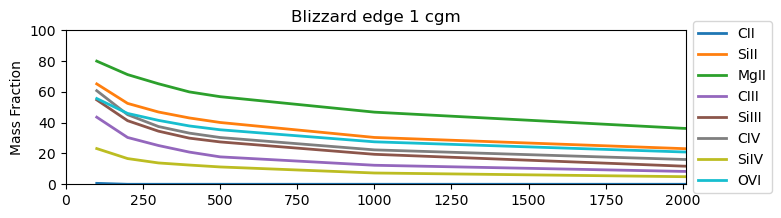

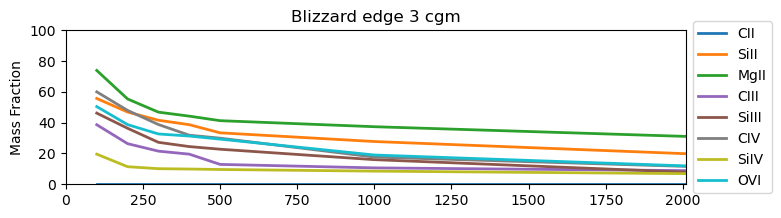

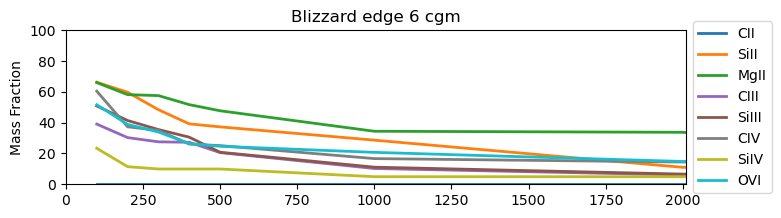

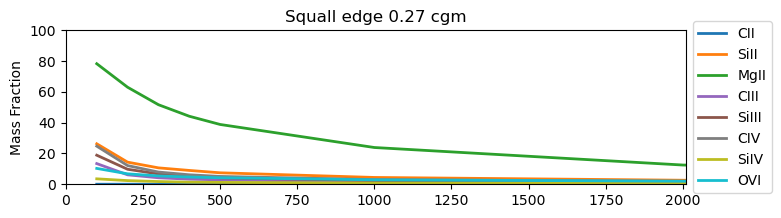

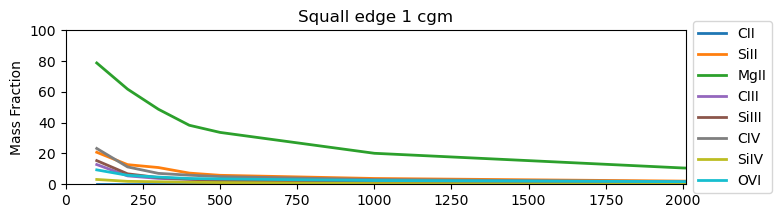

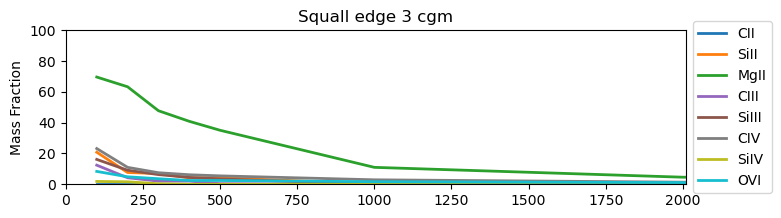

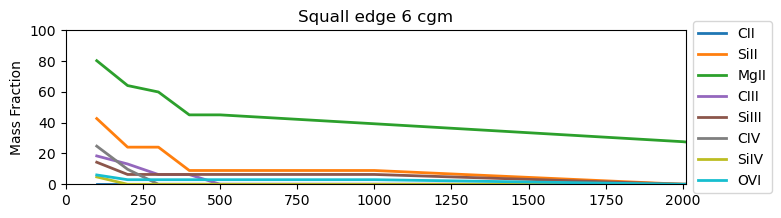

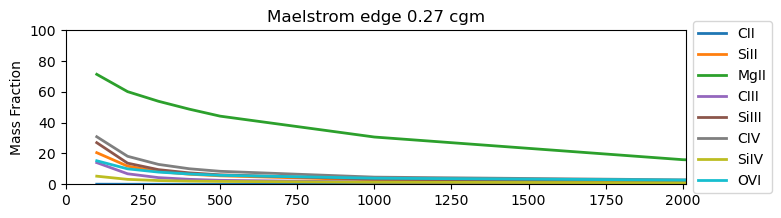

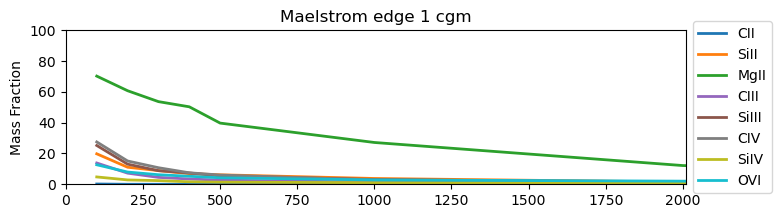

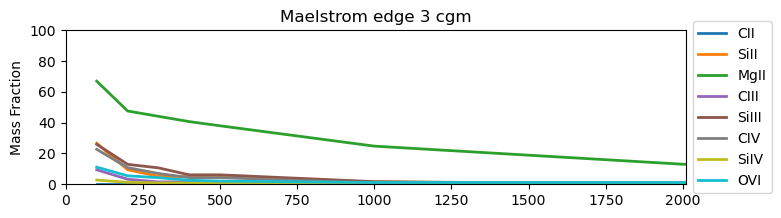

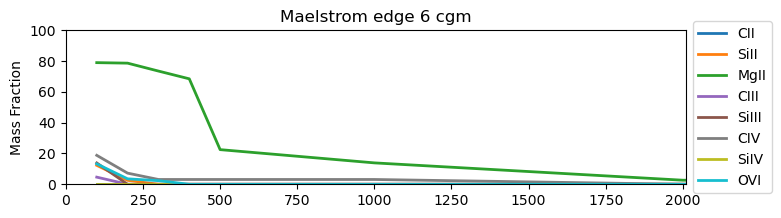

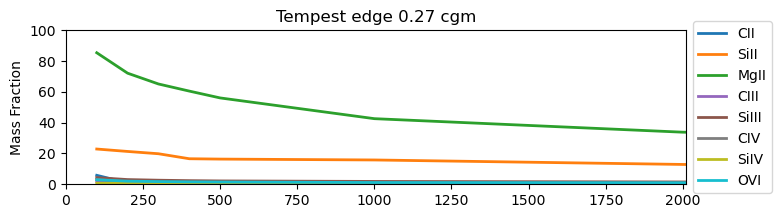

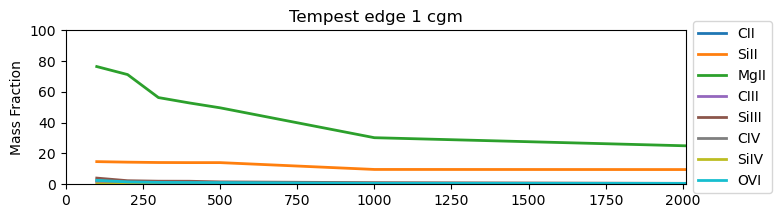

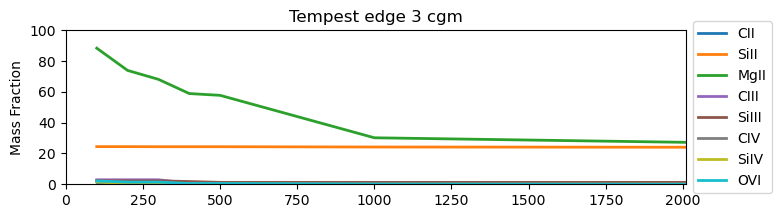

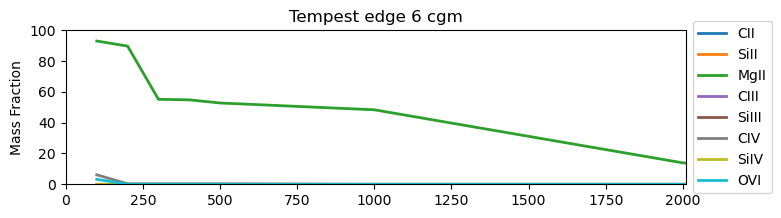

In [14]:
heatmap_data = {}
for orientation in orientations:
    for halo in halos:
        
        for resolution in resolutions:
            #print('halo:',halo,'resolution:',resolution)
            foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)
            halo_name = halo_dict[halo]

            if regions == ['all']:
                prefix = output_dir + '/' + 'plots_halo_00'+ halo + '/' + run +'/FOGGIE' + '/'+ output + '/' + 'box_' + box_name + '/'+ 'with_disk/' + str(resolution) + '/' 
            elif regions == ['cgm']:
                prefix = output_dir + '/' + 'plots_halo_00'+ halo + '/' + run +'/FOGGIE' + '/'+ output + '/' + 'box_' + box_name + '/'+ 'without_disk/' + str(resolution) + '/'  + 'disk_cgm' + '/'
                
            save_path = os.path.join(prefix, 'FRBs')
            file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

            for region in regions:
                plt.figure(figsize=(8,2))
                for ion in ions:
                    
                    with h5py.File(file_path, 'r') as f:
                        
                        spatial_res = f[f'z={z}'].attrs['FRB_pixel_size_kpc']
                        mass_data = np.array(f[f'z={z}/{ion}_mass_{orientation}_{region}']).flatten()
                        emission_data = np.array(f[f'z={z}/{ion}_emission_{orientation}_{region}']).flatten()
                        

                        
                    total_mass = mass_data.sum()
                    all_fraction = []
                    
                    for thresh in flux_thresholds[ion]:
                        
                        above_id = np.where(emission_data >= thresh)
                        mass_above = mass_data[above_id].sum()

                        frac = (mass_above / total_mass) * 100
                        all_fraction.append(frac)

                        heatmap_data.setdefault((halo, orientation, ion, region), []).append((spatial_res, thresh, frac))
                        

                    key = (halo, orientation, ion, region)
                    data = heatmap_data[key]

                    # Get unique sorted axes
                    spatial_res_vals = sorted(list(set([x[0] for x in data])))
                    flux_thresh_vals = sorted(list(set([x[1] for x in data])))

                    # Create 2D array
                    heatmap_array = np.full((len(flux_thresh_vals), len(spatial_res_vals)), np.nan)

                    for res, thresh, frac in data:
                        i = flux_thresh_vals.index(thresh)
                        j = spatial_res_vals.index(res)
                        heatmap_array[i, j] = frac
                    
                    plt.plot(flux_thresh_vals,all_fraction,label=ion, color=cmap(ions.index(ion)), linewidth=2)#
                    #plt.xscale('log')
                    #plt.xlabel('Flux Threshold')
                    plt.ylabel('Mass Fraction')
                    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                    plt.title(f'{halo_name} {orientation} {resolution} {region}')
                    plt.xlim(0, 2010)
                    plt.ylim(0, 100)
            plt.close
            plt.savefig(f'{save_path}/{halo_name}_{orientation}_{resolution}_{region}.png', dpi=300, bbox_inches='tight')
            plt.show()







In [ ]:


mass_fraction_data = {}

# === Fixed threshold (example: choose a value or loop over a few) ===
threshold = 2000  # Example fixed threshold
fixed_flux_thresh = {
    'CII': threshold,
    'CIII': threshold,
    'CIV': threshold,
    'OVI': threshold,
    'SiII': threshold,
    'SiIII': threshold,
    'SiIV': threshold,
    'MgII': threshold
}

['SiIII','SiIV','MgII']

for orientation in orientations:
    for halo in halos:
        for region in regions:
            plt.figure(figsize=(8,6))

            for ion in ions:
                res_vals = []
                mass_fractions = []

                for resolution in resolutions:
                    #print('halo:',halo,'resolution:',resolution)
                    foggie_dir, code_path, snap_name, halo_c_v_name, trackname, output_dir = generate_foggie_paths(halo, run, snap)
                    halo_name = halo_dict[halo]

                    prefix = output_dir + '/' + 'plots_halo_00'+ halo + '/' + run +'/FOGGIE' + '/'+ output + '/' + 'box_' + box_name + '/' + str(resolution) + '/'
                    save_path = os.path.join(prefix, 'FRBs')
                    file_path = os.path.join(save_path, f"{halo_name}_emission_maps.hdf5")

                    try:
                        with h5py.File(file_path, 'r') as f:
                            spatial_res = f['z=0.6'].attrs['FRB_pixel_size_kpc']
                            mass_data = np.array(f[f'z=0.6/{ion}_mass_{orientation}_{region}']).flatten()
                            emission_data = np.array(f[f'z=0.6/{ion}_emission_{orientation}_{region}']).flatten()

                        total_mass = mass_data.sum()
                        thresh = fixed_flux_thresh[ion]
                        above_id = np.where(emission_data >= thresh)
                        mass_above = mass_data[above_id].sum()

                        frac = (mass_above / total_mass) * 100
                        res_vals.append(spatial_res)
                        mass_fractions.append(frac)

                        mass_fraction_data.setdefault((halo, orientation, ion, region), []).append((spatial_res, frac))

                    except (OSError, KeyError) as e:
                        print(f"Skipping: {file_path} due to error: {e}")

                # Sort data by resolution for nice plotting
                res_vals, mass_fractions = zip(*sorted(zip(res_vals, mass_fractions)))

                plt.plot(res_vals, mass_fractions, label=ion, linewidth=2)

            plt.xlabel('Spatial Resolution (kpc)')
            plt.ylabel(f'Mass Fraction (>%g erg/s/cm²)' % list(fixed_flux_thresh.values())[0])  # Simplify if needed
            plt.title(f'Halo {halo_dict[halo]}, {orientation}, {region}')
            plt.legend()
            #plt.grid(True)
            plt.tight_layout()
            plt.show()


Skipping: /Users/vidasaeedzadeh/Projects/foggie_outputs//plots_halo_002392/nref11c_nref9f/FOGGIE/RD0042/box_100/0.27/FRBs/Hurricane_emission_maps.hdf5 due to error: [Errno 2] Unable to open file (unable to open file: name = '/Users/vidasaeedzadeh/Projects/foggie_outputs//plots_halo_002392/nref11c_nref9f/FOGGIE/RD0042/box_100/0.27/FRBs/Hurricane_emission_maps.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Skipping: /Users/vidasaeedzadeh/Projects/foggie_outputs//plots_halo_002392/nref11c_nref9f/FOGGIE/RD0042/box_100/1/FRBs/Hurricane_emission_maps.hdf5 due to error: [Errno 2] Unable to open file (unable to open file: name = '/Users/vidasaeedzadeh/Projects/foggie_outputs//plots_halo_002392/nref11c_nref9f/FOGGIE/RD0042/box_100/1/FRBs/Hurricane_emission_maps.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
Skipping: /Users/vidasaeedzadeh/Projects/foggie_outputs//plots_halo_002392/nref11c_nref9f/FOGGIE/RD0042/box_10

ValueError: not enough values to unpack (expected 2, got 0)

<Figure size 800x600 with 0 Axes>